In [901]:
import xml.etree.ElementTree as Xet
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import warnings
import re

# Ignore all warnings
warnings.filterwarnings('ignore')

# Arizona 2022 General Election PBER

## Load election results

Data from openelections, can be downloaded from Github at https://github.com/openelections/openelections-data-az/tree/master/2022

In [902]:
csv_path = './20221108__az__general__precinct.csv'
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)
election_results = pd.read_csv(csv_path)
election_results.head(5)

county        precinct  ... provisional  late_votes
0  Pinal       01 Kearny  ...         NaN         NaN
1  Pinal  04 Dudleyville  ...         NaN         NaN
2  Pinal   05 San Manuel  ...         NaN         NaN
3  Pinal      06 Mammoth  ...         NaN         NaN
4  Pinal       07 Oracle  ...         NaN         NaN

[5 rows x 11 columns]

Another dataset from MEDSL, just for double check, in cases where openelection data does not seem correct

In [903]:
csv_path_az = '../AZ-cleaned.csv'
election_results_MEDSL = pd.read_csv(csv_path_az)
election_results_MEDSL.head(5)

precinct  district     office  ...  readme_check magnitude special
0       01 KEARNY       NaN  US SENATE  ...          True         1   False
1  04 DUDLEYVILLE       NaN  US SENATE  ...          True         1   False
2   05 SAN MANUEL       NaN  US SENATE  ...          True         1   False
3      06 MAMMOTH       NaN  US SENATE  ...          True         1   False
4       07 ORACLE       NaN  US SENATE  ...          True         1   False

[5 rows x 25 columns]

### Process data

In [904]:
rows_before = election_results.shape[0]

# Formate votes to numbers
election_results['votes'] = pd.to_numeric(election_results['votes'], errors='coerce')

# Remove rows without a candidate
election_results_cleaned = election_results.dropna(subset=['candidate'])

rows_after = election_results_cleaned.shape[0]

# Remove rows without a valid vote
election_results_cleaned = election_results_cleaned[election_results_cleaned['votes'] > 0]

print(f"Number of rows before cleaning: {rows_before}")
print(f"Number of rows after cleaning: {rows_after}")

# Convert data types 
election_results_cleaned['votes'] = election_results_cleaned['votes'].astype(int)

# Display the cleaned data
election_results_cleaned.tail(5)

Number of rows before cleaning: 80027
Number of rows after cleaning: 75497


county          precinct  ... provisional  late_votes
80020  Yavapai    WATER (242.00)  ...         1.0         NaN
80021  Yavapai    BURRO (243.00)  ...         0.0         NaN
80022  Yavapai    BISON (244.00)  ...         0.0         NaN
80023  Yavapai  BIGHORN (245.00)  ...         0.0         NaN
80024  Yavapai    LASSO (246.00)  ...         0.0         NaN

[5 rows x 11 columns]

In [905]:
# Function to swap the parts of the name
def swap_name(name):
    # add a try catach
    try:
        parts = name.split(',')
        if len(parts) == 2:
            return parts[1].strip() + ' ' + parts[0].strip()
    except:
        return name
    return name

# Convert the 'party' column to strings, handling NaN values by filling them with an empty string or a placeholder
election_results_cleaned['party'] = election_results_cleaned['party'].astype(str)

# Clean and format
election_results_cleaned['party'] = election_results_cleaned['party'].str.strip().str.upper()
election_results_cleaned['office'] = election_results_cleaned['office'].str.strip().str.upper()
election_results_cleaned['candidate'] = election_results_cleaned['candidate'].str.strip().str.upper()
election_results_cleaned['candidate'] = election_results_cleaned['candidate'].apply(swap_name)

# Display the unique values for 'office', 'candidate', and 'party'
unique_offices = sorted(election_results_cleaned['office'].unique())
unique_candidates = sorted(election_results_cleaned['candidate'].unique())
unique_parties = sorted(election_results_cleaned['party'].unique())

print(f"Unique values in 'office':\n{unique_offices}")
print(f"\nUnique values in 'candidate':\n{unique_candidates}")
print(f"\nUnique values in 'party':\n{unique_parties}")

# Count the number of unique candidates for each office
unique_candidates_per_office = election_results_cleaned.groupby('office')['candidate'].nunique()

print("Number of unique candidates for each office:")
print(unique_candidates_per_office)

Unique values in 'office':
['ATTORNEY GENERAL', 'CORPORATION COMMISSIONER', 'GOVERNOR', 'SECRETARY OF STATE', 'STATE HOUSE', 'STATE MINE INSPECTOR', 'STATE SENATE', 'STATE TREASURER', 'U.S. HOUSE', 'U.S. SENATE']

Unique values in 'candidate':
['ABRAHAM "ABE" HAMADEH', 'ABRAHAM HAMADEH', 'ADRIAN FONTES', 'ALAN SMITH', 'ALEXANDER KOLODIN', 'ALICE NOVOA', 'ALIXANDRIA GUZMAN', 'ALMA HERNANDEZ', 'AMISH SHAH', 'ANALISE ORTIZ', 'ANASTASIA "STACEY" TRAVERS', 'ANDRES CANO', 'ANDY BIGGS', 'ANNA HERNANDEZ', 'ANTHONY CAMBONI', 'ANTHONY KERN', 'ATHENA SALMAN', 'AUSTIN SMITH', 'BARBARA ROWLEY PARKER', 'BEN TOMA', 'BEVERLY PINGERELLI', 'BILL LOUGHRIGE', 'BLAKE MASTERS', 'BRANDY REESE', 'BRIAN FERNANDEZ', 'BRIAN RADFORD', 'BRITTANI BARRAZA', 'CADEN DARROW', 'CATHERINE MIRANDA', 'CATHY RANSOM', 'CESAR AGUILAR', 'CHRIS MATHIS', 'CHRIS SARAPPO', 'CHRISTIAN LAMAR', 'CHRISTINE MARSH', 'CHRISTOPHER BULLOCK', 'CLINT WILLIAM SMITH', 'CONSUELO HERNANDEZ', 'CORY MCGARR', 'CYNTHIA "CINDY" HANS', 'DAMIEN KENNEDY

Just by looking at the values:


For values in 'office', they seem pretty correct  
  
For candidates, there exist: 'WRITE-IN', 'WRITE-INS', 'UNDER VOTES', 'OVER VOTES', 'NOT QUALIFIED'  
And these names look suspicious:  
'T., TOM'  
'QUEZADA, MARTÍN'  
'MERRILL, RAYSHAWN D'ANTHONY "SHAWN"'  
'MARTÍN QUEZADA' should be 'MARTÍN QUEZADA'  
'MARKY KELLY' should be 'MARK KELLY'  
'LUTES-BURTON, MIKAELA SHONNIE "MIKKI"'  
'JACQUELINE PARKER', 'JACUELINE PARKER'  
'HODGE, JEVIN D.'  
'HANS, CYNTHIA "CINDY"'  
'HAMADEH, ABRAHAM "ABE"'  
'GRIJALVA, RAUL', 'GRIJALVA, RAUL 32', 'GRIJALVA, RAÚL', 'GRIJALVA, RAÖL', 'GRIJALVA, RAÖL 160'  
'GARCIA SNYDER, GARY', 'GARY GARCIA SNYDER'  
'GABALDON, ROSANNA', 'GABALDÓN, ROSANNA'  
'EPSTEIN, DENISE "MITZI"'  
'DUNN, TIMOTHY "TIM"'  
'DI GENOVA, TRISTA', 'DI GENOVA, TRISTA "TRISTA"'  
'DENNY, STEPH NOELLE "STEPH"'  
'CHASTON, JAMES "JIM"'  
'BORDEN, DEBRA JO "D-JO"'  
'ABRAHAM "ABE" HAMADEH', 'ABRAHAM HAMADEH'  
  
For values in party, 'WRITE IN DEM' should be 'DEM', 'LBT' should be 'LIB'


In [906]:
# Get rid of rows where candidate is in 'UNDER VOTES', 'OVER VOTES', 'NOT QUALIFIED'
exclude_candidates = ['UNDER VOTES', 'OVER VOTES', 'NOT QUALIFIED']
election_results_cleaned = election_results_cleaned[~election_results_cleaned['candidate'].isin(exclude_candidates)]

# replace candidate with 'WRITE-INS' with 'WRITE-IN'
election_results_cleaned['candidate'] = election_results_cleaned['candidate'].replace('WRITE-INS', 'WRITE-IN')

# Categorize duplicated parties
election_results_cleaned['party'] = election_results_cleaned['party'].replace({
    'WRITE IN DEM': 'DEM',
    'LBT': 'LIB',
})

# Replace NA values in 'party' column with 'Other'
election_results_cleaned['party'] = election_results_cleaned['party'].fillna('N')


In [907]:
# Dictionary mapping old candidate names to new candidate names
replacement_dict = {
    'ABRAHAM "ABE" HAMADEH': 'ABRAHAM HAMADEH',
    'HAMADEH, ABRAHAM "ABE"': 'ABRAHAM HAMADEH',
    'BORDEN, DEBRA JO "D-JO"': 'DEBRA JO BORDEN',
    'CHASTON, JAMES "JIM"': 'CHASTON, JAMES',
    'DENNY, STEPH NOELLE "STEPH"': 'DENNY, STEPH NOELLE',
    'DUNN, TIMOTHY "TIM"': 'DUNN TIMOTHY',
    'EPSTEIN, DENISE "MITZI"': 'EPSTEIN, DENISE',
    'GABALDON, ROSANNA': 'GABALDÓN, ROSANNA',
    'GARCIA SNYDER, GARY': 'GARY, GARCIA SNYDER',
    'GRIJALVA, RAUL 32': 'RAUL GRIJALVA',
    'GRIJALVA, RAÚL': 'RAUL GRIJALVA',
    'GRIJALVA, RAÖL': 'RAUL GRIJALVA',
    'GRIJALVA, RAÖL 160': 'RAUL GRIJALVA',
    'HANS, CYNTHIA "CINDY"': 'HANS, CYNTHIA',
    'JACUELINE PARKER': 'JACQUELINE PARKER',
    'LUTES-BURTON, MIKAELA SHONNIE "MIKKI"': 'MIKARLA LUTES-BURTON', 
    'MARKY KELLY': 'MARK KELLY',
    'MART„N QUEZADA': 'MARTÍN QUEZADA',
    'QUEZADA, MART√ÇN':'MARTÍN QUEZADA',
    'MERRILL, RAYSHAWN D\'ANTHONY "SHAWN"': 'RAYSHAWN, MERRILL',
    'MAUL, LESTER "SKIP"1': 'MAUL, LESTER',
    'BRANNIES, MARYN M.': 'MARYN, BRANNIES',
    'CHAVIRA CONTRERAS, LUPE': 'LUPE, CONTRERAS',
    'CONTRERAS, PATRICIA "PATTY"': 'PATRICIA CONTRERAS',
    'DI GENOVA, TRISTA "TRISTA"': 'DI GENOVA, TRISTA',
    'GABALD√ÌN, ROSANNA': 'GABALDÓN, ROSANNA',
    'GARY, GARCIA SNYDER': 'GARY GARCIA SNYDER',
    'GRIJALVA, RA√ÖL': 'RAUL GRIJALVA',
    'GRIJALVA, RA√ÖL 160': 'RAUL GRIJALVA',
    'GRIJALVA, RAUL': 'RAUL GRIJALVA',
    'HODGE, JEVIN D.': 'JEVIN, HODGE',
    'JONES, STEPHAN "STEVE"': 'JONES STEPHAN',
    'JUAN CISOMANI': 'JUAN CISCOMANI',
    'LEO BISIUCCI': 'LEO BIASIUCCI',
    'MARTIN QUEZADA': 'MARTÍN QUEZADA',
    'QUEZADA, MARTIN': 'MARTÍN QUEZADA',
    'QUEZADA, MARTÍN': 'MARTÍN QUEZADA',
    'FONTES, ADRIAN': 'ADRIAN FONTES',
    'AGUILAR, CESAR': 'CESAR AGUILAR',
    'SMITH, ALAN': 'ALAN SMITH',
    'NOVOA, ALICE': 'ALICE NOVOA',
    'ALSTON, LELA': 'LELA ALSTON',
    'BIGGS, ANDY': 'ANDY BIGGS',
    'CAMBONI, ANTHONY': 'ANTHONY CAMBONI',
    'AUSTIN, LORENA': 'LORENA AUSTIN',
    'BARBARA ROWLEY PARKER': 'BARBARA PARKER',
    'PARKER, BARBARA ROWLEY': 'BARBARA PARKER',
    'BARRAZA, BRITTANI': 'BRITTANI, BARRAZA',
    'BARTO, NANCY': 'NANCY BARTO',
    'BIASIUCCI, LEO': 'LEO BIASIUCCI',
    'MASTERS, BLAKE': 'BLAKE MASTERS',
    'BLATTMAN, SETH': 'SETH BLATTMAN',
    'BORDES, SHERRISE': 'SHERRISE BORDES',
    'BORRELLI, SONNY': 'SONNY BORRELLI',
    'BRAVO, FLAVIO': 'FLAVIO BRAVO',
    'FERNANDEZ, BRIAN': 'BRIAN FERNANDEZ',
    'BULLOCK, CHRISTOPHER': 'CHRISTOPHER BULLOCK',
    'BURCH, EVA': 'EVA BURCH',
    'CARBONE, MICHAEL': 'MICHAEL CARBONE',
    'CARROLL, FRANK': 'FRANK CARROLL',
    'CARTER, NEAL': 'NEAL CARTER',
    'CASTEEN, JEANNE': 'JEANNE CASTEEN',
    'JESUS JR. LUGO': 'JESUS LUGO',
    'MIKAELA SHONNIE  "MIKKI" LUTES-BURTON': 'MIKAELA LUTES-BURTON',
    'NICHOLAS "NICK" MYERS': 'NICK MYERS',
    'ROSANNA GABALDON': 'ROSANNA GABALDÓN', 
    'TATIANA PEÑA M.': 'TATIANA PENA',
    'THOMAS "T.J." SHOPE': 'THOMAS SHOPE',
    'TY RICHARD JR. MCLEAN': 'TY MCLEAN',
    'WILLIAM JOSUE POUNDS IV': 'WILLIAM POUNDS',
    'WILLIAM JOSUÉ IV POUNDS': 'WILLIAM POUNDS',
    'RA√ÖL GRIJALVA': 'RAUL GRIJALVA',
    'ROSANNA GABALD√ÌN': 'ROSANNA GABALDÓN',
    'RAÚL GRIJALVA': 'RAUL GRIJALVA',
    'RA√ÖL 160 GRIJALVA': 'RAUL GRIJALVA',
    'RA√ÖL GRIJALVA': 'RAUL GRIJALVA',
    'RAUL 32 GRIJALVA': 'RAUL GRIJALVA',
    'STEPH NOELLE "STEPH" DENNY': 'STEPH NOELLE DENNY',
    'MART√ÇN QUEZADA': 'MARTÍN QUEZADA',
    'JR. RICHARD TY MCLEAN': 'TY MCLEAN',
    'RAYSHAWN D\'ANTHONY "SHAWN" MERRILL': 'RAYSHAWN MERRILL',
    'KRISTEN ENGEL': 'KIRSTEN ENGEL',
    'TOM T.': 'WRITE-IN',
    'WRITE_IN': 'WRITE-IN',
}

# Replace old candidate names with new names
election_results_cleaned['candidate'] = election_results_cleaned['candidate'].replace(replacement_dict)
election_results_cleaned = election_results_cleaned[~election_results_cleaned['candidate'].str.contains(r'\b(Jr\.|Sr\.)\b', regex=True, na=False)]
election_results_cleaned['candidate'] = election_results_cleaned['candidate'].str.replace("'", "", regex=False)

unique_candidates_after_mapping = sorted(election_results_cleaned['candidate'].unique())
unique_candidates_after_mapping

['ABRAHAM HAMADEH',
 'ADRIAN FONTES',
 'ALAN SMITH',
 'ALEXANDER KOLODIN',
 'ALICE NOVOA',
 'ALIXANDRIA GUZMAN',
 'ALMA HERNANDEZ',
 'AMISH SHAH',
 'ANALISE ORTIZ',
 'ANASTASIA "STACEY" TRAVERS',
 'ANDRES CANO',
 'ANDY BIGGS',
 'ANNA HERNANDEZ',
 'ANTHONY CAMBONI',
 'ANTHONY KERN',
 'ATHENA SALMAN',
 'AUSTIN SMITH',
 'BARBARA PARKER',
 'BEN TOMA',
 'BEVERLY PINGERELLI',
 'BILL LOUGHRIGE',
 'BLAKE MASTERS',
 'BRANDY REESE',
 'BRIAN FERNANDEZ',
 'BRIAN RADFORD',
 'BRITTANI BARRAZA',
 'CADEN DARROW',
 'CATHERINE MIRANDA',
 'CATHY RANSOM',
 'CESAR AGUILAR',
 'CHRIS MATHIS',
 'CHRIS SARAPPO',
 'CHRISTIAN LAMAR',
 'CHRISTINE MARSH',
 'CHRISTOPHER BULLOCK',
 'CLINT WILLIAM SMITH',
 'CONSUELO HERNANDEZ',
 'CORY MCGARR',
 'CYNTHIA "CINDY" HANS',
 'DAMIEN KENNEDY',
 'DANA ALLMOND',
 'DAVID CHRISTIAN FARNSWORTH',
 'DAVID COOK',
 'DAVID GOWAN',
 'DAVID LIVINGSTON',
 'DAVID MARSHALL SR.',
 'DAVID RAYMER',
 'DAVID SANDOVAL',
 'DAVID SCHWEIKERT',
 'DAVID WAYNE RICHARDSON',
 'DEBBIE LESKO',
 'DEBORAH 

everything now looks right, besides this guy 'TOM T.'

In [908]:
# Filter rows where candidate is 'TOM T.'
tom_t_rows = election_results_cleaned[election_results_cleaned['candidate'] == 'TOM T.']

tom_t_rows


Empty DataFrame
Columns: [county, precinct, office, district, candidate, party, votes, early_voting, election_day, provisional, late_votes]
Index: []

After searching, there is no such person as Tom T and he had no party affiliation, only Tom O'Halleran who runs for U.S. Representative in Congress - District No. 2. So change this Tom T to write-in.

In [909]:
# Print the names of the columns in the final DataFrame
print("Column names in the final DataFrame:")
print(election_results_cleaned.columns.tolist())

Column names in the final DataFrame:
['county', 'precinct', 'office', 'district', 'candidate', 'party', 'votes', 'early_voting', 'election_day', 'provisional', 'late_votes']


In [910]:
# Group by office, district, and candidate, and sum the votes
office_district_candidate_votes = election_results_cleaned.groupby(['office', 'district', 'candidate'], dropna=False)['votes'].sum()

# Print the number of votes for each candidate
for (office, district, candidate), votes in office_district_candidate_votes.items():
    district_info = f"District {int(district)}" if pd.notna(district) else "Not Specified"
    print(f"Office: {office} - {district_info} - Candidate: {candidate}, Votes: {votes}")


Office: ATTORNEY GENERAL - Not Specified - Candidate: ABRAHAM HAMADEH, Votes: 1281904
Office: ATTORNEY GENERAL - Not Specified - Candidate: KRIS MAYES, Votes: 1272453
Office: ATTORNEY GENERAL - Not Specified - Candidate: SAMANTHA SEVERSON, Votes: 257
Office: ATTORNEY GENERAL - Not Specified - Candidate: WRITE-IN, Votes: 3116
Office: CORPORATION COMMISSIONER - Not Specified - Candidate: KEVIN THOMPSON, Votes: 374299
Office: CORPORATION COMMISSIONER - Not Specified - Candidate: LAUREN KUBY, Votes: 353377
Office: CORPORATION COMMISSIONER - Not Specified - Candidate: NICK MYERS, Votes: 376125
Office: CORPORATION COMMISSIONER - Not Specified - Candidate: SANDRA KENNEDY, Votes: 385663
Office: CORPORATION COMMISSIONER - Not Specified - Candidate: WRITE-IN, Votes: 3644
Office: GOVERNOR - Not Specified - Candidate: ALICE NOVOA, Votes: 37
Office: GOVERNOR - Not Specified - Candidate: ANTHONY CAMBONI, Votes: 23
Office: GOVERNOR - Not Specified - Candidate: KARI LAKE, Votes: 1270774
Office: GOVERN

## Process Election Data

In [911]:
# Create a mapping for 'office'
office_mapping = {
    'ATTORNEY GENERAL': 'ATG',
    'CORPORATION COMMISSIONER': 'COC',
    'GOVERNOR': 'GOV',
    'SECRETARY OF STATE': 'SOS',
    'STATE HOUSE': 'SL',
    'STATE MINE INSPECTOR': 'STM',
    'STATE SENATE': 'SU',
    'STATE TREASURER': 'STT',
    'U.S. HOUSE': 'USH',
    'U.S. SENATE': 'USS'
}


# Find the largest district number
max_district = int(election_results_cleaned['district'].max())

# Determine the number of digits for district formatting
num_digits = len(str(max_district))

# Function to create a unique column name and print its meaning
def create_column_name(row, existing_names, num_digits):
    office_abbr = office_mapping.get(row['office'], '')
    party_initial = row['party'][0]
    last_name = row['candidate'].split()[-1][:3].upper()
    
    if pd.notna(row['district']):
        district = str(int(row['district'])).zfill(num_digits)  # Ensure district has leading zeros
        base_name = f"G{office_abbr}{district}{party_initial}{last_name}"
    else:
        base_name = f"G22{office_abbr}{party_initial}{last_name}"
    
    # Ensure the column name is unique
    if base_name not in existing_names:
        unique_name = base_name
    else:
        suffix = 1
        unique_name = f"{base_name}_{suffix}"
        while unique_name in existing_names:
            suffix += 1
            unique_name = f"{base_name}_{suffix}"
    
    # Print the meaning of the generated column name
    district_info = f"District {district}" if pd.notna(row['district']) else "General Election Year 2022"
    # print(f"{unique_name}: Candidate - {row['candidate']}, Party - {row['party']}, Office - {row['office']}, {district_info},  ")

    return unique_name


# Get unique combinations of counties and precincts
unique_combinations = election_results_cleaned[['county', 'precinct']].drop_duplicates()

# Initialize an empty list to store the results
results = []

# Iterate over each unique combination of county and precinct
for _, unique_row in unique_combinations.iterrows():
    county = unique_row['county']
    precinct = unique_row['precinct']
    
    # Filter for the specific county and precinct
    filtered_df = election_results_cleaned[(election_results_cleaned['county'] == county) & (election_results_cleaned['precinct'] == precinct)]
    
    # Track existing column names to ensure uniqueness
    existing_names = set()
    
    # Apply the function to create new column names
    filtered_df['ColumnName'] = filtered_df.apply(lambda row: create_column_name(row, existing_names, num_digits), axis=1)
    
    # Update the set of existing names
    existing_names.update(filtered_df['ColumnName'].tolist())
    
    # Pivot dataset so that each row represents a precinct and each column represents a candidate
    pivoted_df = filtered_df.pivot_table(
        index=['county', 'precinct'],
        columns='ColumnName',
        values='votes',
        aggfunc='sum'
    )
    
    # Flatten the columns
    pivoted_df.columns = [col for col in pivoted_df.columns]
    
    # Reset index
    pivoted_df.reset_index(inplace=True)
    
    # Append results
    results.append(pivoted_df)

# Concatenate all results
final_df = pd.concat(results, ignore_index=True)

final_df

county              precinct  ...  G22GOVWCAM  G22USSWROX
0       Pinal             01 Kearny  ...         NaN         NaN
1       Pinal        04 Dudleyville  ...         NaN         NaN
2       Pinal         05 San Manuel  ...         NaN         NaN
3       Pinal            06 Mammoth  ...         NaN         NaN
4       Pinal             07 Oracle  ...         NaN         NaN
5       Pinal  08 Saddlebrooke West  ...         NaN         NaN
6       Pinal       09 Arizona City  ...         NaN         NaN
7       Pinal       10 Toltec South  ...         NaN         NaN
8       Pinal            11 Picacho  ...         NaN         NaN
...       ...                   ...  ...         ...         ...
1685  Yavapai       COYOTE (239.00)  ...         NaN         NaN
1686  Yavapai         CARS (240.00)  ...         NaN         NaN
1687  Yavapai        STONE (241.00)  ...         NaN         NaN
1688  Yavapai        WATER (242.00)  ...         NaN         NaN
1689  Yavapai        BURRO (243.00)  ...         1.0         NaN
1690  Yavapai        BISON (244.00)  ...         NaN         1.0
1691  Yavapai      BIGHORN (245.00)  ...         NaN         NaN
1692  Yavapai        LASSO (246.00)  ...         NaN         NaN
1693  Yavapai        CHAPS (247.00)  ...         NaN         NaN

[1694 rows x 262 columns]

change NWRI to OWRI as it is more standard

In [912]:
final_df.columns = [col.replace('NWRI', 'OWRI') if col.endswith('NWRI') else col for col in final_df.columns]
NWRI_columns = [col for col in final_df.columns if col.endswith('NWRI')]
# make sure no NWRI exists
print(NWRI_columns)
assert NWRI_columns == []

[]


get the column name & explanation for README file

In [913]:
# Reverse the office mapping to go from abbreviation to full office name
office_reverse_mapping = {v: k for k, v in office_mapping.items()}

def explain_column_name(column_name):
    # Check if the column name is long enough to be parsed
    if len(column_name) < 7:
        return f"{column_name}: Not enough information to parse."

    # Extract the parts of the column name with safety checks
    office_type = column_name[1:4] if len(column_name) >= 4 else ''
    district = column_name[4:6] if len(column_name) >= 6 else ''
    party_initial = column_name[6] if len(column_name) >= 7 else ''
    candidate_last_name = column_name[7:] if len(column_name) >= 8 else ''
    
    # Handle special case for general election year columns without a district
    if column_name.startswith('G22'):
        office_type = column_name[3:6]  # Get the office type without '22'
        district = "General Election Year 2022"
    else:
        district = f"District {district}" if district else "Unknown District"

    # Get the full office name from the mapping
    office_name = office_reverse_mapping.get(office_type, office_type)
    
    # Generate the explanation
    explanation = (
        f"{column_name}: Candidate - {candidate_last_name}, "
        f"Party - {party_initial}, Office - {office_name}, {district}"
    )
    
    return explanation

# Loop through each column, starting from the 3rd column, and print the explanation
for column in final_df.columns[2:]:  # Start from the 3rd column
    print(explain_column_name(column))


G22ATGDMAY: Candidate - MAY, Party - D, Office - ATTORNEY GENERAL, General Election Year 2022
G22ATGRHAM: Candidate - HAM, Party - R, Office - ATTORNEY GENERAL, General Election Year 2022
G22COCDKEN: Candidate - KEN, Party - D, Office - CORPORATION COMMISSIONER, General Election Year 2022
G22COCDKUB: Candidate - KUB, Party - D, Office - CORPORATION COMMISSIONER, General Election Year 2022
G22COCRMYE: Candidate - MYE, Party - R, Office - CORPORATION COMMISSIONER, General Election Year 2022
G22COCRTHO: Candidate - THO, Party - R, Office - CORPORATION COMMISSIONER, General Election Year 2022
G22GOVDHOB: Candidate - HOB, Party - D, Office - GOVERNOR, General Election Year 2022
G22GOVOWRI: Candidate - WRI, Party - O, Office - GOVERNOR, General Election Year 2022
G22GOVRLAK: Candidate - LAK, Party - R, Office - GOVERNOR, General Election Year 2022
G22SOSDFON: Candidate - FON, Party - D, Office - SECRETARY OF STATE, General Election Year 2022
G22SOSOWRI: Candidate - WRI, Party - O, Office - S

### Count # of precincts for each county

In [914]:
count_unique_df1 = final_df.groupby('county')['precinct'].nunique()
for county, count in count_unique_df1.items():
    print(f"{county}: {count}")

Apache: 44
Cochise: 54
Coconino: 75
Gila: 39
Graham: 22
Greenlee: 8
La Paz: 11
Maricopa: 904
Mohave: 24
Navajo: 14
Pima: 266
Pinal: 108
Santa Cruz: 35
Yavapai: 46
Yuma: 44


### Read AZ 2020 shapefile for potential re-use, in case where 2022 data is not available

In [915]:
# Read the shapefile
shapefile_path = '../az_gen_20_prec/az_gen_20_prec.shp'
gdf = gpd.read_file(shapefile_path)

# Select only the desired columns
selected_columns = ['geometry', 'PRECINCTNA', 'COUNTY_NAM', 'UNIQUE_ID', 'COUNTYFP','PCTNUM', 'CDE_COUNTY', 'CON_DIST', 'SLDL_DIST', 'SLDU_DIST']
gdf_2020 = gdf[selected_columns]

def remove_special_characters(column):
    return column.str.replace(r'[^\w\s]', '', regex=True)

gdf_2020['PRECINCTNA'] = remove_special_characters(gdf_2020['PRECINCTNA'])
gdf_2020['COUNTY_NAM'] = remove_special_characters(gdf_2020['COUNTY_NAM'])
gdf_2020['UNIQUE_ID'] = remove_special_characters(gdf_2020['UNIQUE_ID'])

print(gdf_2020)


                                               geometry  ... SLDU_DIST
0     POLYGON ((-109.49567 33.65280, -109.49576 33.6...  ...        07
1     POLYGON ((-109.71666 36.26151, -109.71658 36.2...  ...        07
2     POLYGON ((-109.81183 36.27512, -109.80810 36.2...  ...        07
3     POLYGON ((-109.53982 34.44871, -109.53928 34.4...  ...        07
4     POLYGON ((-109.81768 36.14760, -109.81822 36.1...  ...        07
5     POLYGON ((-109.16169 34.44067, -109.16175 34.4...  ...        07
6     POLYGON ((-110.00068 36.62770, -110.00068 36.6...  ...        07
7     POLYGON ((-109.29166 34.11102, -109.29168 34.1...  ...        07
8     POLYGON ((-109.04689 34.09608, -109.04689 34.0...  ...        07
...                                                 ...  ...       ...
1480  POLYGON ((-109.23301 32.71849, -109.23936 32.7...  ...        14
1481  POLYGON ((-109.41245 32.97681, -109.42544 32.9...  ...        14
1482  POLYGON ((-109.49558 33.58165, -109.49560 33.5...  ...        14
1483  

## Process precinct boundaries by county

#### Some helper functions

Function to plot gdf

In [916]:
def plot_precincts_with_labels(gdf):
    fig, ax = plt.subplots(figsize=(40, 40))
    gdf.plot(column='precinct', ax=ax, legend=True, cmap='tab20', edgecolor='black', linewidth=0.5)
    for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['precinct']):
        ax.text(x, y, label, fontsize=15, ha='center')
    plt.show()

In [917]:
def plot_precincts(gdf, col_name):
    fig, ax = plt.subplots(figsize=(40, 40))
    gdf.plot(column=col_name, ax=ax, legend=True, cmap='tab20', edgecolor='black', linewidth=0.5)
    for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf[col_name]):
        ax.text(x, y, label, fontsize=15, ha='center')
    plt.show()

Function to check precinct district numbers(if they needs split)

In [918]:
import re

def check_precinct_districts(df_name):
    def extract_district_from_column_name(column_name):
        match = re.search(r'(\d+)', column_name)
        if match:
            return match.group(1)
        return None

    def extract_office_type(column_name):
        if column_name.startswith('GUS'):
            return column_name[1:4]
        else:
            return column_name[1:3]

    inconsistencies_found = False

    for index, row in df_name.iterrows():
        print(f"Row {index + 1}:")
        
        districts = {}

        # Iterate through the columns of interest
        for column_name in df_name.columns:
            if column_name.startswith(('GUSH', 'GSL', 'GSU')) and pd.notna(row[column_name]) and row[column_name] > 0 :
                district_number = extract_district_from_column_name(column_name)
                office_type = extract_office_type(column_name)
                
                if district_number:
                    print(f"  Column: {column_name}, Office Type: {office_type}, District: {district_number}, Value: {row[column_name]}")
                    if office_type in districts:
                        if districts[office_type] != district_number:
                            print(f"Inconsistent district numbers for {office_type}! Previous: {districts[office_type]}, Current: {district_number}")
                            inconsistencies_found = True
                    else:
                        districts[office_type] = district_number

        print("\n")

    if not inconsistencies_found:
        print("All rows are consistent. No duplicate district numbers found for any office type.")
    else:
        print("Inconsistencies were found in some rows.")

Function to add CON_DIST, SLDL_DIST, SLDU_DIST columns to dataset

In [919]:
def add_districts_numbers(df):
  df['CON_DIST'] = None
  df['SLDL_DIST'] = None
  df['SLDU_DIST'] = None

  # Function to extract district number from column name
  def extract_district_from_column_name(column_name):
      match = re.search(r'(\d+)', column_name)
      if match:
          return match.group(1)
      return None

  # Function to extract the office type from column name
  def extract_office_type(column_name):
      if column_name.startswith('GUS'):  # Handles 'USH' and 'USS'
          return column_name[1:4]
      else:
          return column_name[1:3]  # Handles 'SL' and 'SU'

  # Iterate over each row in final_df to populate the district columns
  for index, row in df.iterrows():
      districts = {'USH': None, 'SL': None, 'SU': None}

      # Iterate through relevant columns to find district numbers
      for column_name in df.columns:
          if column_name.startswith(('GUSH', 'GSL', 'GSU')) and pd.notna(row[column_name]) and row[column_name] > 0:
              district_number = extract_district_from_column_name(column_name)
              office_type = extract_office_type(column_name)
              
              if district_number:
                  if office_type == 'USH':
                      df.at[index, 'CON_DIST'] = district_number
                  elif office_type == 'SL':
                      df.at[index, 'SLDL_DIST'] = district_number
                  elif office_type == 'SU':
                      df.at[index, 'SLDU_DIST'] = district_number

  cols = df.columns.tolist()

  # Remove the new columns from the end of the list
  cols.remove('CON_DIST')
  cols.remove('SLDL_DIST')
  cols.remove('SLDU_DIST')

  # Insert the new columns at the desired positions
  cols.insert(5, 'CON_DIST')
  cols.insert(6, 'SLDL_DIST')
  cols.insert(7, 'SLDU_DIST')

  # Reorder the DataFrame's columns
  df = df[cols]
  # Display the updated DataFrame

  return df




### Coconino County

In [920]:
coconino_rows = final_df[final_df['county'].str.lower() == 'coconino']
coconino_rows.head(5)

county          precinct  G22ATGDMAY  ...  G22USSWBOR  G22GOVWCAM  G22USSWROX
299  Coconino  01 - FLAGSTAFF 1      1000.0  ...         NaN         NaN         NaN
300  Coconino  02 - FLAGSTAFF 2       800.0  ...         NaN         NaN         NaN
301  Coconino  03 - FLAGSTAFF 3       618.0  ...         NaN         NaN         NaN
302  Coconino  04 - FLAGSTAFF 4      1032.0  ...         NaN         NaN         NaN
303  Coconino  05 - FLAGSTAFF 5      1174.0  ...         NaN         NaN         NaN

[5 rows x 262 columns]

In [921]:
def extract_precinct_name(precinct):
    return re.sub(r'^\d+\s*-\s*', '', precinct)

coconino_rows['precinct_name'] = coconino_rows['precinct'].apply(extract_precinct_name)
coconino_rows.head(5)

county          precinct  ...  G22USSWROX  precinct_name
299  Coconino  01 - FLAGSTAFF 1  ...         NaN    FLAGSTAFF 1
300  Coconino  02 - FLAGSTAFF 2  ...         NaN    FLAGSTAFF 2
301  Coconino  03 - FLAGSTAFF 3  ...         NaN    FLAGSTAFF 3
302  Coconino  04 - FLAGSTAFF 4  ...         NaN    FLAGSTAFF 4
303  Coconino  05 - FLAGSTAFF 5  ...         NaN    FLAGSTAFF 5

[5 rows x 263 columns]

       county precinct  G22ATGDMAY  ...  G22GOVWCAM  G22USSWROX        precinct_name
299  Coconino        1      1000.0  ...         NaN         NaN          FLAGSTAFF 1
300  Coconino        2       800.0  ...         NaN         NaN          FLAGSTAFF 2
301  Coconino        3       618.0  ...         NaN         NaN          FLAGSTAFF 3
302  Coconino        4      1032.0  ...         NaN         NaN          FLAGSTAFF 4
303  Coconino        5      1174.0  ...         NaN         NaN          FLAGSTAFF 5
304  Coconino        6       479.0  ...         NaN         NaN          FLAGSTAFF 6
305  Coconino        7       727.0  ...         NaN         NaN          FLAGSTAFF 7
306  Coconino        8       519.0  ...         NaN         NaN          FLAGSTAFF 8
307  Coconino        9       589.0  ...         NaN         NaN          FLAGSTAFF 9
..        ...      ...         ...  ...         ...         ...                  ...
365  Coconino       90       844.0  ...         NaN         NaN  

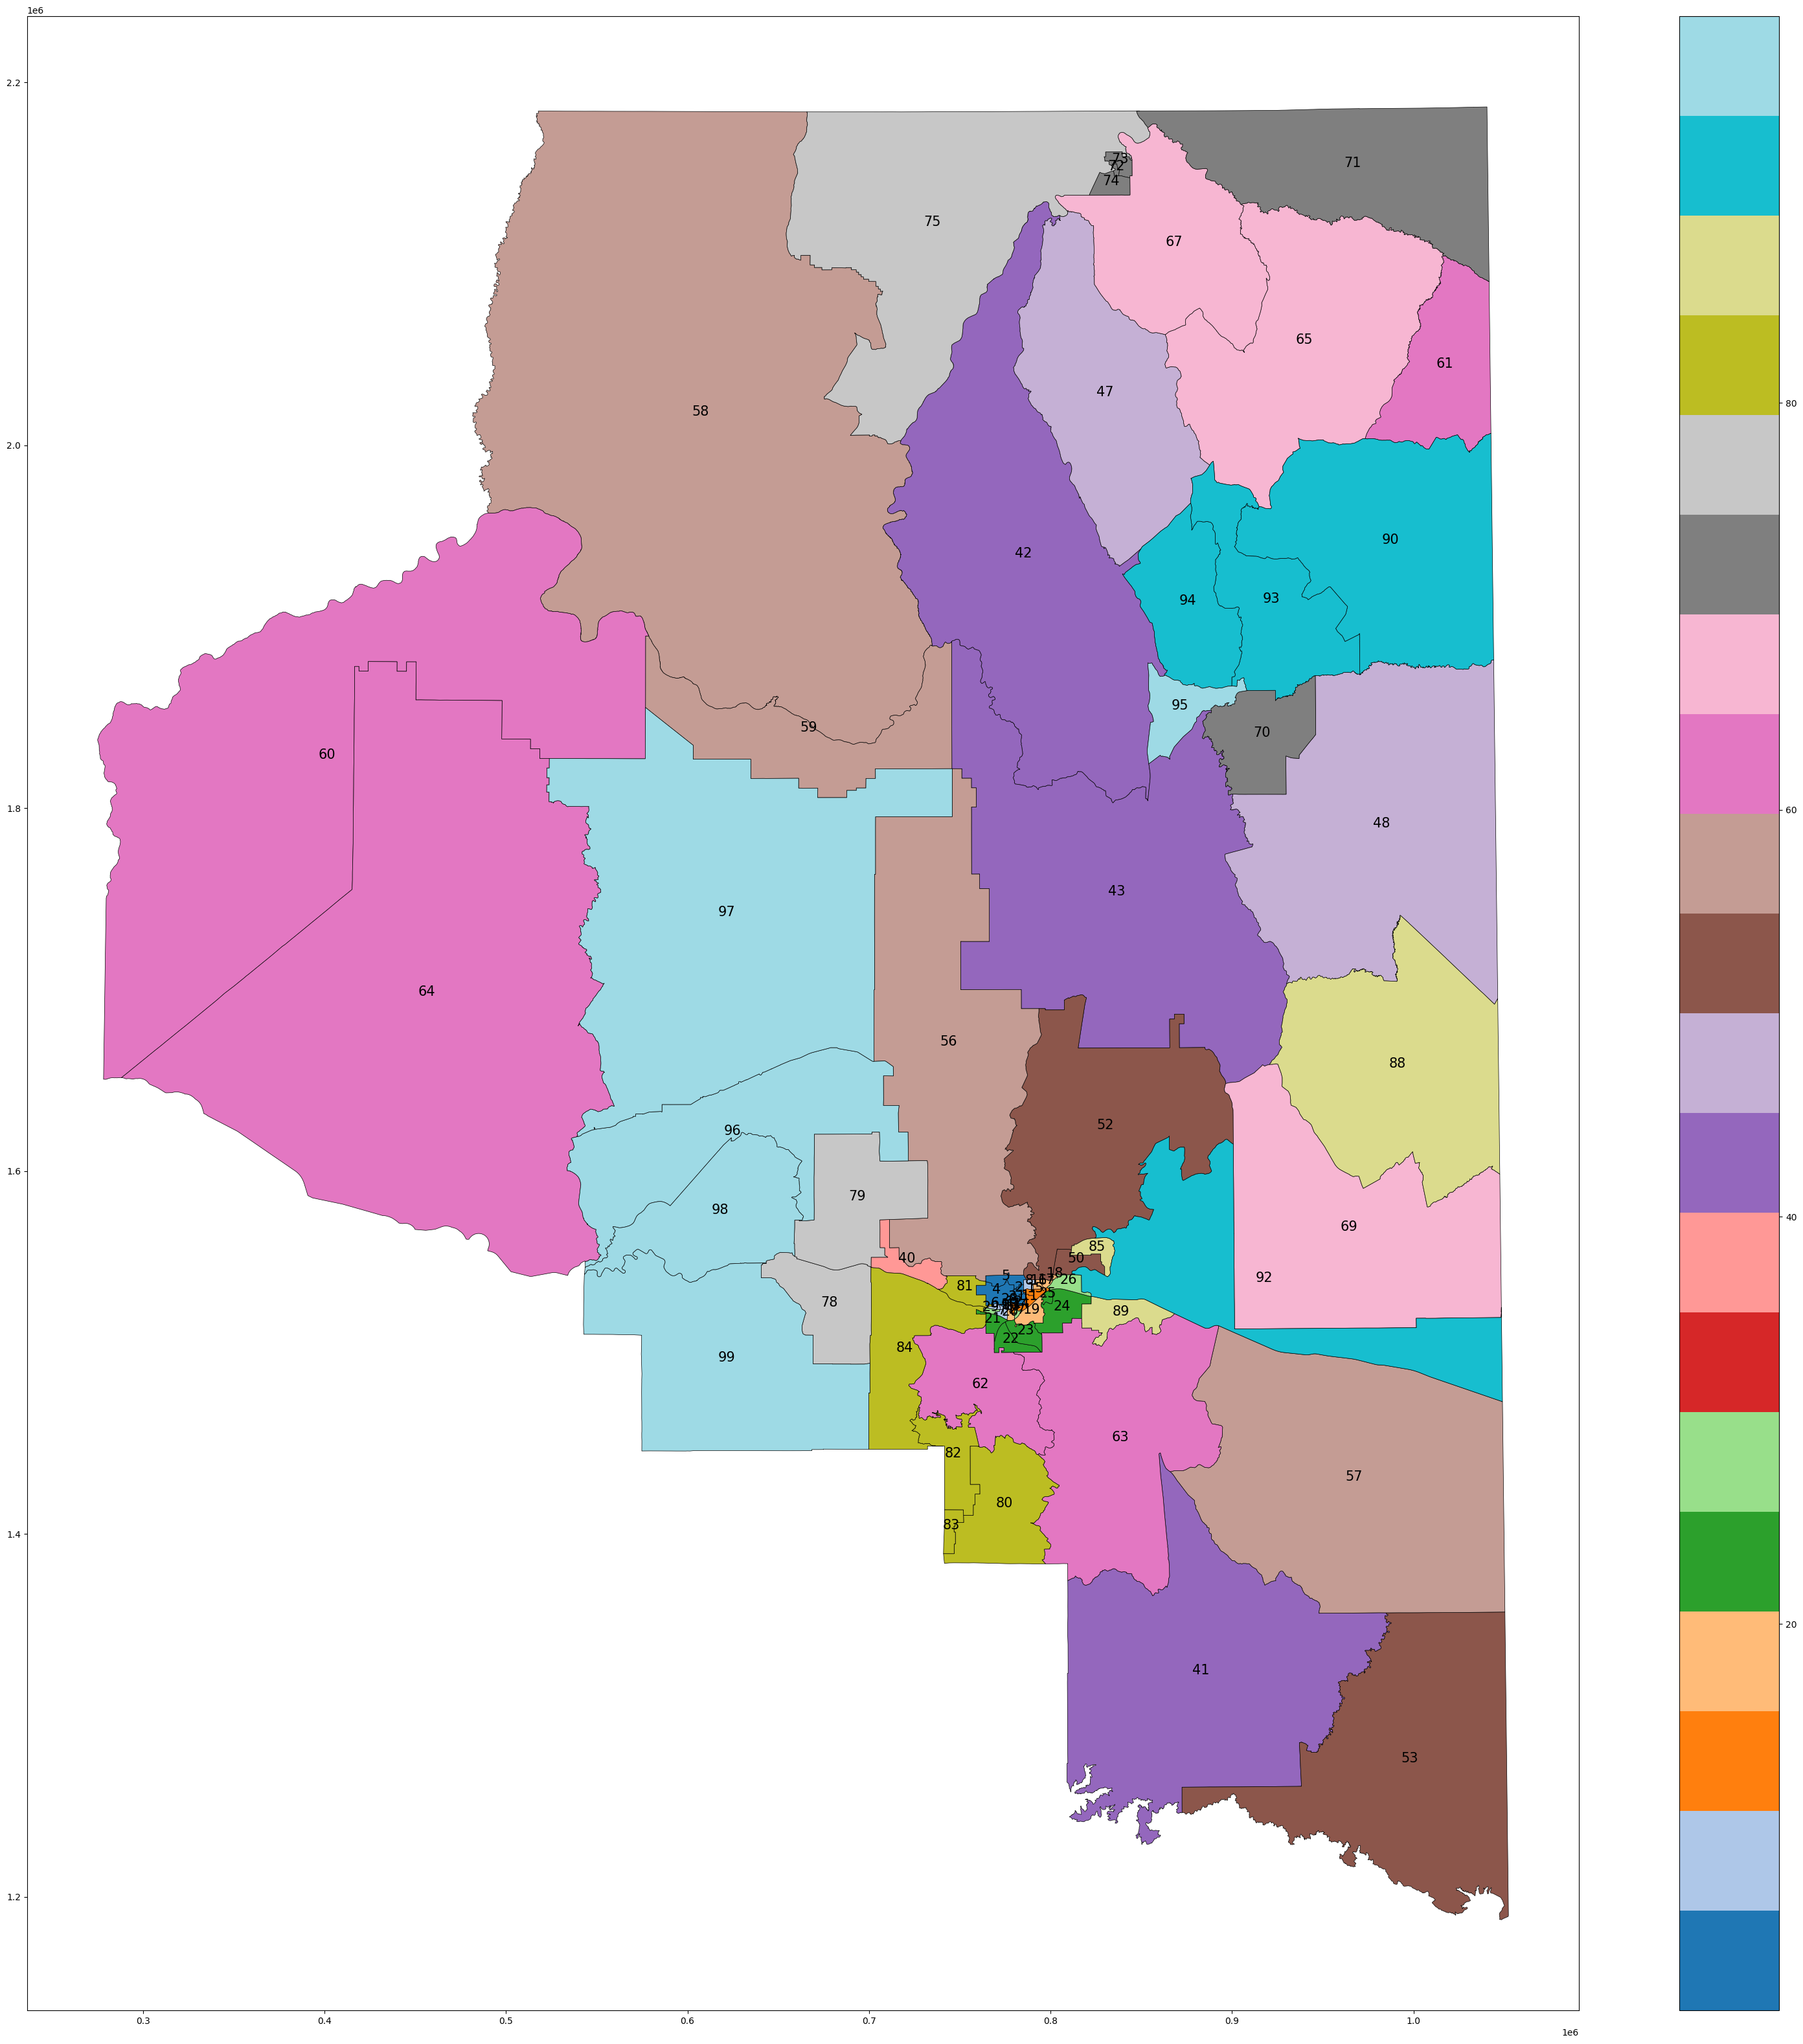

In [922]:
# Read in the GeoJSON file
geojson_file_Cococino = './precinct_boundaries/Cococino.geojson'
gdf_Cococino = gpd.read_file(geojson_file_Cococino)

final_df_Coconino = coconino_rows

# Extract the numerical part from the precinct values
final_df_Coconino['precinct'] = final_df_Coconino['precinct'].str.extract('(\d+)')[0].astype(int)

gdf_Cococino['VOTENUM'] = gdf_Cococino['VOTENUM'].astype(int)


# Merge the DataFrames on precinct_num and VOTENUM
merged_df = final_df_Coconino.merge(gdf_Cococino[['VOTENUM', 'geometry']], left_on='precinct', right_on='VOTENUM', how='outer', indicator=True)

# Convert final_df to a GeoDataFrame
gdf_Cococino_final = gpd.GeoDataFrame(merged_df, geometry='geometry')
final_df_Coconino['precinct'] = final_df_Coconino['precinct'].astype(str)
print(final_df_Coconino)

plot_precincts_with_labels(gdf_Cococino_final)

In [923]:
gdf_Cococino_final.drop(columns=['VOTENUM'], inplace=True)

indicator_counts = gdf_Cococino_final['_merge'].value_counts()
print(indicator_counts)

# Display the first 5 rows of the updated DataFrame
gdf_Cococino_final.head(5)


_merge
both          75
left_only      0
right_only     0
Name: count, dtype: int64


county  ...  _merge
0  Coconino  ...    both
1  Coconino  ...    both
2  Coconino  ...    both
3  Coconino  ...    both
4  Coconino  ...    both

[5 rows x 265 columns]

In [924]:
check_precinct_districts(gdf_Cococino_final)

Row 1:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 1013.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 271.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value: 1.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 952.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 839.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 41.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 1023.0
  Column: GSU06OWRI, Office Type: SU, District: 06, Value: 58.0


Row 2:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 811.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 127.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value: 1.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 743.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 665.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 19.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 794.0
  

In [925]:
gdf_Cococino_final['UNIQUE_ID'] = gdf_Cococino_final['precinct_name']

gdf_Cococino_final = gdf_Cococino_final.rename(columns={'precinct': 'PCTNUM'})
gdf_Cococino_final = gdf_Cococino_final.rename(columns={'county': 'COUNTY_NAM'})

gdf_Cococino_final.drop(columns=['_merge'], inplace=True)

gdf_Cococino_final = gdf_Cococino_final.rename(columns={'precinct_name': 'PRECINCTNA'})
gdf_Cococino_final['COUNTYFP'] = '005'

cols = gdf_Cococino_final.columns.tolist()
cols.insert(2, cols.pop(cols.index('PRECINCTNA')))
cols.insert(1, cols.pop(cols.index('COUNTYFP')))
cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))

gdf_Cococino_final = gdf_Cococino_final[cols]

gdf_Cococino_final.head(5)

UNIQUE_ID  ...                                           geometry
0  FLAGSTAFF 1  ...  POLYGON ((785865.395 1532109.130, 785894.714 1...
1  FLAGSTAFF 2  ...  POLYGON ((785237.611 1534472.194, 784828.852 1...
2  FLAGSTAFF 3  ...  POLYGON ((781398.115 1530200.808, 781383.637 1...
3  FLAGSTAFF 4  ...  POLYGON ((776275.689 1539747.216, 776351.992 1...
4  FLAGSTAFF 5  ...  POLYGON ((785145.855 1542697.010, 785351.031 1...

[5 rows x 266 columns]

In [926]:
check_precinct_districts(gdf_Cococino_final)
gdf_Cococino_final = add_districts_numbers(gdf_Cococino_final)
gdf_Cococino_final

Row 1:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 1013.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 271.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value: 1.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 952.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 839.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 41.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 1023.0
  Column: GSU06OWRI, Office Type: SU, District: 06, Value: 58.0


Row 2:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 811.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 127.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value: 1.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 743.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 665.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 19.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 794.0
  

UNIQUE_ID  ...                                           geometry
0           FLAGSTAFF 1  ...  POLYGON ((785865.395 1532109.130, 785894.714 1...
1           FLAGSTAFF 2  ...  POLYGON ((785237.611 1534472.194, 784828.852 1...
2           FLAGSTAFF 3  ...  POLYGON ((781398.115 1530200.808, 781383.637 1...
3           FLAGSTAFF 4  ...  POLYGON ((776275.689 1539747.216, 776351.992 1...
4           FLAGSTAFF 5  ...  POLYGON ((785145.855 1542697.010, 785351.031 1...
5           FLAGSTAFF 6  ...  POLYGON ((771325.063 1526296.381, 771436.438 1...
6           FLAGSTAFF 7  ...  POLYGON ((769585.683 1520821.365, 769617.005 1...
7           FLAGSTAFF 8  ...  POLYGON ((790536.180 1534929.173, 790537.337 1...
8           FLAGSTAFF 9  ...  POLYGON ((772221.345 1526166.343, 772660.677 1...
..                  ...  ...                                                ...
66              TONALEA  ...  POLYGON ((1044156.871 1881739.444, 1044076.240...
67               WINONA  ...  POLYGON ((868197.051 1521467.855, 867519.973 1...
68  TUBA CITY NORTHEAST  ...  POLYGON ((915066.778 1966125.726, 914992.707 1...
69  TUBA CITY NORTHWEST  ...  POLYGON ((899861.695 1867253.186, 899644.064 1...
70      TUBA CITY SOUTH  ...  POLYGON ((862909.623 1873102.503, 862926.416 1...
71          HOWARD MESA  ...  POLYGON ((661575.028 1572981.319, 662565.433 1...
72              TUSAYAN  ...  POLYGON ((603155.862 1827243.017, 603153.350 1...
73       WILLIAMS NORTH  ...  POLYGON ((661575.028 1572981.319, 660351.697 1...
74       WILLIAMS SOUTH  ...  POLYGON ((577036.219 1554488.269, 577188.532 1...

[75 rows x 269 columns]

### Apache County


In [927]:
apache_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Apache']
apache_2020.head(5)

geometry  ... SLDU_DIST
0  POLYGON ((-109.49567 33.65280, -109.49576 33.6...  ...        07
1  POLYGON ((-109.71666 36.26151, -109.71658 36.2...  ...        07
2  POLYGON ((-109.81183 36.27512, -109.80810 36.2...  ...        07
3  POLYGON ((-109.53982 34.44871, -109.53928 34.4...  ...        07
4  POLYGON ((-109.81768 36.14760, -109.81822 36.1...  ...        07

[5 rows x 10 columns]

In [928]:
apache_rows = final_df[final_df['county'].str.lower() == 'apache']
apache_rows['precinct'] = apache_rows['precinct'].str.upper()
print(apache_rows.head(5))

     county             precinct  ...  G22GOVWCAM  G22USSWROX
374  Apache            02 ALPINE  ...         NaN         NaN
375  Apache  03 CANYON DE CHELLY  ...         NaN         NaN
376  Apache            05 CHINLE  ...         NaN         NaN
377  Apache            09 CONCHO  ...         NaN         NaN
378  Apache        10 CORNFIELDS  ...         NaN         NaN

[5 rows x 262 columns]


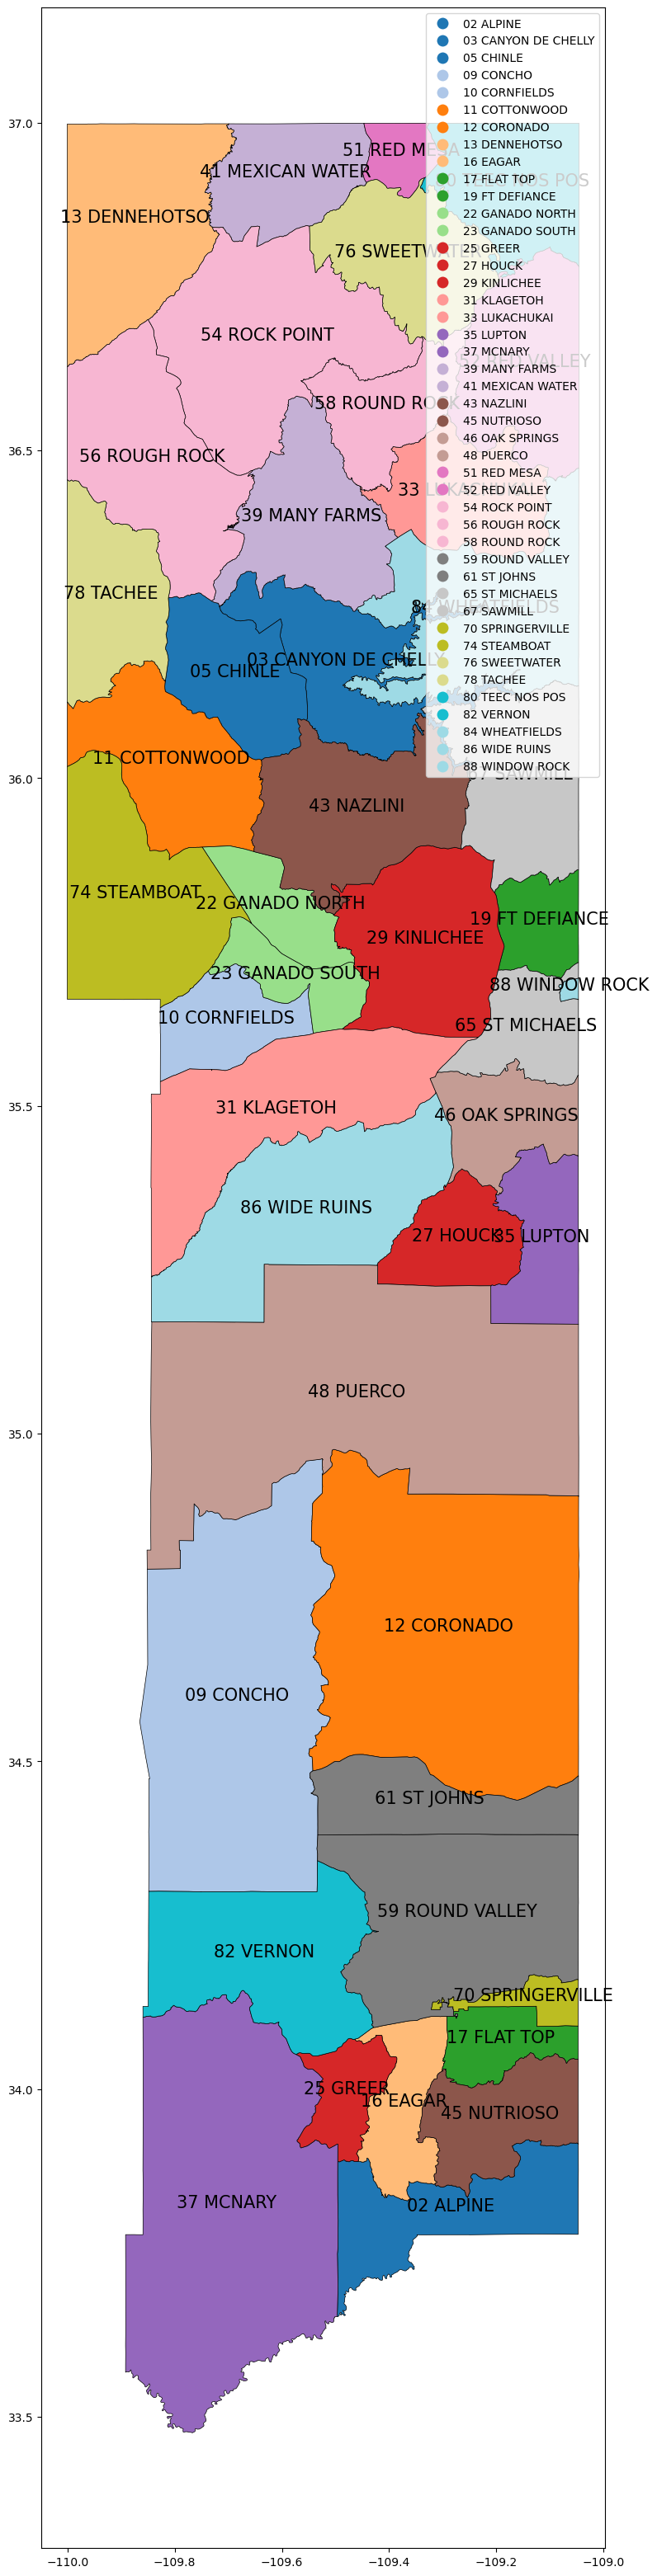

county             precinct  G22ATGDMAY  ...  SLDL_DIST  SLDU_DIST  _merge
0  Apache            02 ALPINE        96.0  ...         07         07    both
1  Apache  03 CANYON DE CHELLY      1412.0  ...         07         07    both
2  Apache            05 CHINLE       729.0  ...         07         07    both
3  Apache            09 CONCHO       307.0  ...         07         07    both
4  Apache        10 CORNFIELDS       330.0  ...         07         07    both

[5 rows x 272 columns]

In [929]:
# Merge the dataframes on UNIQUE_ID and precinct
gdf_Apache_final = apache_rows.merge(apache_2020[['geometry', 'PRECINCTNA', 'COUNTY_NAM', 'UNIQUE_ID', 'COUNTYFP','PCTNUM', 'CDE_COUNTY', 'CON_DIST', 'SLDL_DIST', 'SLDU_DIST']], 
                                       left_on='precinct', 
                                       right_on='UNIQUE_ID', 
                                       how='outer',
                                       indicator=True)

gdf_Apache_final = gdf_Apache_final.drop(columns=['UNIQUE_ID'])

gdf_Apache_final = gpd.GeoDataFrame(gdf_Apache_final, geometry='geometry')


plot_precincts_with_labels(gdf_Apache_final)
gdf_Apache_final.head(5)

In [930]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Apache_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)


_merge
both          44
left_only      0
right_only     0
Name: count, dtype: int64


In [931]:
check_precinct_districts(gdf_Apache_final)


Row 1:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 95.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 283.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 117.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 108.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 31.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 133.0
  Column: GSU06OWRI, Office Type: SU, District: 06, Value: 57.0


Row 2:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 1403.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 171.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value: 3.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 870.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 1251.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 18.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 1503.0
  Column: GSU06OWRI, Office Type: SU, District: 06, Value: 18.0


R

In [932]:
def process_precinct_column(df):
    # Function to extract the numeric part from the precinct
    def extract_precinct_num(precinct):
        match = re.match(r'\d+', precinct)
        if match:
            return match.group(0)
        return None

    # Function to extract the alphabetic part (text) from the precinct
    def extract_precinct_name(precinct):
        match = re.search(r'[A-Za-z\s]+$', precinct)
        if match:
            return match.group(0).strip()  # Strip any leading/trailing whitespace
        return None

    # Apply the functions to create the new columns
    df['PCTNUM'] = df['precinct'].apply(extract_precinct_num)
    df['PRECINCTNA'] = df['precinct'].apply(extract_precinct_name)
    
    return df

gdf_Apache_final = process_precinct_column(gdf_Apache_final)

In [933]:
gdf_Apache_final['UNIQUE_ID'] = gdf_Apache_final['precinct']
gdf_Apache_final.head(5)

county             precinct  ...  _merge            UNIQUE_ID
0  Apache            02 ALPINE  ...    both            02 ALPINE
1  Apache  03 CANYON DE CHELLY  ...    both  03 CANYON DE CHELLY
2  Apache            05 CHINLE  ...    both            05 CHINLE
3  Apache            09 CONCHO  ...    both            09 CONCHO
4  Apache        10 CORNFIELDS  ...    both        10 CORNFIELDS

[5 rows x 273 columns]

In [934]:
# gdf_Apache_final.drop(columns=['PRECINCTNA'], inplace=True)
gdf_Apache_final.drop(columns=['COUNTY_NAM'], inplace=True)
gdf_Apache_final.drop(columns=['COUNTYFP'], inplace=True)
# gdf_Apache_final.drop(columns=['PCTNUM'], inplace=True)
gdf_Apache_final.drop(columns=['CDE_COUNTY'], inplace=True)
gdf_Apache_final.drop(columns=['CON_DIST'], inplace=True)
gdf_Apache_final.drop(columns=['SLDL_DIST'], inplace=True)
gdf_Apache_final.drop(columns=['SLDU_DIST'], inplace=True)
gdf_Apache_final.drop(columns=['_merge'], inplace=True)

gdf_Apache_final.head(5)


county             precinct  ...  PCTNUM            UNIQUE_ID
0  Apache            02 ALPINE  ...      02            02 ALPINE
1  Apache  03 CANYON DE CHELLY  ...      03  03 CANYON DE CHELLY
2  Apache            05 CHINLE  ...      05            05 CHINLE
3  Apache            09 CONCHO  ...      09            09 CONCHO
4  Apache        10 CORNFIELDS  ...      10        10 CORNFIELDS

[5 rows x 266 columns]

In [935]:

gdf_Apache_final = gdf_Apache_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Apache_final.drop(columns=['precinct'], inplace=True)

gdf_Apache_final['COUNTYFP'] = '001'


cols = gdf_Apache_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Apache_final = gdf_Apache_final[cols]

gdf_Apache_final = add_districts_numbers(gdf_Apache_final)


gdf_Apache_final.head(5)


UNIQUE_ID  ...                                           geometry
0            02 ALPINE  ...  POLYGON ((-109.49567 33.65280, -109.49576 33.6...
1  03 CANYON DE CHELLY  ...  POLYGON ((-109.71666 36.26151, -109.71658 36.2...
2            05 CHINLE  ...  POLYGON ((-109.81183 36.27512, -109.80810 36.2...
3            09 CONCHO  ...  POLYGON ((-109.53982 34.44871, -109.53928 34.4...
4        10 CORNFIELDS  ...  POLYGON ((-109.82694 35.53686, -109.82692 35.5...

[5 rows x 269 columns]

### Cochise County

In [936]:
cochise_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Cochise']
cochise_2020

geometry  ... SLDU_DIST
35   POLYGON ((-110.33348 31.94738, -110.33371 31.9...  ...        14
36   POLYGON ((-110.45230 31.77535, -110.45232 31.7...  ...        14
37   POLYGON ((-110.29864 31.97089, -110.29860 31.9...  ...        14
38   POLYGON ((-109.54522 31.36092, -109.54520 31.3...  ...        14
39   POLYGON ((-110.13931 31.43816, -110.13917 31.4...  ...        14
40   POLYGON ((-110.45990 31.37506, -110.45988 31.3...  ...        14
41   POLYGON ((-109.89812 31.41661, -109.89882 31.4...  ...        14
42   POLYGON ((-109.91918 31.36537, -109.91921 31.3...  ...        14
43   POLYGON ((-110.27948 31.97802, -110.27948 31.9...  ...        14
..                                                 ...  ...       ...
296  POLYGON ((-110.25737 31.51097, -110.25737 31.5...  ...        14
297  POLYGON ((-110.28534 31.53956, -110.28884 31.5...  ...        14
298  POLYGON ((-110.18968 31.59675, -110.18841 31.5...  ...        14
299  POLYGON ((-110.25057 31.54674, -110.25035 31.5...  ...        14
300  POLYGON ((-110.25737 31.51097, -110.25738 31.5...  ...        14
302  POLYGON ((-110.30533 31.47177, -110.30588 31.4...  ...        14
303  POLYGON ((-109.76224 31.72970, -109.76224 31.7...  ...        14
304  POLYGON ((-110.02788 32.22654, -110.02805 32.2...  ...        14
305  POLYGON ((-109.85503 32.25360, -109.85515 32.2...  ...        14

[49 rows x 10 columns]

In [937]:
cochise_rows = final_df[final_df['county'].str.lower() == 'cochise']
# cochise_rows['precinct'] = remove_special_characters(cochise_rows['precinct'])
# cochise_rows['precinct'] = cochise_rows['precinct'].str.extract('(\d+)')[0].astype(str).str.lstrip('0').astype(int)
cochise_rows

county                 precinct  ...  G22GOVWCAM  G22USSWROX
187  Cochise             01 BE BENSON  ...         NaN         NaN
188  Cochise              02 BE J-SIX  ...         NaN         NaN
189  Cochise          03 BE SAN PEDRO  ...         NaN         NaN
190  Cochise             04 BI BISBEE  ...         NaN         NaN
191  Cochise           05 BI DON LUIS  ...         NaN         NaN
192  Cochise             06 BI WARREN  ...         NaN         NaN
193  Cochise                 07 BOWIE  ...         NaN         NaN
194  Cochise    08 COCHISE STRONGHOLD  ...         NaN         NaN
195  Cochise            09 DO CALVARY  ...         NaN         NaN
..       ...                      ...  ...         ...         ...
232  Cochise             46 WHETSTONE  ...         NaN         NaN
233  Cochise  47 WI KANSAS SETTLEMENT  ...         NaN         NaN
234  Cochise            48 WI STEWART  ...         NaN         NaN
235  Cochise            49 WI WILLCOX  ...         NaN         NaN
236  Cochise              50 DO GRAND  ...         NaN         NaN
237  Cochise         51 BI SACRAMENTO  ...         NaN         NaN
238  Cochise         52 THREE CANYONS  ...         NaN         NaN
239  Cochise             53 GREENBUSH  ...         NaN         NaN
240  Cochise                54 PARKER  ...         NaN         NaN

[54 rows x 262 columns]

In [938]:
def process_precinct_column(df):
    # Function to extract the numeric part from the precinct
    def extract_precinct_num(precinct):
        match = re.match(r'\d+', precinct)
        if match:
            return match.group(0)
        return None

    # Function to extract the alphabetic part (text) from the precinct
    def extract_precinct_name(precinct):
        match = re.search(r'[A-Za-z\s]+$', precinct)
        if match:
            return match.group(0).strip()  # Strip any leading/trailing whitespace
        return None

    # Apply the functions to create the new columns
    df['PCTNUM'] = df['precinct'].apply(extract_precinct_num)
    df['PRECINCTNA'] = df['precinct'].apply(extract_precinct_name)
    
    return df

cochise_rows = process_precinct_column(cochise_rows)

In [939]:
cochise_rows['precinct'] = remove_special_characters(cochise_rows['precinct'])
cochise_rows['precinct'] = cochise_rows['precinct'].str.extract('(\d+)')[0].astype(str).str.lstrip('0').astype(int)
cochise_rows

county  precinct  G22ATGDMAY  ...  G22USSWROX  PCTNUM            PRECINCTNA
187  Cochise         1       716.0  ...         NaN      01             BE BENSON
188  Cochise         2       810.0  ...         NaN      02                   SIX
189  Cochise         3       908.0  ...         NaN      03          BE SAN PEDRO
190  Cochise         4      1588.0  ...         NaN      04             BI BISBEE
191  Cochise         5      1068.0  ...         NaN      05           BI DON LUIS
192  Cochise         6      1316.0  ...         NaN      06             BI WARREN
193  Cochise         7        86.0  ...         NaN      07                 BOWIE
194  Cochise         8       786.0  ...         NaN      08    COCHISE STRONGHOLD
195  Cochise         9       908.0  ...         NaN      09            DO CALVARY
..       ...       ...         ...  ...         ...     ...                   ...
232  Cochise        46       840.0  ...         NaN      46             WHETSTONE
233  Cochise        47       462.0  ...         NaN      47  WI KANSAS SETTLEMENT
234  Cochise        48       330.0  ...         NaN      48            WI STEWART
235  Cochise        49       370.0  ...         NaN      49            WI WILLCOX
236  Cochise        50        30.0  ...         NaN      50              DO GRAND
237  Cochise        51        34.0  ...         NaN      51         BI SACRAMENTO
238  Cochise        52       276.0  ...         NaN      52         THREE CANYONS
239  Cochise        53        89.0  ...         NaN      53             GREENBUSH
240  Cochise        54         8.0  ...         NaN      54                PARKER

[54 rows x 264 columns]

In [940]:
# Read the shapefile
shapefile_path_Cochise = './precinct_boundaries/Chochise/Election_Precinct_2022.shp'
gdf_Cochise = gpd.read_file(shapefile_path_Cochise)
gdf_Cochise

OBJECTID  ...                                           geometry
0          1  ...  POLYGON ((-110.27949 31.97802, -110.27925 31.9...
1          2  ...  POLYGON ((-110.42593 32.05329, -110.42571 32.0...
2          3  ...  POLYGON ((-110.29743 31.96849, -110.29728 31.9...
3          4  ...  POLYGON ((-109.82375 31.51770, -109.82375 31.5...
4          5  ...  POLYGON ((-110.03750 31.37986, -110.03751 31.3...
5          6  ...  POLYGON ((-109.78354 31.34019, -109.78354 31.3...
6          7  ...  POLYGON ((-109.33005 32.42589, -109.32993 32.4...
7          8  ...  POLYGON ((-109.94547 32.03596, -109.96254 32.0...
8          9  ...  POLYGON ((-109.51150 31.34337, -109.51151 31.3...
..       ...  ...                                                ...
46        47  ...  POLYGON ((-109.72352 32.42686, -109.72359 32.4...
47        48  ...  POLYGON ((-109.74245 32.42688, -109.74749 32.4...
48        49  ...  POLYGON ((-109.84159 32.29713, -109.84149 32.2...
49        50  ...  POLYGON ((-110.05741 31.38001, -110.05741 31.3...
50        51  ...  POLYGON ((-110.40207 31.38040, -110.40228 31.3...
51        52  ...  POLYGON ((-110.17305 31.40908, -110.17304 31.4...
52        53  ...  POLYGON ((-110.05433 31.49550, -110.05434 31.4...
53        54  ...  POLYGON ((-109.52038 31.46558, -109.51145 31.4...
54        55  ...  POLYGON ((-110.40207 31.38040, -110.40214 31.3...

[55 rows x 10 columns]

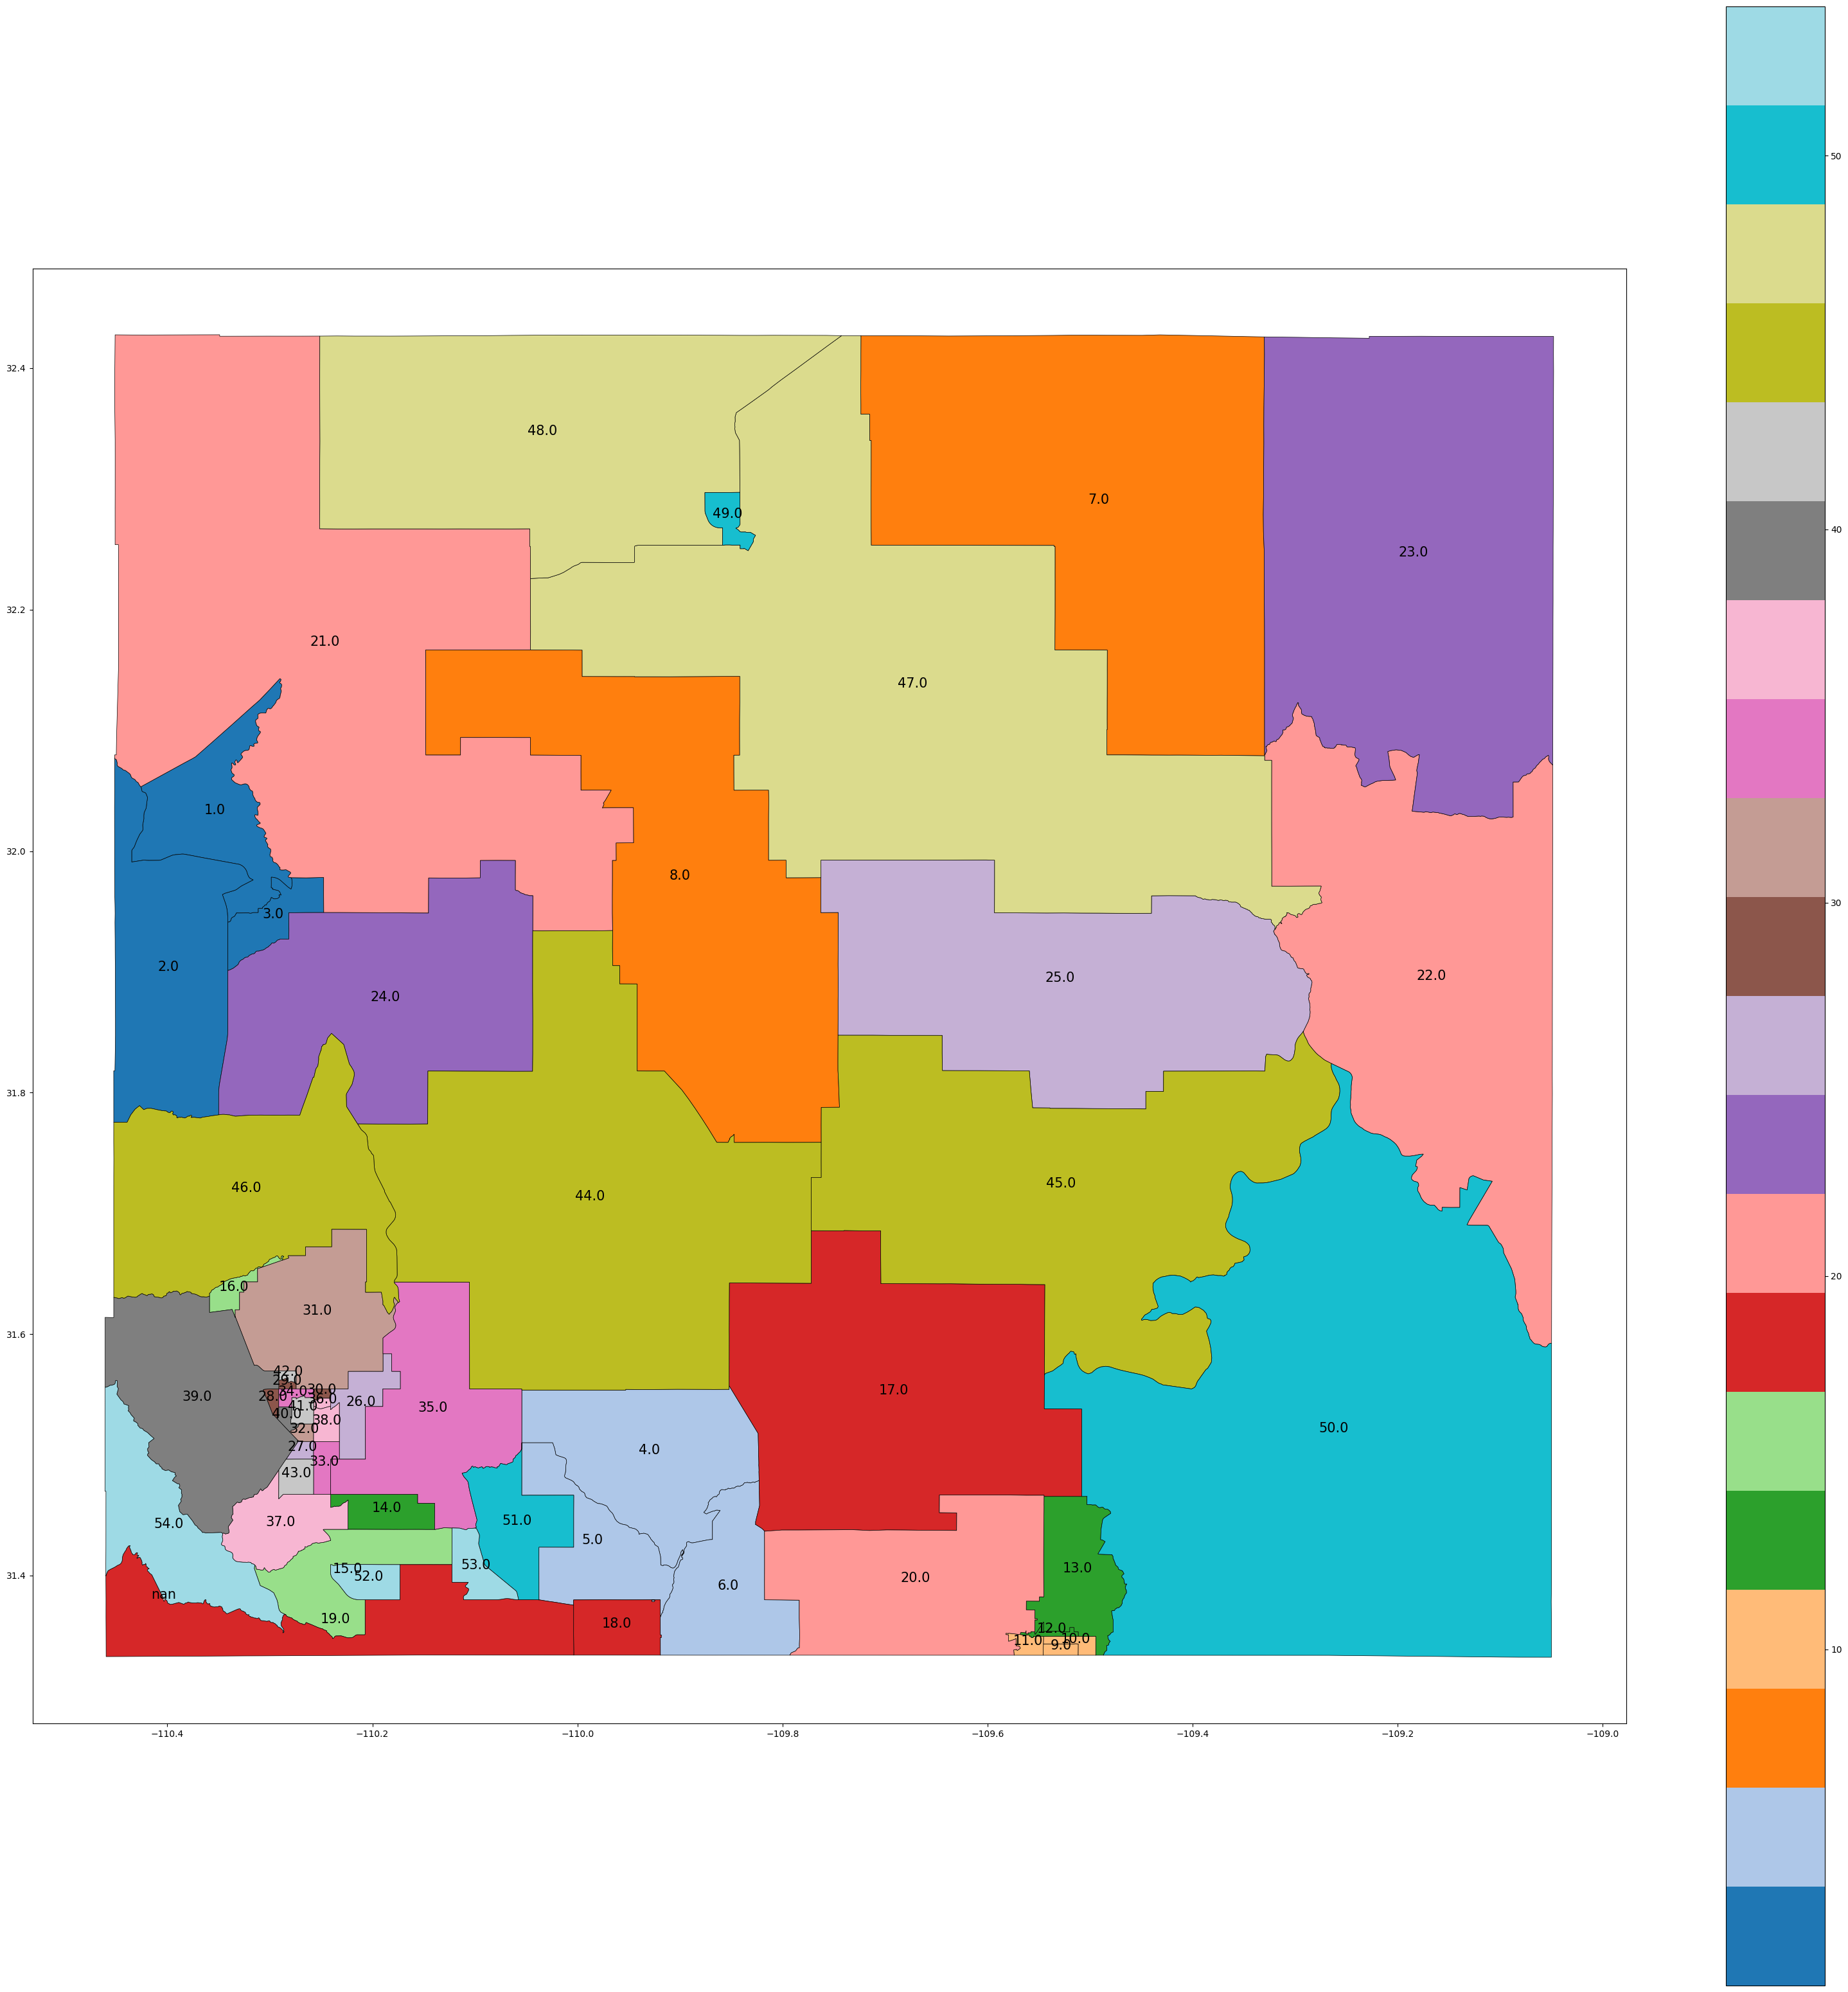

county  precinct  G22ATGDMAY  G22ATGRHAM  ...     prct_name  cd  lg  _merge
0  Cochise       1.0       716.0      1404.0  ...     BE BENSON   6  19    both
1  Cochise       2.0       810.0      2032.0  ...      BE J-SIX   6  19    both
2  Cochise       3.0       908.0      1546.0  ...  BE SAN PEDRO   6  19    both
3  Cochise       4.0      1588.0       368.0  ...     BI BISBEE   7  21    both
4  Cochise       5.0      1068.0       586.0  ...   BI DON LUIS   7  21    both

[5 rows x 270 columns]

In [941]:
# Merge the dataframes
gdf_Cochise_final = cochise_rows.merge(gdf_Cochise[['prct_num', 'geometry', 'prct_name', 'cd', 'lg']], 
                                       left_on='precinct', 
                                       right_on='prct_num', 
                                       how='outer',
                                       indicator=True)

# Drop the duplicate col
# gdf_Cochise_final = gdf_Cochise_final.drop(columns=['prct_num'])
gdf_Cochise_final = gpd.GeoDataFrame(gdf_Cochise_final, geometry='geometry')

plot_precincts_with_labels(gdf_Cochise_final)
gdf_Cochise_final.head(5)

In [942]:
check_precinct_districts(gdf_Cochise_final)


Row 1:
  Column: GUSH06DENG, Office Type: USH, District: 06, Value: 334.0
  Column: GUSH06RCIS, Office Type: USH, District: 06, Value: 724.0
  Column: GUSH06OWRI, Office Type: USH, District: 06, Value: 3.0
  Column: GSL19DCLA, Office Type: SL, District: 19, Value: 329.0
  Column: GSL19OWRI, Office Type: SL, District: 19, Value: 8.0
  Column: GSL19RDIA, Office Type: SL, District: 19, Value: 645.0
  Column: GSL19RGRI, Office Type: SL, District: 19, Value: 683.0
  Column: GSU19OWRI, Office Type: SU, District: 19, Value: 20.0
  Column: GSU19RGOW, Office Type: SU, District: 19, Value: 815.0


Row 2:
  Column: GUSH06DENG, Office Type: USH, District: 06, Value: 362.0
  Column: GUSH06RCIS, Office Type: USH, District: 06, Value: 1072.0
  Column: GUSH06OWRI, Office Type: USH, District: 06, Value: 3.0
  Column: GSL19DCLA, Office Type: SL, District: 19, Value: 383.0
  Column: GSL19OWRI, Office Type: SL, District: 19, Value: 9.0
  Column: GSL19RDIA, Office Type: SL, District: 19, Value: 924.0
  Col

In [943]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Cochise_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          54
right_only     1
left_only      0
Name: count, dtype: int64


In [944]:
gdf_Cochise_final.head(5)

county  precinct  G22ATGDMAY  G22ATGRHAM  ...     prct_name  cd  lg  _merge
0  Cochise       1.0       716.0      1404.0  ...     BE BENSON   6  19    both
1  Cochise       2.0       810.0      2032.0  ...      BE J-SIX   6  19    both
2  Cochise       3.0       908.0      1546.0  ...  BE SAN PEDRO   6  19    both
3  Cochise       4.0      1588.0       368.0  ...     BI BISBEE   7  21    both
4  Cochise       5.0      1068.0       586.0  ...   BI DON LUIS   7  21    both

[5 rows x 270 columns]

In [945]:

gdf_Cochise_final = gdf_Cochise_final.rename(columns={'county': 'COUNTY_NAM'})

gdf_Cochise_final['PCTNUM'] = gdf_Cochise_final['prct_num']
gdf_Cochise_final['PRECINCTNA'] = gdf_Cochise_final['prct_name']
gdf_Cochise_final['UNIQUE_ID'] = gdf_Cochise_final['prct_num'].astype(str) + " " + gdf_Cochise_final['prct_name']
gdf_Cochise_final['CON_DIST'] = gdf_Cochise_final['cd']
gdf_Cochise_final['SLDL_DIST'] = gdf_Cochise_final['lg']
gdf_Cochise_final['SLDU_DIST'] = gdf_Cochise_final['lg']

gdf_Cochise_final.drop(columns=['precinct'], inplace=True)
gdf_Cochise_final.drop(columns=['_merge'], inplace=True)
gdf_Cochise_final.drop(columns=['prct_name'], inplace=True)
gdf_Cochise_final.drop(columns=['prct_num'], inplace=True)
gdf_Cochise_final.drop(columns=['cd'], inplace=True)
gdf_Cochise_final.drop(columns=['lg'], inplace=True)



gdf_Cochise_final['COUNTYFP'] = '003'
gdf_Cochise_final['COUNTY_NAM'] = 'Cochise'


cols = gdf_Cochise_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))
cols.insert(5, cols.pop(cols.index('CON_DIST')))
cols.insert(6, cols.pop(cols.index('SLDL_DIST')))
cols.insert(7, cols.pop(cols.index('SLDU_DIST')))

gdf_Cochise_final = gdf_Cochise_final[cols]



gdf_Cochise_final.head(5)


UNIQUE_ID  ...                                           geometry
0     1 BE BENSON  ...  POLYGON ((-110.27949 31.97802, -110.27925 31.9...
1      2 BE J-SIX  ...  POLYGON ((-110.42593 32.05329, -110.42571 32.0...
2  3 BE SAN PEDRO  ...  POLYGON ((-110.29743 31.96849, -110.29728 31.9...
3     4 BI BISBEE  ...  POLYGON ((-109.82375 31.51770, -109.82375 31.5...
4   5 BI DON LUIS  ...  POLYGON ((-110.03750 31.37986, -110.03751 31.3...

[5 rows x 269 columns]

### Gila County

In [946]:
gila_rows = final_df[final_df['county'].str.lower() == 'gila']

def extract_precinct_name(precinct):
    # Extract the name (everything before the number in parentheses)
    match = re.match(r'^(.*?)(?:\s*\(\d+\))?$', precinct)
    return match.group(1).strip() if match else None

def extract_precinct_num(precinct):
    # Extract the number inside the parentheses
    match = re.search(r'\((\d+)\)', precinct)
    return match.group(1) if match else None

# Apply the functions to create the new columns
gila_rows['PRECINCTNA'] = gila_rows['precinct'].apply(extract_precinct_name)
gila_rows['PCTNUM'] = gila_rows['precinct'].apply(extract_precinct_num)
gila_rows['UNIQUE_ID'] = gila_rows['precinct']
gila_rows.head(5)


county               precinct  ...  PCTNUM              UNIQUE_ID
241   Gila       Canyon Day (400)  ...     400       Canyon Day (400)
242   Gila          Carrizo (405)  ...     405          Carrizo (405)
243   Gila  Central Heights (175)  ...     175  Central Heights (175)
244   Gila      Claypool #1 (160)  ...     160      Claypool #1 (160)
245   Gila      Claypool #2 (165)  ...     165      Claypool #2 (165)

[5 rows x 265 columns]

In [947]:
gila_rows['precinct'] = remove_special_characters(gila_rows['precinct'])
def clean_precinct(precinct):
    precinct = precinct.replace(' ', '')
    precinct = precinct[:-3]
    return precinct

gila_rows['precinct'] = gila_rows['precinct'].apply(lambda x: clean_precinct(x))
sorted(gila_rows['precinct'])

mapping = {
   'MiamiNo1': 'Miami1',
   'MiamiNo3': 'Miami3'
}

# Replace old candidate names with new names
gila_rows['precinct'] = gila_rows['precinct'].replace(mapping)
gila_rows


county         precinct  ...  PCTNUM               UNIQUE_ID
241   Gila        CanyonDay  ...     400        Canyon Day (400)
242   Gila          Carrizo  ...     405           Carrizo (405)
243   Gila   CentralHeights  ...     175   Central Heights (175)
244   Gila        Claypool1  ...     160       Claypool #1 (160)
245   Gila        Claypool2  ...     165       Claypool #2 (165)
246   Gila        Claypool3  ...     170       Claypool #3 (170)
247   Gila      CopperBasin  ...     300      Copper Basin (300)
248   Gila        EastGlobe  ...     140        East Globe (140)
249   Gila           Gisela  ...     305            Gisela (305)
..     ...              ...  ...     ...                     ...
271   Gila        Roosevelt  ...     320         Roosevelt (320)
272   Gila        SanCarlos  ...     410        San Carlos (410)
273   Gila      SierraAncha  ...     325      Sierra Ancha (325)
274   Gila       StarValley  ...     240       Star Valley (240)
275   Gila       TontoBasin  ...     330       Tonto Basin (330)
276   Gila      Wheatfields  ...     185       Wheatfields (185)
277   Gila  WhisperingPines  ...     335  Whispering Pines (335)
278   Gila            Young  ...     340             Young (340)
279   Gila         ZaneGrey  ...     345         Zane Grey (345)

[39 rows x 265 columns]

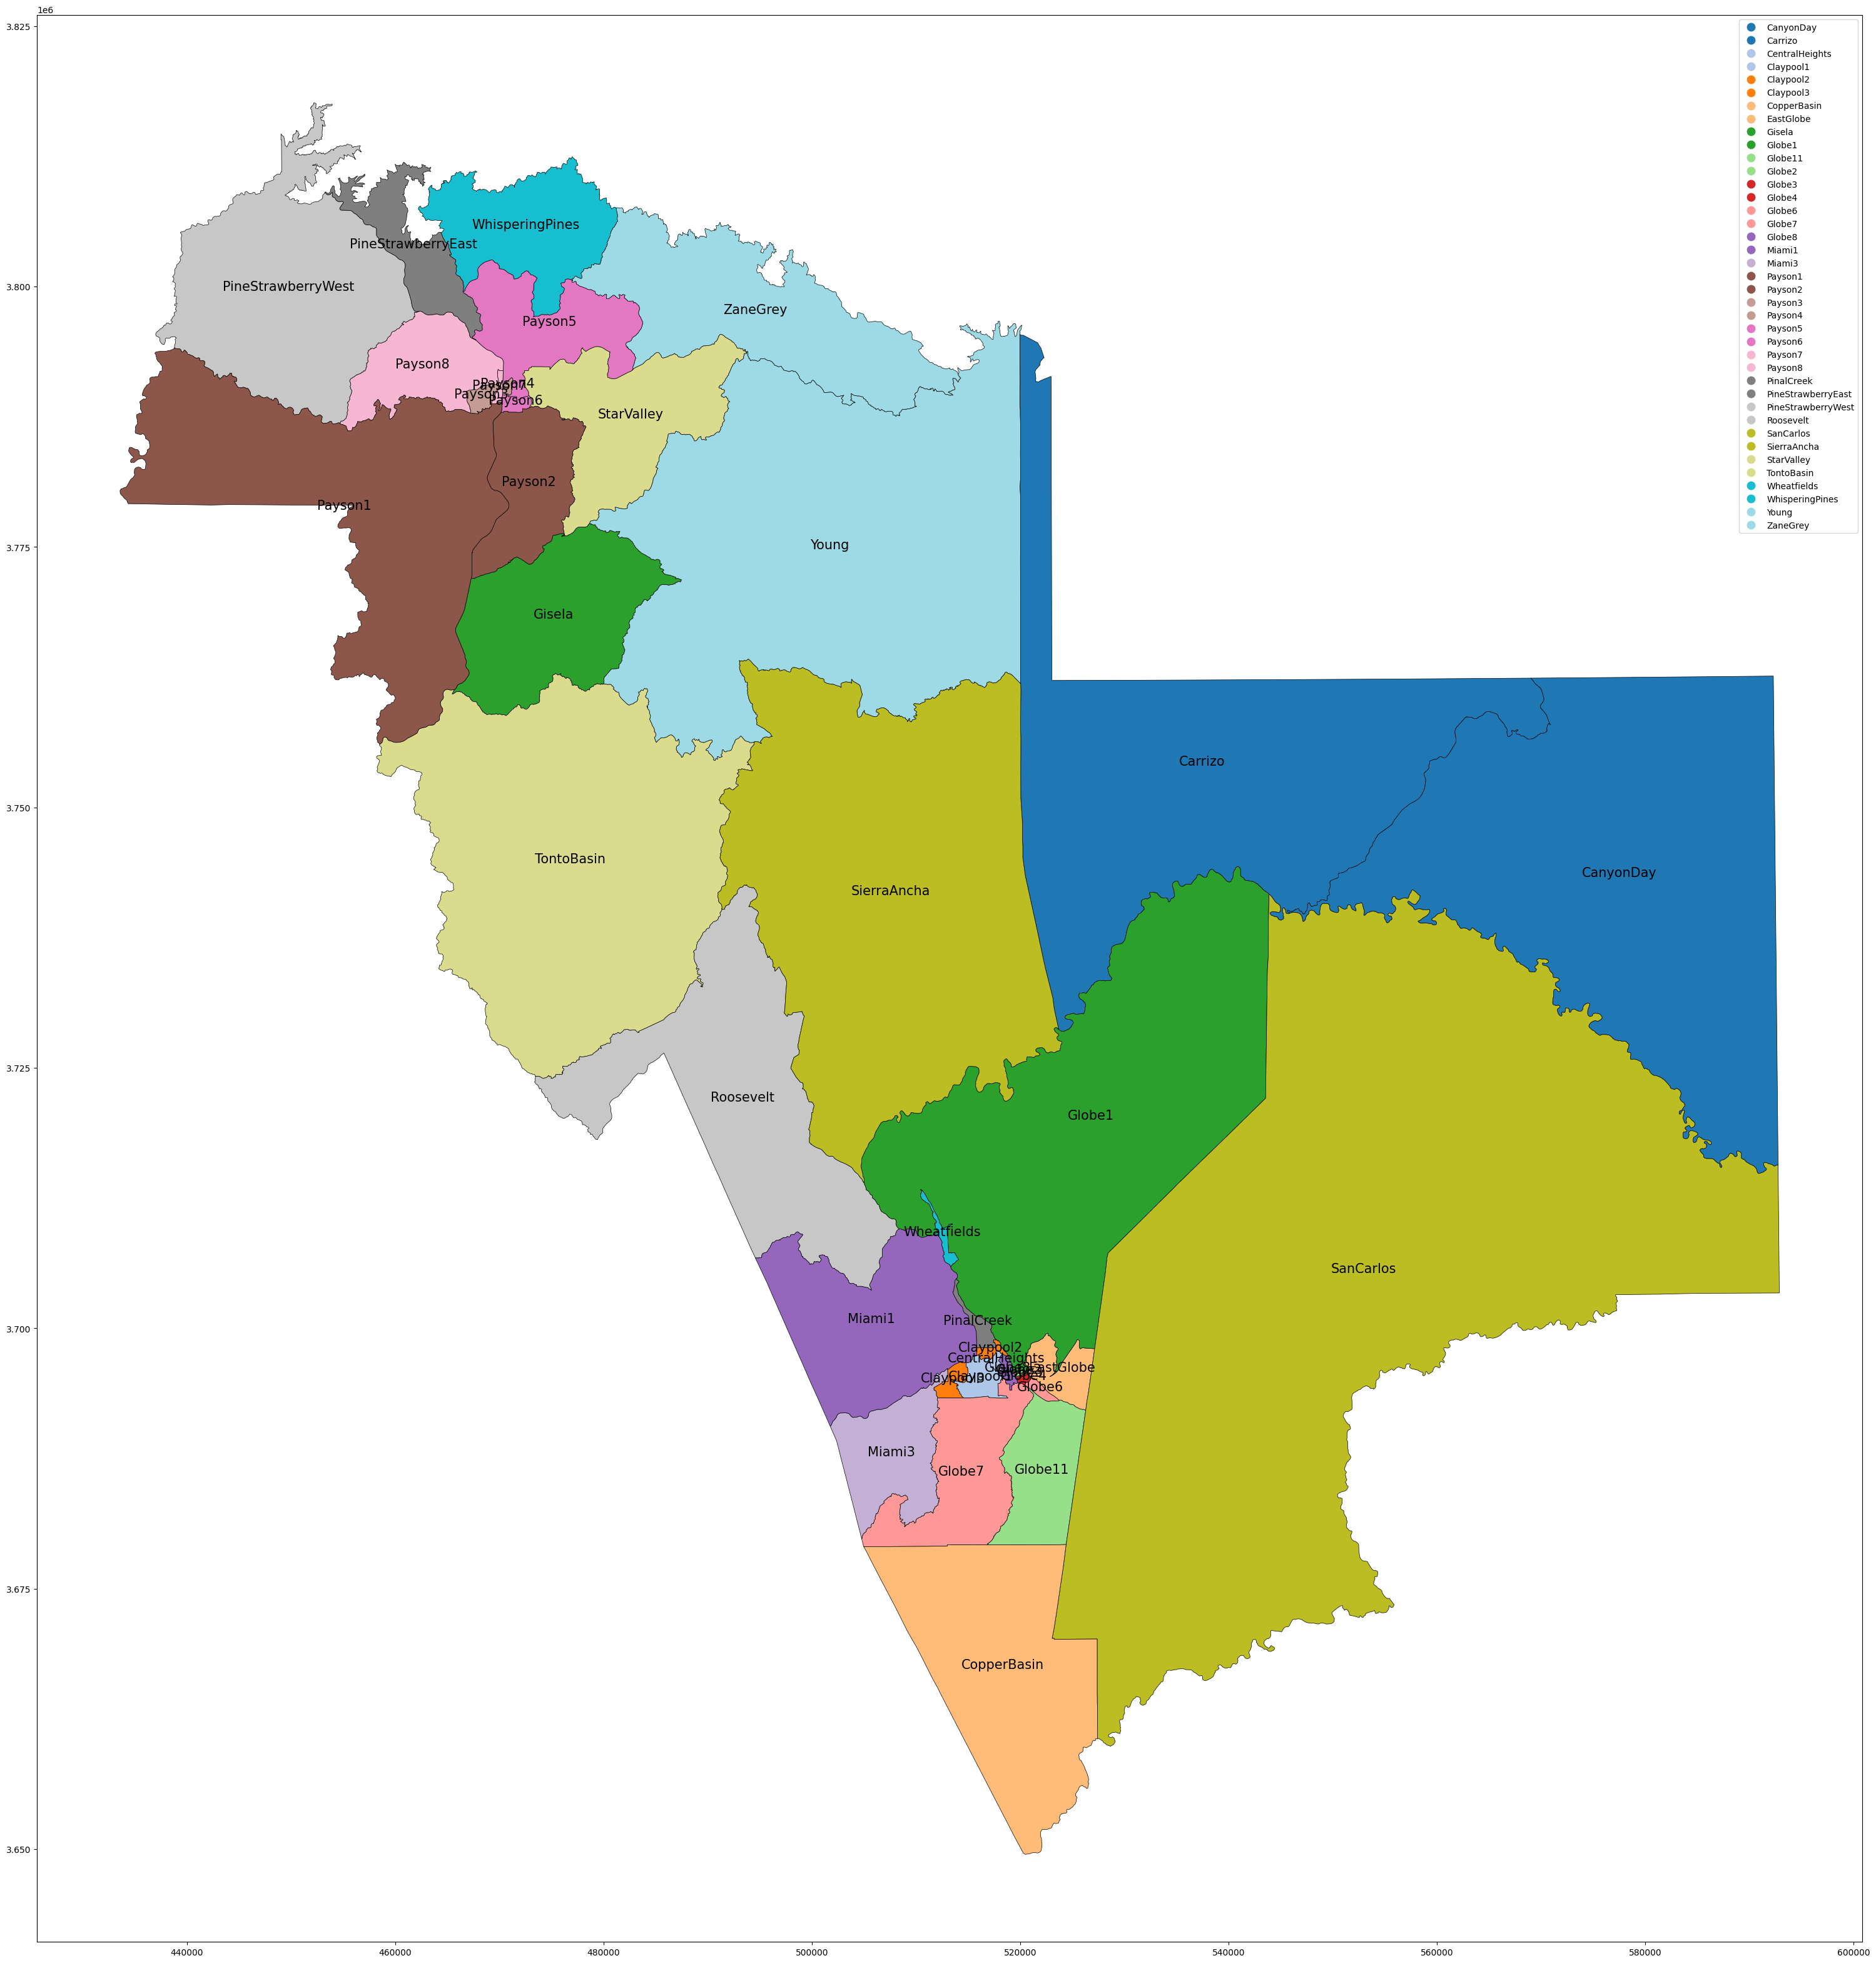

In [948]:
# Read the shapefile
shapefile_path_Gila = './precinct_boundaries/Gela/GilaPrecincts_Dec2022.shp'
gdf_Gila = gpd.read_file(shapefile_path_Gila)
gdf_Gila['NAME20'] = remove_special_characters(gdf_Gila['NAME20'])
gdf_Gila['NAME20'] = gdf_Gila['NAME20'].str.replace(' ', '')
gdf_Gila['NAME20']
plot_precincts(gdf_Gila,'NAME20')

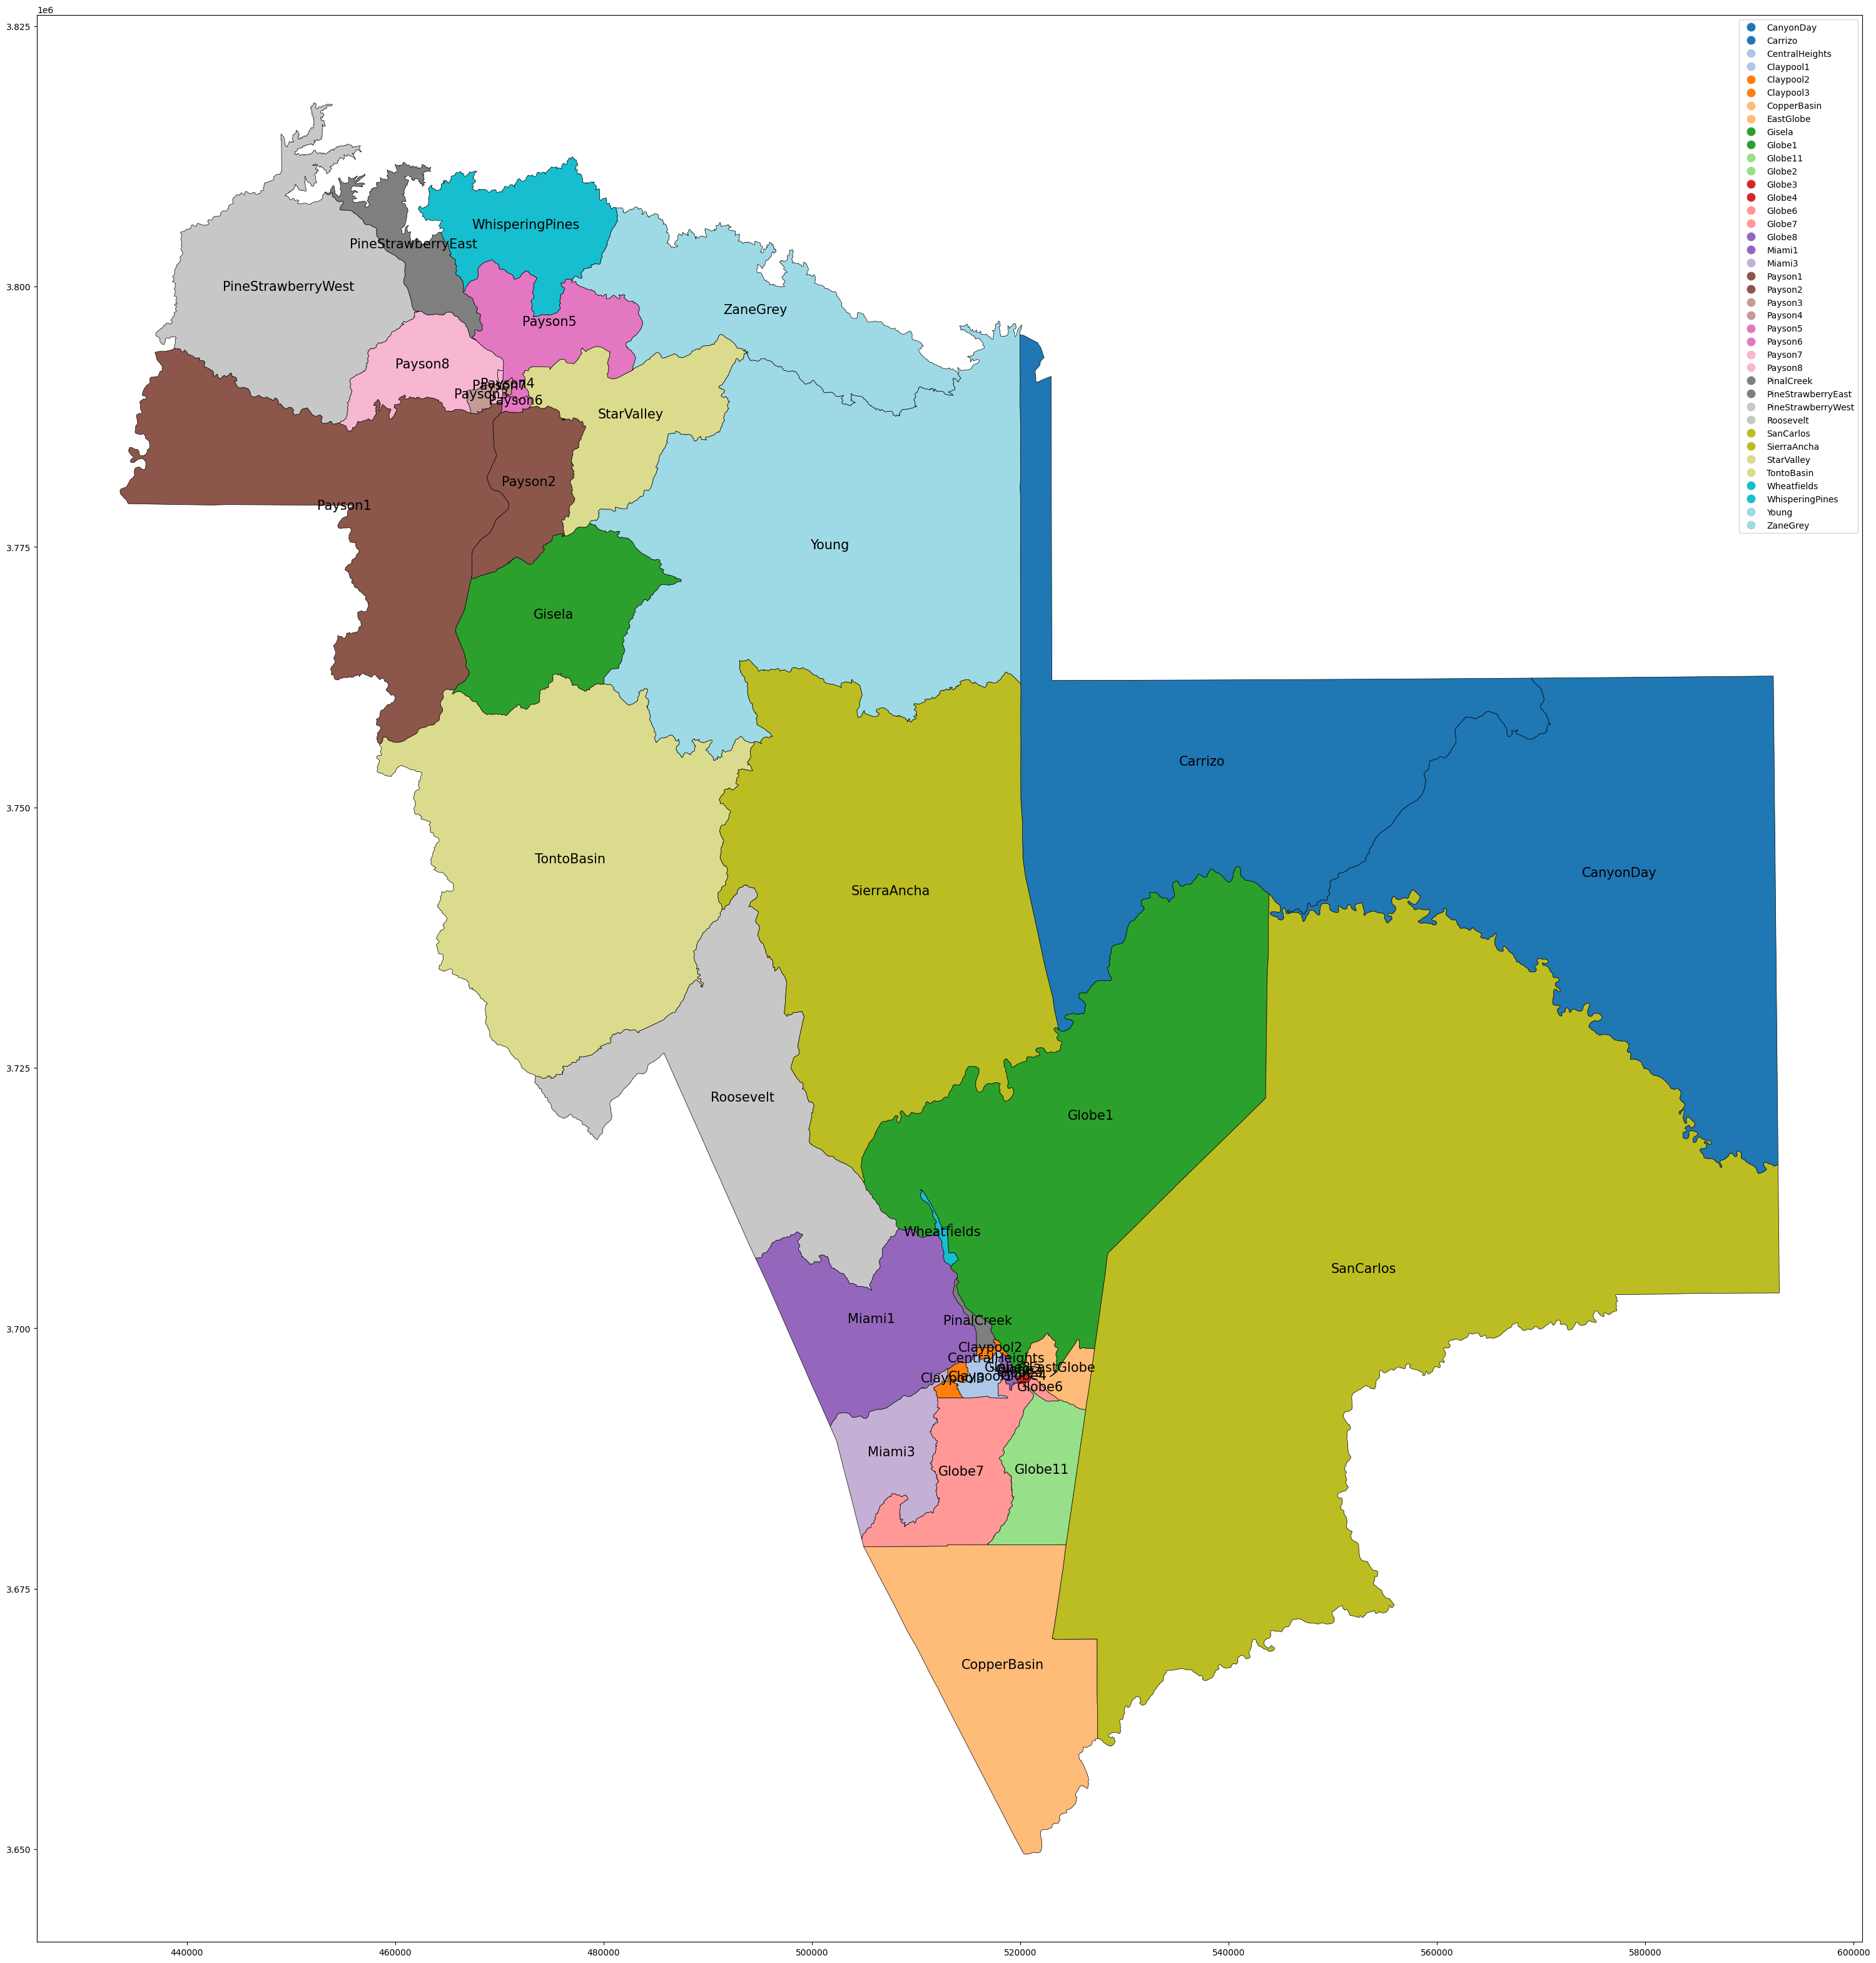

In [949]:
# Merge the dataframes
gdf_Gila_final = gila_rows.merge(gdf_Gila[['NAME20', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='NAME20', 
                                       how='outer',
                                       indicator = True)

# Drop the duplicate col
gdf_Gila_final = gdf_Gila_final.drop(columns=['NAME20'])
gdf_Gila_final = gpd.GeoDataFrame(gdf_Gila_final, geometry='geometry')

plot_precincts_with_labels(gdf_Gila_final)

In [950]:
check_precinct_districts(gdf_Gila_final)


Row 1:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 257.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 15.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 190.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 211.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 2.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 259.0
  Column: GSU06OWRI, Office Type: SU, District: 06, Value: 1.0


Row 2:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 21.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 3.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 13.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 19.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 23.0


Row 3:
  Column: GSL07OWRI, Office Type: SL, District: 07, Value: 4.0
  Column: GSL07RCOO, Office Type: SL, District: 07, Value: 143.0
  Column: GSL07RSR., Office Type: SL, District: 07, Value: 129.0
  Col

In [951]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Gila_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          39
left_only      0
right_only     0
Name: count, dtype: int64


In [952]:

gdf_Gila_final = gdf_Gila_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Gila_final.drop(columns=['precinct'], inplace=True)
gdf_Gila_final.drop(columns=['_merge'], inplace=True)


gdf_Gila_final['COUNTYFP'] = '007'


cols = gdf_Gila_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Gila_final = gdf_Gila_final[cols]

gdf_Gila_final = add_districts_numbers(gdf_Gila_final)


gdf_Gila_final.head(5)


UNIQUE_ID  ...                                           geometry
0       Canyon Day (400)  ...  POLYGON ((584935.348 3718075.276, 584934.717 3...
1          Carrizo (405)  ...  POLYGON ((520033.609 3761861.735, 520032.056 3...
2  Central Heights (175)  ...  POLYGON ((518111.566 3696466.450, 518104.791 3...
3      Claypool #1 (160)  ...  POLYGON ((518458.401 3693294.846, 518399.616 3...
4      Claypool #2 (165)  ...  POLYGON ((515813.888 3698132.648, 516202.913 3...

[5 rows x 269 columns]

## Graham County

In [953]:
geojson_file_Graham = './precinct_boundaries/Graham.geojson'
gdf_Graham = gpd.read_file(geojson_file_Graham)
if len(gdf_Graham) != 22:
    raise ValueError("The GeoDataFrame must have exactly 22 rows.")

# Assign values from 1 to 22 to the 'name' column
gdf_Graham['NAME'] = range(1, 23)
gdf_Graham

NAME                                           geometry
0      1  POLYGON ((-109.66258 32.42690, -109.66277 32.4...
1      2  POLYGON ((-109.59269 32.99641, -109.59255 32.9...
2      3  POLYGON ((-109.55933 33.05135, -109.55917 33.0...
3      4  POLYGON ((-109.68192 32.80205, -109.68629 32.8...
4      5  POLYGON ((-109.66423 33.01452, -109.66474 33.0...
5      6  POLYGON ((-109.76912 32.84913, -109.76895 32.8...
6      7  POLYGON ((-109.77388 32.88395, -109.77384 32.8...
7      8  POLYGON ((-110.19359 32.70299, -110.19364 32.7...
8      9  POLYGON ((-109.90973 33.16267, -109.91065 33.1...
..   ...                                                ...
13    14  POLYGON ((-109.49568 33.65283, -109.49552 33.6...
14    15  POLYGON ((-109.82829 32.82195, -109.82833 32.8...
15    16  POLYGON ((-109.76285 32.80761, -109.76285 32.8...
16    17  POLYGON ((-109.72236 32.80240, -109.72146 32.8...
17    18  POLYGON ((-109.72055 32.72271, -109.72054 32.7...
18    19  POLYGON ((-109.70781 32.70373, -109.70781 32.7...
19    20  POLYGON ((-109.69536 32.84470, -109.69886 32.8...
20    21  POLYGON ((-109.73298 32.81664, -109.73298 32.8...
21    22  POLYGON ((-110.43683 33.16253, -110.43651 33.1...

[22 rows x 2 columns]

In [954]:
graham_rows = final_df[final_df['county'].str.lower() == 'graham']

def extract_precinct_name(precinct):
    # Extract the name (everything before the # and number)
    match = re.match(r'^(.*?)(?:\s*#\d+)?$', precinct)
    return match.group(1).strip() if match else None

def extract_precinct_num(precinct):
    # Extract the number after the # symbol
    match = re.search(r'#(\d+)', precinct)
    return match.group(1) if match else None

# Apply the functions to create the new columns
graham_rows['PCTNUM'] = graham_rows['precinct'].apply(extract_precinct_num)
graham_rows['PRECINCTNA'] = graham_rows['precinct'].apply(extract_precinct_name)
graham_rows

county           precinct  G22ATGDMAY  ...  G22USSWROX  PCTNUM     PRECINCTNA
1612  Graham         Solomon #1       196.0  ...         NaN       1        Solomon
1613  Graham         Safford #2       304.0  ...         NaN       2        Safford
1614  Graham         Safford #3       125.0  ...         NaN       3        Safford
1615  Graham          Layton #4       147.0  ...         NaN       4         Layton
1616  Graham          Layton #5       252.0  ...         NaN       5         Layton
1617  Graham        Thatcher #6        86.0  ...         NaN       6       Thatcher
1618  Graham        Thatcher #7       269.0  ...         NaN       7       Thatcher
1619  Graham         Central #8        45.0  ...         NaN       8        Central
1620  Graham            Pima #9       275.0  ...         NaN       9           Pima
...      ...                ...         ...  ...         ...     ...            ...
1625  Graham    Thunderbird #14        44.0  ...         NaN      14    Thunderbird
1626  Graham        Safford #15       350.0  ...         NaN      15        Safford
1627  Graham        Peridot #16       222.0  ...         NaN      16        Peridot
1628  Graham         Cactus #17        43.0  ...         NaN      17         Cactus
1629  Graham        Jackson #18       157.0  ...         NaN      18        Jackson
1630  Graham   Desert Hills #19       136.0  ...         NaN      19   Desert Hills
1631  Graham        Artesia #20        94.0  ...         NaN      20        Artesia
1632  Graham  Quatro Cerros #21        16.0  ...         NaN      21  Quatro Cerros
1633  Graham     Gila River #22         9.0  ...         NaN      22     Gila River

[22 rows x 264 columns]

In [955]:
# graham_rows = final_df[final_df['county'].str.lower() == 'graham']
graham_rows['UNIQUE_ID'] = graham_rows['precinct']
graham_rows['precinct'] = graham_rows['precinct'].str.extract('(\d+)')[0].astype(int)
graham_rows

county  precinct  G22ATGDMAY  ...  PCTNUM     PRECINCTNA          UNIQUE_ID
1612  Graham         1       196.0  ...       1        Solomon         Solomon #1
1613  Graham         2       304.0  ...       2        Safford         Safford #2
1614  Graham         3       125.0  ...       3        Safford         Safford #3
1615  Graham         4       147.0  ...       4         Layton          Layton #4
1616  Graham         5       252.0  ...       5         Layton          Layton #5
1617  Graham         6        86.0  ...       6       Thatcher        Thatcher #6
1618  Graham         7       269.0  ...       7       Thatcher        Thatcher #7
1619  Graham         8        45.0  ...       8        Central         Central #8
1620  Graham         9       275.0  ...       9           Pima            Pima #9
...      ...       ...         ...  ...     ...            ...                ...
1625  Graham        14        44.0  ...      14    Thunderbird    Thunderbird #14
1626  Graham        15       350.0  ...      15        Safford        Safford #15
1627  Graham        16       222.0  ...      16        Peridot        Peridot #16
1628  Graham        17        43.0  ...      17         Cactus         Cactus #17
1629  Graham        18       157.0  ...      18        Jackson        Jackson #18
1630  Graham        19       136.0  ...      19   Desert Hills   Desert Hills #19
1631  Graham        20        94.0  ...      20        Artesia        Artesia #20
1632  Graham        21        16.0  ...      21  Quatro Cerros  Quatro Cerros #21
1633  Graham        22         9.0  ...      22     Gila River     Gila River #22

[22 rows x 265 columns]

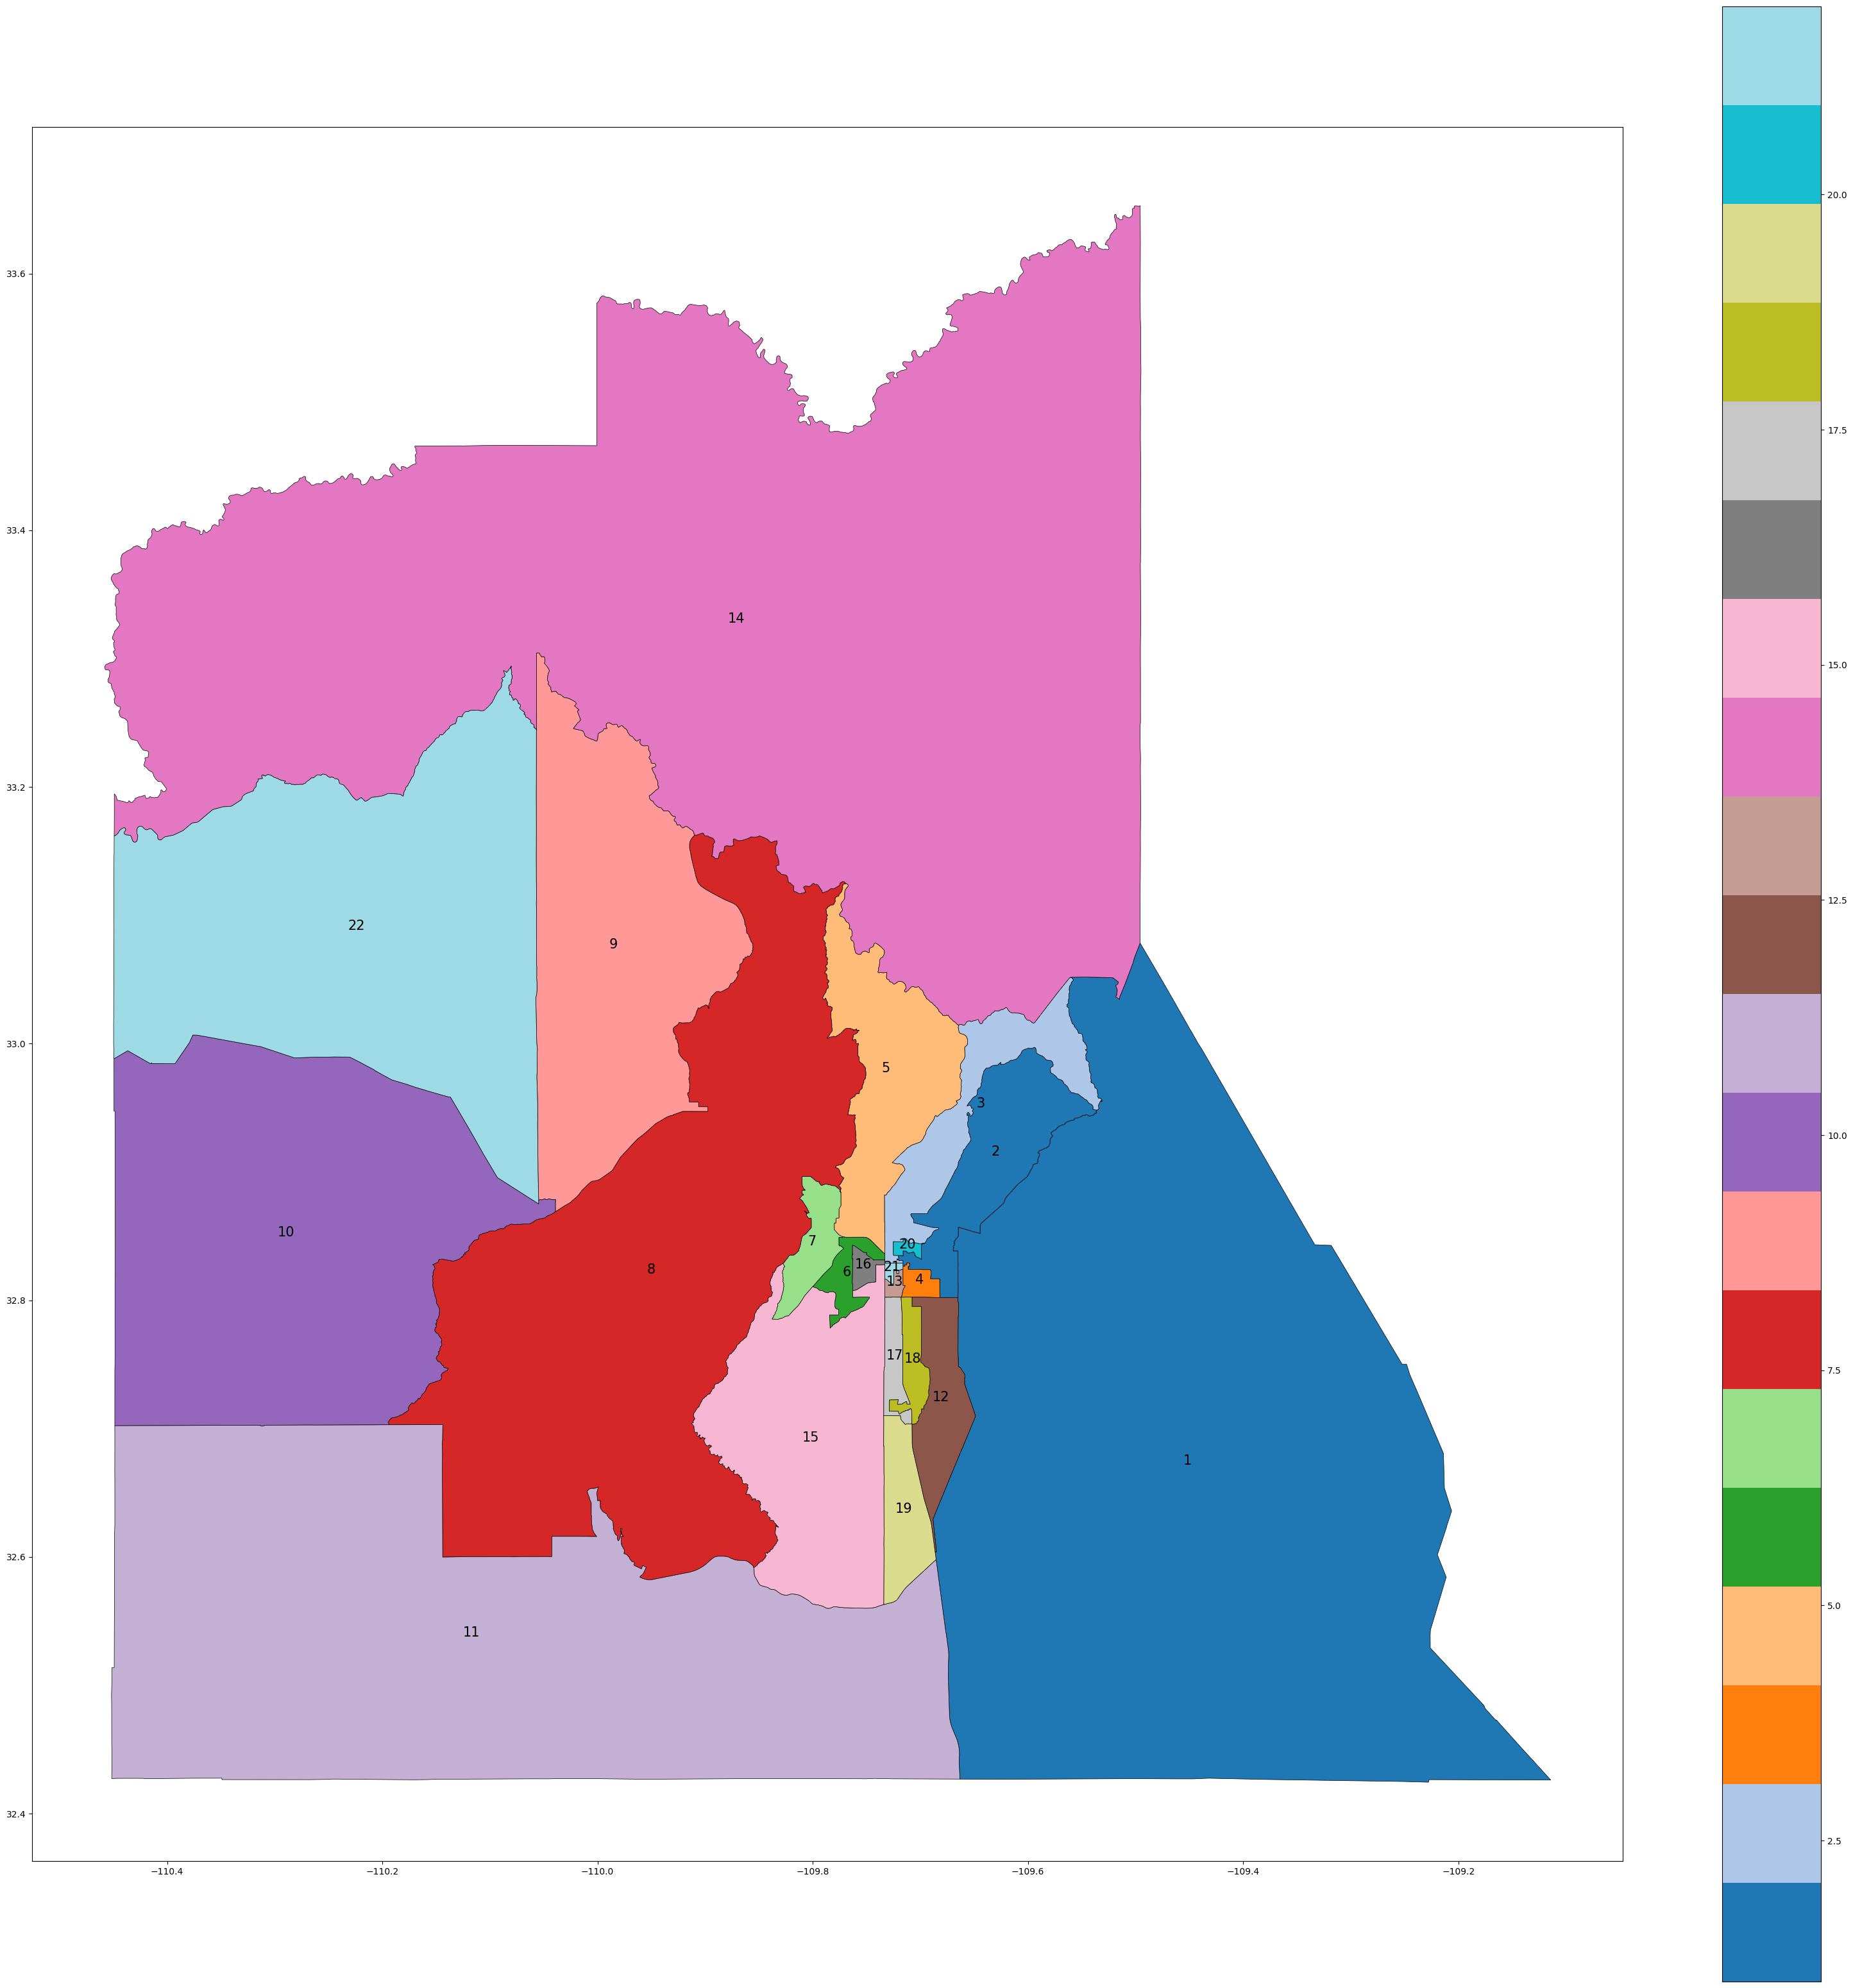

In [956]:
# Merge the dataframes
gdf_Graham_final = graham_rows.merge(gdf_Graham[['NAME', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='NAME', 
                                       how='outer',
                                       indicator=True)

# Drop the duplicate col
gdf_Graham_final = gdf_Graham_final.drop(columns=['NAME'])

gdf_Graham_final = gpd.GeoDataFrame(gdf_Graham_final, geometry='geometry')

plot_precincts_with_labels(gdf_Graham_final)

In [957]:
check_precinct_districts(gdf_Graham_final)


Row 1:
  Column: GUSH06DENG, Office Type: USH, District: 06, Value: 180.0
  Column: GUSH06RCIS, Office Type: USH, District: 06, Value: 417.0
  Column: GSL19DCLA, Office Type: SL, District: 19, Value: 190.0
  Column: GSL19RDIA, Office Type: SL, District: 19, Value: 344.0
  Column: GSL19RGRI, Office Type: SL, District: 19, Value: 357.0
  Column: GSU19OWRI, Office Type: SU, District: 19, Value: 8.0
  Column: GSU19RGOW, Office Type: SU, District: 19, Value: 473.0


Row 2:
  Column: GUSH06DENG, Office Type: USH, District: 06, Value: 274.0
  Column: GUSH06RCIS, Office Type: USH, District: 06, Value: 564.0
  Column: GSL19DCLA, Office Type: SL, District: 19, Value: 294.0
  Column: GSL19OWRI, Office Type: SL, District: 19, Value: 2.0
  Column: GSL19RDIA, Office Type: SL, District: 19, Value: 430.0
  Column: GSL19RGRI, Office Type: SL, District: 19, Value: 507.0
  Column: GSU19OWRI, Office Type: SU, District: 19, Value: 15.0
  Column: GSU19RGOW, Office Type: SU, District: 19, Value: 664.0


Row 

In [958]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Graham_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          22
left_only      0
right_only     0
Name: count, dtype: int64


In [959]:

gdf_Graham_final = gdf_Graham_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Graham_final.drop(columns=['precinct'], inplace=True)
gdf_Graham_final.drop(columns=['_merge'], inplace=True)


gdf_Graham_final['COUNTYFP'] = '009'


cols = gdf_Graham_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Graham_final = gdf_Graham_final[cols]

gdf_Graham_final = add_districts_numbers(gdf_Graham_final)


gdf_Graham_final.head(5)


UNIQUE_ID  ...                                           geometry
0  Solomon #1  ...  POLYGON ((-109.66258 32.42690, -109.66277 32.4...
1  Safford #2  ...  POLYGON ((-109.59269 32.99641, -109.59255 32.9...
2  Safford #3  ...  POLYGON ((-109.55933 33.05135, -109.55917 33.0...
3   Layton #4  ...  POLYGON ((-109.68192 32.80205, -109.68629 32.8...
4   Layton #5  ...  POLYGON ((-109.66423 33.01452, -109.66474 33.0...

[5 rows x 269 columns]

## Greenlee County
Using 2020 boundaries(2022 boundaries provided are school districts not precinct)

In [960]:
greenlee_rows = final_df[final_df['county'].str.lower() == 'greenlee']
def extract_precinct_num(precinct):
    # Extract the numeric part at the beginning
    match = re.match(r'^\d+', precinct)
    return match.group(0) if match else None

def extract_precinct_name(precinct):
    # Extract the name part after the number
    match = re.match(r'^\d+\s+(.*)$', precinct)
    return match.group(1).strip() if match else None

# Apply the functions to create the new columns
greenlee_rows['PCTNUM'] = greenlee_rows['precinct'].apply(extract_precinct_num)
# greenlee_rows['PRECINCTNA'] = greenlee_rows['precinct'].apply(extract_precinct_name)
greenlee_rows['UNIQUE_ID'] = greenlee_rows['precinct']


greenlee_rows

county            precinct  ...  PCTNUM           UNIQUE_ID
280  Greenlee            002 Blue  ...     002            002 Blue
281  Greenlee       003 Clifton 1  ...     003       003 Clifton 1
282  Greenlee       004 Clifton 2  ...     004       004 Clifton 2
283  Greenlee         005 Morenci  ...     005         005 Morenci
284  Greenlee  006 East Plantsite  ...     006  006 East Plantsite
285  Greenlee    007 York/Sheldon  ...     007    007 York/Sheldon
286  Greenlee          008 Duncan  ...     008          008 Duncan
287  Greenlee           001 Eagle  ...     001           001 Eagle

[8 rows x 264 columns]

In [961]:
greenlee_rows['precinct'] = greenlee_rows['precinct'].str[4:].str.upper()
greenlee_rows['precinct'] = remove_special_characters(greenlee_rows['precinct'])


In [962]:
greenlee_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Greenlee']
print(greenlee_2020)

                                               geometry  ... SLDU_DIST
1478  POLYGON ((-109.19025 33.20995, -109.18937 33.2...  ...        14
1479  POLYGON ((-109.22429 32.70130, -109.22429 32.7...  ...        14
1480  POLYGON ((-109.23301 32.71849, -109.23936 32.7...  ...        14
1481  POLYGON ((-109.41245 32.97681, -109.42544 32.9...  ...        14
1482  POLYGON ((-109.49558 33.58165, -109.49560 33.5...  ...        14
1483  POLYGON ((-109.04751 33.10739, -109.04755 33.1...  ...        14
1484  POLYGON ((-109.27632 33.13312, -109.27637 33.1...  ...        14
1485  POLYGON ((-109.31894 33.05199, -109.31855 33.0...  ...        14

[8 rows x 10 columns]


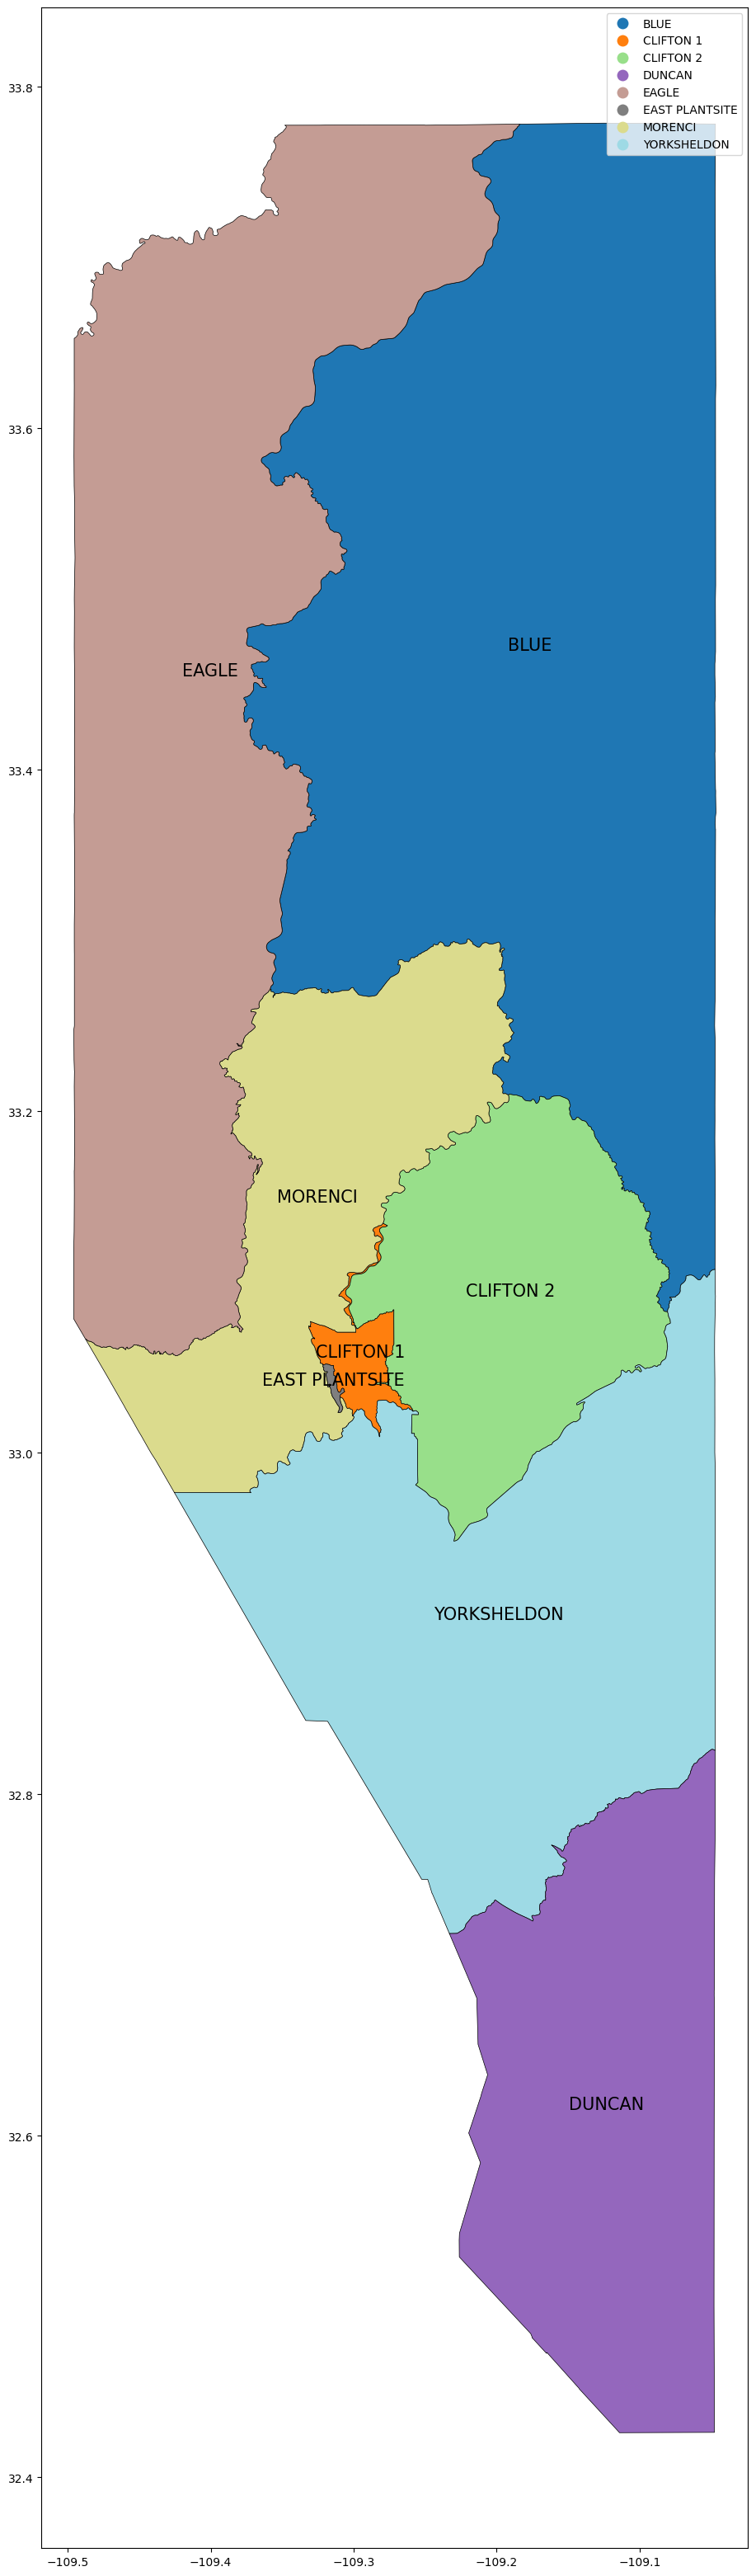

In [963]:
# Merge the dataframes
gdf_Greenlee_final = greenlee_rows.merge(greenlee_2020[['PRECINCTNA', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='PRECINCTNA', 
                                       how='outer',
                                       indicator=True)

# Drop the duplicate col
# gdf_Greenlee_final = gdf_Greenlee_final.drop(columns=['PRECINCTNA'])

gdf_Greenlee_final = gpd.GeoDataFrame(gdf_Greenlee_final, geometry='geometry')

plot_precincts_with_labels(gdf_Greenlee_final)

In [964]:
check_precinct_districts(gdf_Greenlee_final)


Row 1:
  Column: GUSH06DENG, Office Type: USH, District: 06, Value: 4.0
  Column: GUSH06RCIS, Office Type: USH, District: 06, Value: 28.0
  Column: GSL19DCLA, Office Type: SL, District: 19, Value: 4.0
  Column: GSL19RDIA, Office Type: SL, District: 19, Value: 23.0
  Column: GSL19RGRI, Office Type: SL, District: 19, Value: 30.0
  Column: GSU19RGOW, Office Type: SU, District: 19, Value: 30.0


Row 2:
  Column: GUSH06DENG, Office Type: USH, District: 06, Value: 232.0
  Column: GUSH06RCIS, Office Type: USH, District: 06, Value: 224.0
  Column: GSL19DCLA, Office Type: SL, District: 19, Value: 236.0
  Column: GSL19OWRI, Office Type: SL, District: 19, Value: 5.0
  Column: GSL19RDIA, Office Type: SL, District: 19, Value: 223.0
  Column: GSL19RGRI, Office Type: SL, District: 19, Value: 199.0
  Column: GSU19OWRI, Office Type: SU, District: 19, Value: 4.0
  Column: GSU19RGOW, Office Type: SU, District: 19, Value: 302.0


Row 3:
  Column: GUSH06DENG, Office Type: USH, District: 06, Value: 177.0
  

In [965]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Greenlee_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          8
left_only     0
right_only    0
Name: count, dtype: int64


In [966]:
gdf_Greenlee_final

county  ... _merge
0  Greenlee  ...   both
1  Greenlee  ...   both
2  Greenlee  ...   both
3  Greenlee  ...   both
4  Greenlee  ...   both
5  Greenlee  ...   both
6  Greenlee  ...   both
7  Greenlee  ...   both

[8 rows x 267 columns]

In [967]:

gdf_Greenlee_final = gdf_Greenlee_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Greenlee_final.drop(columns=['precinct'], inplace=True)
gdf_Greenlee_final.drop(columns=['_merge'], inplace=True)


gdf_Greenlee_final['COUNTYFP'] = '011'


cols = gdf_Greenlee_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Greenlee_final = gdf_Greenlee_final[cols]

gdf_Greenlee_final = add_districts_numbers(gdf_Greenlee_final)


gdf_Greenlee_final.head(5)


UNIQUE_ID  ...                                           geometry
0            002 Blue  ...  POLYGON ((-109.04751 33.10739, -109.04755 33.1...
1       003 Clifton 1  ...  POLYGON ((-109.27632 33.13312, -109.27637 33.1...
2       004 Clifton 2  ...  POLYGON ((-109.19025 33.20995, -109.18937 33.2...
3         005 Morenci  ...  POLYGON ((-109.41245 32.97681, -109.42544 32.9...
4  006 East Plantsite  ...  POLYGON ((-109.31894 33.05199, -109.31855 33.0...

[5 rows x 269 columns]

### La Paz County
Using 2020 boundaries

In [968]:
la_paz_rows = final_df[final_df['county'].str.lower() == 'la paz']
def extract_precinct_num(precinct):
    # Extract the numeric part at the beginning
    match = re.match(r'^\d+', precinct)
    return match.group(0) if match else None

def extract_precinct_name(precinct):
    # Extract the name part after the number
    match = re.match(r'^\d+\s+(.*)$', precinct)
    return match.group(1).strip() if match else None

# Apply the functions to create the new columns
la_paz_rows['PCTNUM'] = la_paz_rows['precinct'].apply(extract_precinct_num)
la_paz_rows['PRECINCTNA'] = la_paz_rows['precinct'].apply(extract_precinct_name)
la_paz_rows['precinct'] = la_paz_rows['precinct'].str.upper()

la_paz_rows

county              precinct  ...  PCTNUM        PRECINCTNA
288  La Paz            051 PARKER  ...     051            Parker
289  La Paz            052 POSTON  ...     052            Poston
290  La Paz           054 UPRIVER  ...     054           Upriver
291  La Paz             055 BOUSE  ...     055             Bouse
292  La Paz            056 WENDEN  ...     056            Wenden
293  La Paz            057 SALOME  ...     057            Salome
294  La Paz    058 QUARTZSITE TWO  ...     058    Quartzsite Two
295  La Paz            059 CIBOLA  ...     059            Cibola
296  La Paz         060 EHRENBERG  ...     060         Ehrenberg
297  La Paz         062 VICKSBURG  ...     062         Vicksburg
298  La Paz  064 QUARTZSITE THREE  ...     064  Quartzsite Three

[11 rows x 264 columns]

In [969]:
la_paz_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'La Paz']
la_paz_2020

geometry  ... SLDU_DIST
98    POLYGON ((-114.34848 33.78091, -114.34849 33.7...  ...        05
99    POLYGON ((-113.84995 34.24601, -113.84995 34.2...  ...        05
100   POLYGON ((-113.42871 33.37691, -113.42871 33.3...  ...        05
101   POLYGON ((-114.39615 33.02750, -114.39665 33.0...  ...        05
102   POLYGON ((-113.66154 34.21469, -113.66146 34.2...  ...        05
186   POLYGON ((-114.36410 33.64851, -114.36271 33.6...  ...        05
345   POLYGON ((-114.43435 34.08650, -114.43418 34.0...  ...        05
346   POLYGON ((-113.66555 34.07020, -113.66566 34.0...  ...        05
347   POLYGON ((-114.36264 33.68022, -114.36177 33.6...  ...        05
348   POLYGON ((-114.51575 33.02762, -114.51645 33.0...  ...        05
1474  POLYGON ((-113.33337 33.99992, -113.33375 33.9...  ...        05

[11 rows x 10 columns]

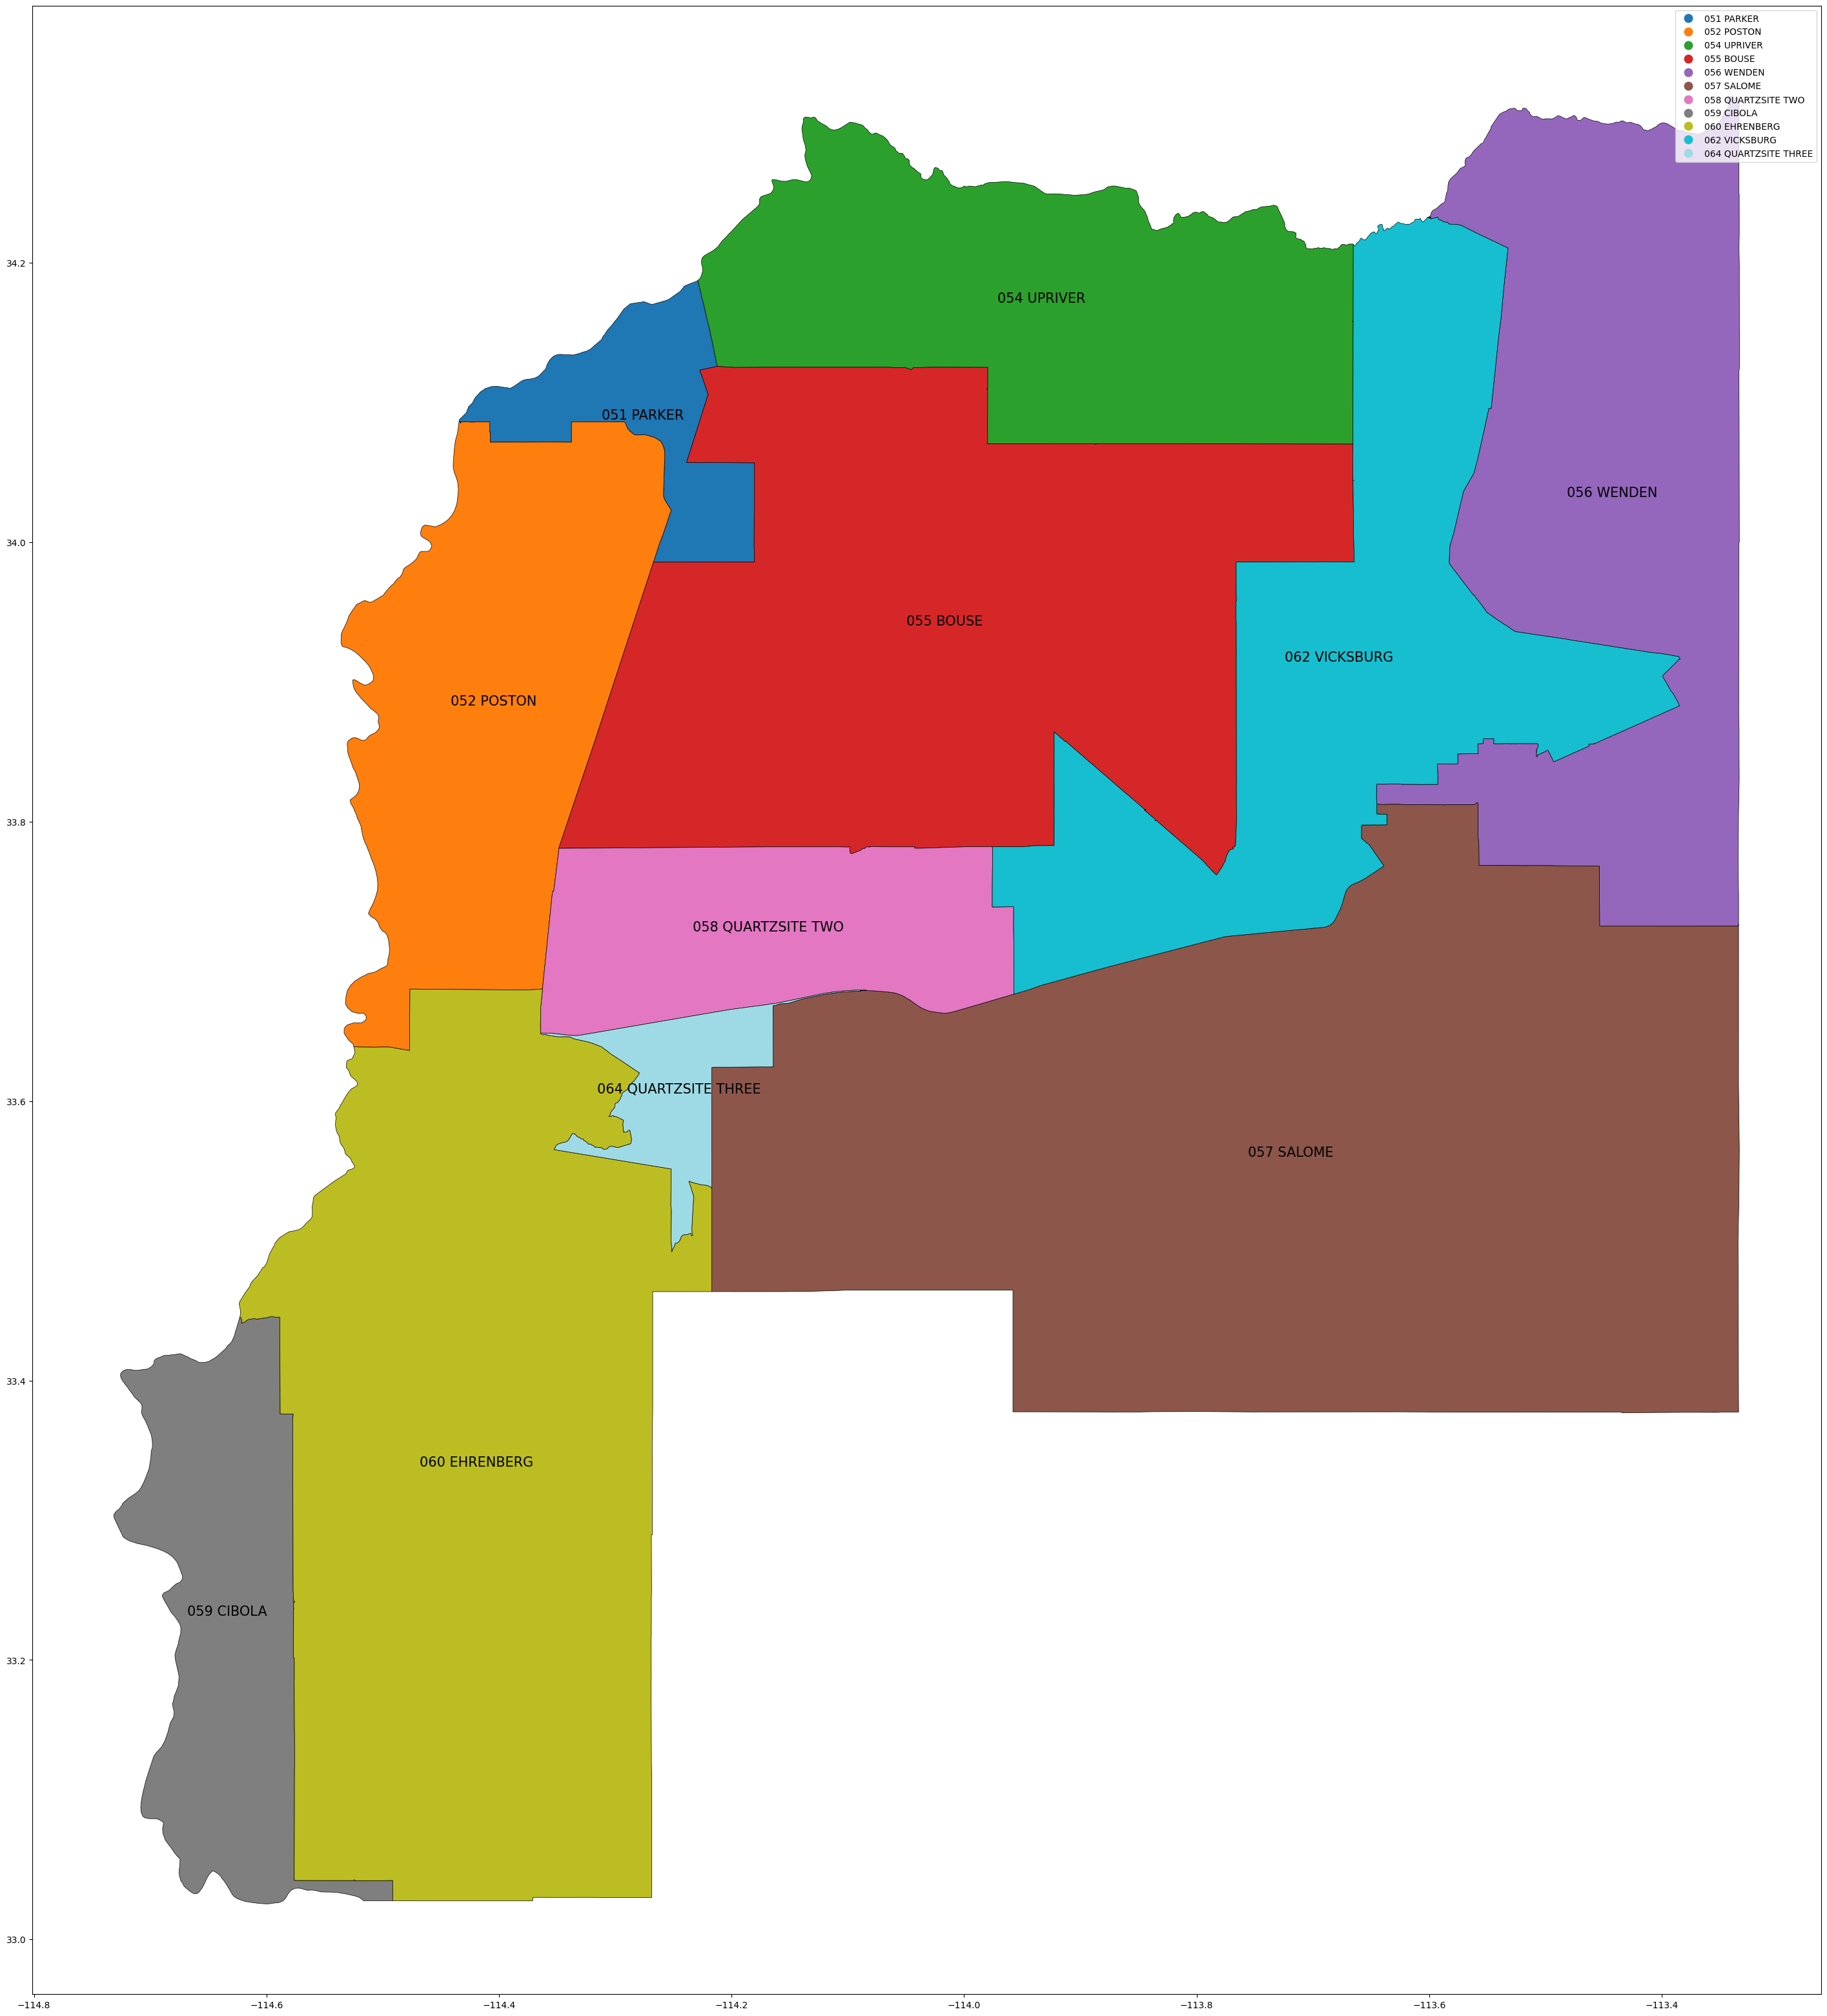

In [970]:
# Merge the dataframes
gdf_La_Paz_final = la_paz_rows.merge(la_paz_2020[['UNIQUE_ID', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='UNIQUE_ID', 
                                       how='outer',
                                       indicator=True)

# Drop the duplicate col
# gdf_La_Paz_final = gdf_La_Paz_final.drop(columns=['UNIQUE_ID'])

gdf_La_Paz_final = gpd.GeoDataFrame(gdf_La_Paz_final, geometry='geometry')

plot_precincts_with_labels(gdf_La_Paz_final)


In [971]:
gdf_La_Paz_final

county  ... _merge
0   La Paz  ...   both
1   La Paz  ...   both
2   La Paz  ...   both
3   La Paz  ...   both
4   La Paz  ...   both
5   La Paz  ...   both
6   La Paz  ...   both
7   La Paz  ...   both
8   La Paz  ...   both
9   La Paz  ...   both
10  La Paz  ...   both

[11 rows x 267 columns]

In [972]:
check_precinct_districts(gdf_La_Paz_final)


Row 1:
  Column: GUSH09OWRI, Office Type: USH, District: 09, Value: 78.0
  Column: GUSH09RGOS, Office Type: USH, District: 09, Value: 864.0
  Column: GSL30OWRI, Office Type: SL, District: 30, Value: 32.0
  Column: GSL30RBIA, Office Type: SL, District: 30, Value: 722.0
  Column: GSL30RGIL, Office Type: SL, District: 30, Value: 641.0
  Column: GSU30OWRI, Office Type: SU, District: 30, Value: 46.0
  Column: GSU30RBOR, Office Type: SU, District: 30, Value: 896.0


Row 2:
  Column: GUSH09OWRI, Office Type: USH, District: 09, Value: 17.0
  Column: GUSH09RGOS, Office Type: USH, District: 09, Value: 96.0
  Column: GSL30OWRI, Office Type: SL, District: 30, Value: 10.0
  Column: GSL30RBIA, Office Type: SL, District: 30, Value: 74.0
  Column: GSL30RGIL, Office Type: SL, District: 30, Value: 83.0
  Column: GSU30OWRI, Office Type: SU, District: 30, Value: 9.0
  Column: GSU30RBOR, Office Type: SU, District: 30, Value: 92.0


Row 3:
  Column: GUSH09OWRI, Office Type: USH, District: 09, Value: 31.0
  

In [973]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_La_Paz_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          11
left_only      0
right_only     0
Name: count, dtype: int64


In [974]:

gdf_La_Paz_final = gdf_La_Paz_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_La_Paz_final.drop(columns=['precinct'], inplace=True)
gdf_La_Paz_final.drop(columns=['_merge'], inplace=True)


gdf_La_Paz_final['COUNTYFP'] = '012'


cols = gdf_La_Paz_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_La_Paz_final = gdf_La_Paz_final[cols]

gdf_La_Paz_final = add_districts_numbers(gdf_La_Paz_final)


gdf_La_Paz_final.head(5)


UNIQUE_ID  ...                                           geometry
0   051 PARKER  ...  POLYGON ((-114.43435 34.08650, -114.43418 34.0...
1   052 POSTON  ...  POLYGON ((-114.34848 33.78091, -114.34849 33.7...
2  054 UPRIVER  ...  POLYGON ((-113.84995 34.24601, -113.84995 34.2...
3    055 BOUSE  ...  POLYGON ((-113.66555 34.07020, -113.66566 34.0...
4   056 WENDEN  ...  POLYGON ((-113.33337 33.99992, -113.33375 33.9...

[5 rows x 269 columns]

In [975]:
gdf_La_Paz_final

UNIQUE_ID  ...                                           geometry
0             051 PARKER  ...  POLYGON ((-114.43435 34.08650, -114.43418 34.0...
1             052 POSTON  ...  POLYGON ((-114.34848 33.78091, -114.34849 33.7...
2            054 UPRIVER  ...  POLYGON ((-113.84995 34.24601, -113.84995 34.2...
3              055 BOUSE  ...  POLYGON ((-113.66555 34.07020, -113.66566 34.0...
4             056 WENDEN  ...  POLYGON ((-113.33337 33.99992, -113.33375 33.9...
5             057 SALOME  ...  POLYGON ((-113.42871 33.37691, -113.42871 33.3...
6     058 QUARTZSITE TWO  ...  POLYGON ((-114.36264 33.68022, -114.36177 33.6...
7             059 CIBOLA  ...  POLYGON ((-114.51575 33.02762, -114.51645 33.0...
8          060 EHRENBERG  ...  POLYGON ((-114.39615 33.02750, -114.39665 33.0...
9          062 VICKSBURG  ...  POLYGON ((-113.66154 34.21469, -113.66146 34.2...
10  064 QUARTZSITE THREE  ...  POLYGON ((-114.36410 33.64851, -114.36271 33.6...

[11 rows x 269 columns]

### Maricopa County

In [976]:
geojson_file_Maricopa = './precinct_boundaries/Maricopa.geojson'
gdf_Maricopa = gpd.read_file(geojson_file_Maricopa)

print(sorted(gdf_Maricopa['BdName']))
print(len(gdf_Maricopa['BdName']))
# plot_precincts(gdf_Maricopa, 'PctNum')

['ACACIA', 'ACOMA', 'ACUNA', 'ADOBE', 'ADORA', 'AGRITOPIA', 'AGUA FRIA', 'AGUILA', 'AHWATUKEE', 'AIRLINE CANAL', 'ALAMO', 'ALEXANDER', 'ALHAMBRA', 'ALMA', 'ALPACA', 'ALSUP', 'ALTADENA', 'ALVARADO', 'AMBER', 'ANDERSON', 'ANDORA', 'ANGELA', 'ANNETTE', 'APACHE', 'APACHE PARK', 'APACHE WELLS', 'APOLLO', 'ARBOLEDA', 'ARBOR', 'ARCADIA', 'ARDMORE', 'ARENA', 'ARLINGTON', 'ARROWHEAD RANCH', 'ARTESIAN', 'ASANTE', 'ASHLAND RANCH', 'ASPEN', 'ASTER', 'ATHENS', 'AUGUSTA', 'AUGUSTA RANCH', 'AVIANO', 'AVIATION', 'AVONDALE', 'AZALEA', 'AZTEC SPRINGS', 'BALBOA', 'BALSZ', 'BANFF', 'BARNES', 'BARNEY', 'BAYSHORE', 'BEARDSLEY', 'BERRIDGE', 'BERYL', 'BETHANY', 'BETHANY PARK', 'BETHUNE', 'BILTMORE', 'BISCUIT FLAT', 'BISHOP', 'BLACK CANYON', 'BLACK GOLD', 'BLACKHAWK', 'BLOOM', 'BLUE HORIZONS', 'BLUE SKY', 'BLUEBIRD', 'BLUEFIELD', 'BLUEJAY', 'BOLERO', 'BONANZA', 'BONSALL PARK', 'BOULDER MOUNTAIN', 'BRACKEN', 'BREWER', 'BRONCO', 'BROOKS FARM', 'BUCKEYE', 'BUCKLEY', 'BUFFALO RIDGE', 'BULLARD', 'BULLMOOSE', 'BUNKE

In [977]:
gdf_Maricopa.head(5)

OBJECTID  ...                                           geometry
0         1  ...  POLYGON ((-12465003.878 3974849.765, -12464930...
1         2  ...  POLYGON ((-12473102.213 3954544.032, -12473102...
2         3  ...  POLYGON ((-12482688.272 3975699.161, -12482697...
3         4  ...  POLYGON ((-12500589.456 3991825.730, -12500572...
4         5  ...  POLYGON ((-12496392.891 3978429.630, -12496394...

[5 rows x 7 columns]

In [978]:
maricopa_rows = final_df[final_df['county'].str.lower() == 'maricopa']
def extract_precinct_num(precinct):
    # Extract the numeric part at the beginning
    match = re.match(r'^\d+', precinct)
    return match.group(0) if match else None

def extract_precinct_name(precinct):
    # Extract the name part after the number
    match = re.match(r'^\d+\s+(.*)$', precinct)
    return match.group(1).strip() if match else None

# Apply the functions to create the new columns
# maricopa_rows['PCTNUM'] = maricopa_rows['precinct'].apply(extract_precinct_num)
# maricopa_rows['PRECINCTNA'] = maricopa_rows['precinct'].apply(extract_precinct_name)
# maricopa_rows['UNIQUE_ID'] = maricopa_rows['precinct']
maricopa_rows['PCTNUM'] = maricopa_rows['precinct'].str.lower().str[1:4].str.lstrip('0')
# print(len(maricopa_rows['precinct']))
# print(sorted(maricopa_rows['precinct']))
maricopa_rows.head(5)

county     precinct  G22ATGDMAY  ...  G22GOVWCAM  G22USSWROX  PCTNUM
708  Maricopa  0001 ACACIA       483.0  ...         NaN         NaN       1
709  Maricopa   0002 ACOMA       875.0  ...         NaN         NaN       2
710  Maricopa   0003 ACUNA       847.0  ...         NaN         NaN       3
711  Maricopa   0004 ADOBE       421.0  ...         NaN         NaN       4
712  Maricopa   0005 ADORA      1297.0  ...         NaN         NaN       5

[5 rows x 263 columns]

The election results shows that Maricopa has 904 precincts, but precincts boyndaries shows that it has 935 precincts.
The official website mentioned that there are some precincts with no voters


In [979]:
gdf_Maricopa['PctNum'] = gdf_Maricopa['PctNum'].astype(str)
maricopa_rows['precinct'] = maricopa_rows['precinct'].astype(str)

gdf_Maricopa_final = pd.merge(maricopa_rows, gdf_Maricopa[['PctNum', 'geometry', 'BdName']], how='outer', left_on='PCTNUM', right_on='PctNum', indicator=True)

gdf_Maricopa_final = gpd.GeoDataFrame(gdf_Maricopa_final, geometry='geometry')


In [980]:
gdf_Maricopa_final.columns

Index(['county', 'precinct', 'G22ATGDMAY', 'G22ATGRHAM', 'G22COCDKEN',
       'G22COCDKUB', 'G22COCRMYE', 'G22COCRTHO', 'G22GOVDHOB', 'G22GOVOWRI',
       ...
       'G22GOVWDEN', 'G22GOVWMER', 'G22USSWBOR', 'G22GOVWCAM', 'G22USSWROX',
       'PCTNUM', 'PctNum', 'geometry', 'BdName', '_merge'],
      dtype='object', length=267)

In [981]:
both = gdf_Maricopa_final[gdf_Maricopa_final['_merge']=='both']
len(both)

904

0
['574', '555', '773', '557', '559', '776', '774', '566', '860', '558', '410', '777', '568', '569', '565', '561', '571', '560', '775', '577', '562', '575', '563', '848', '567', '576', '572', '564', '570', '573', '556']
31


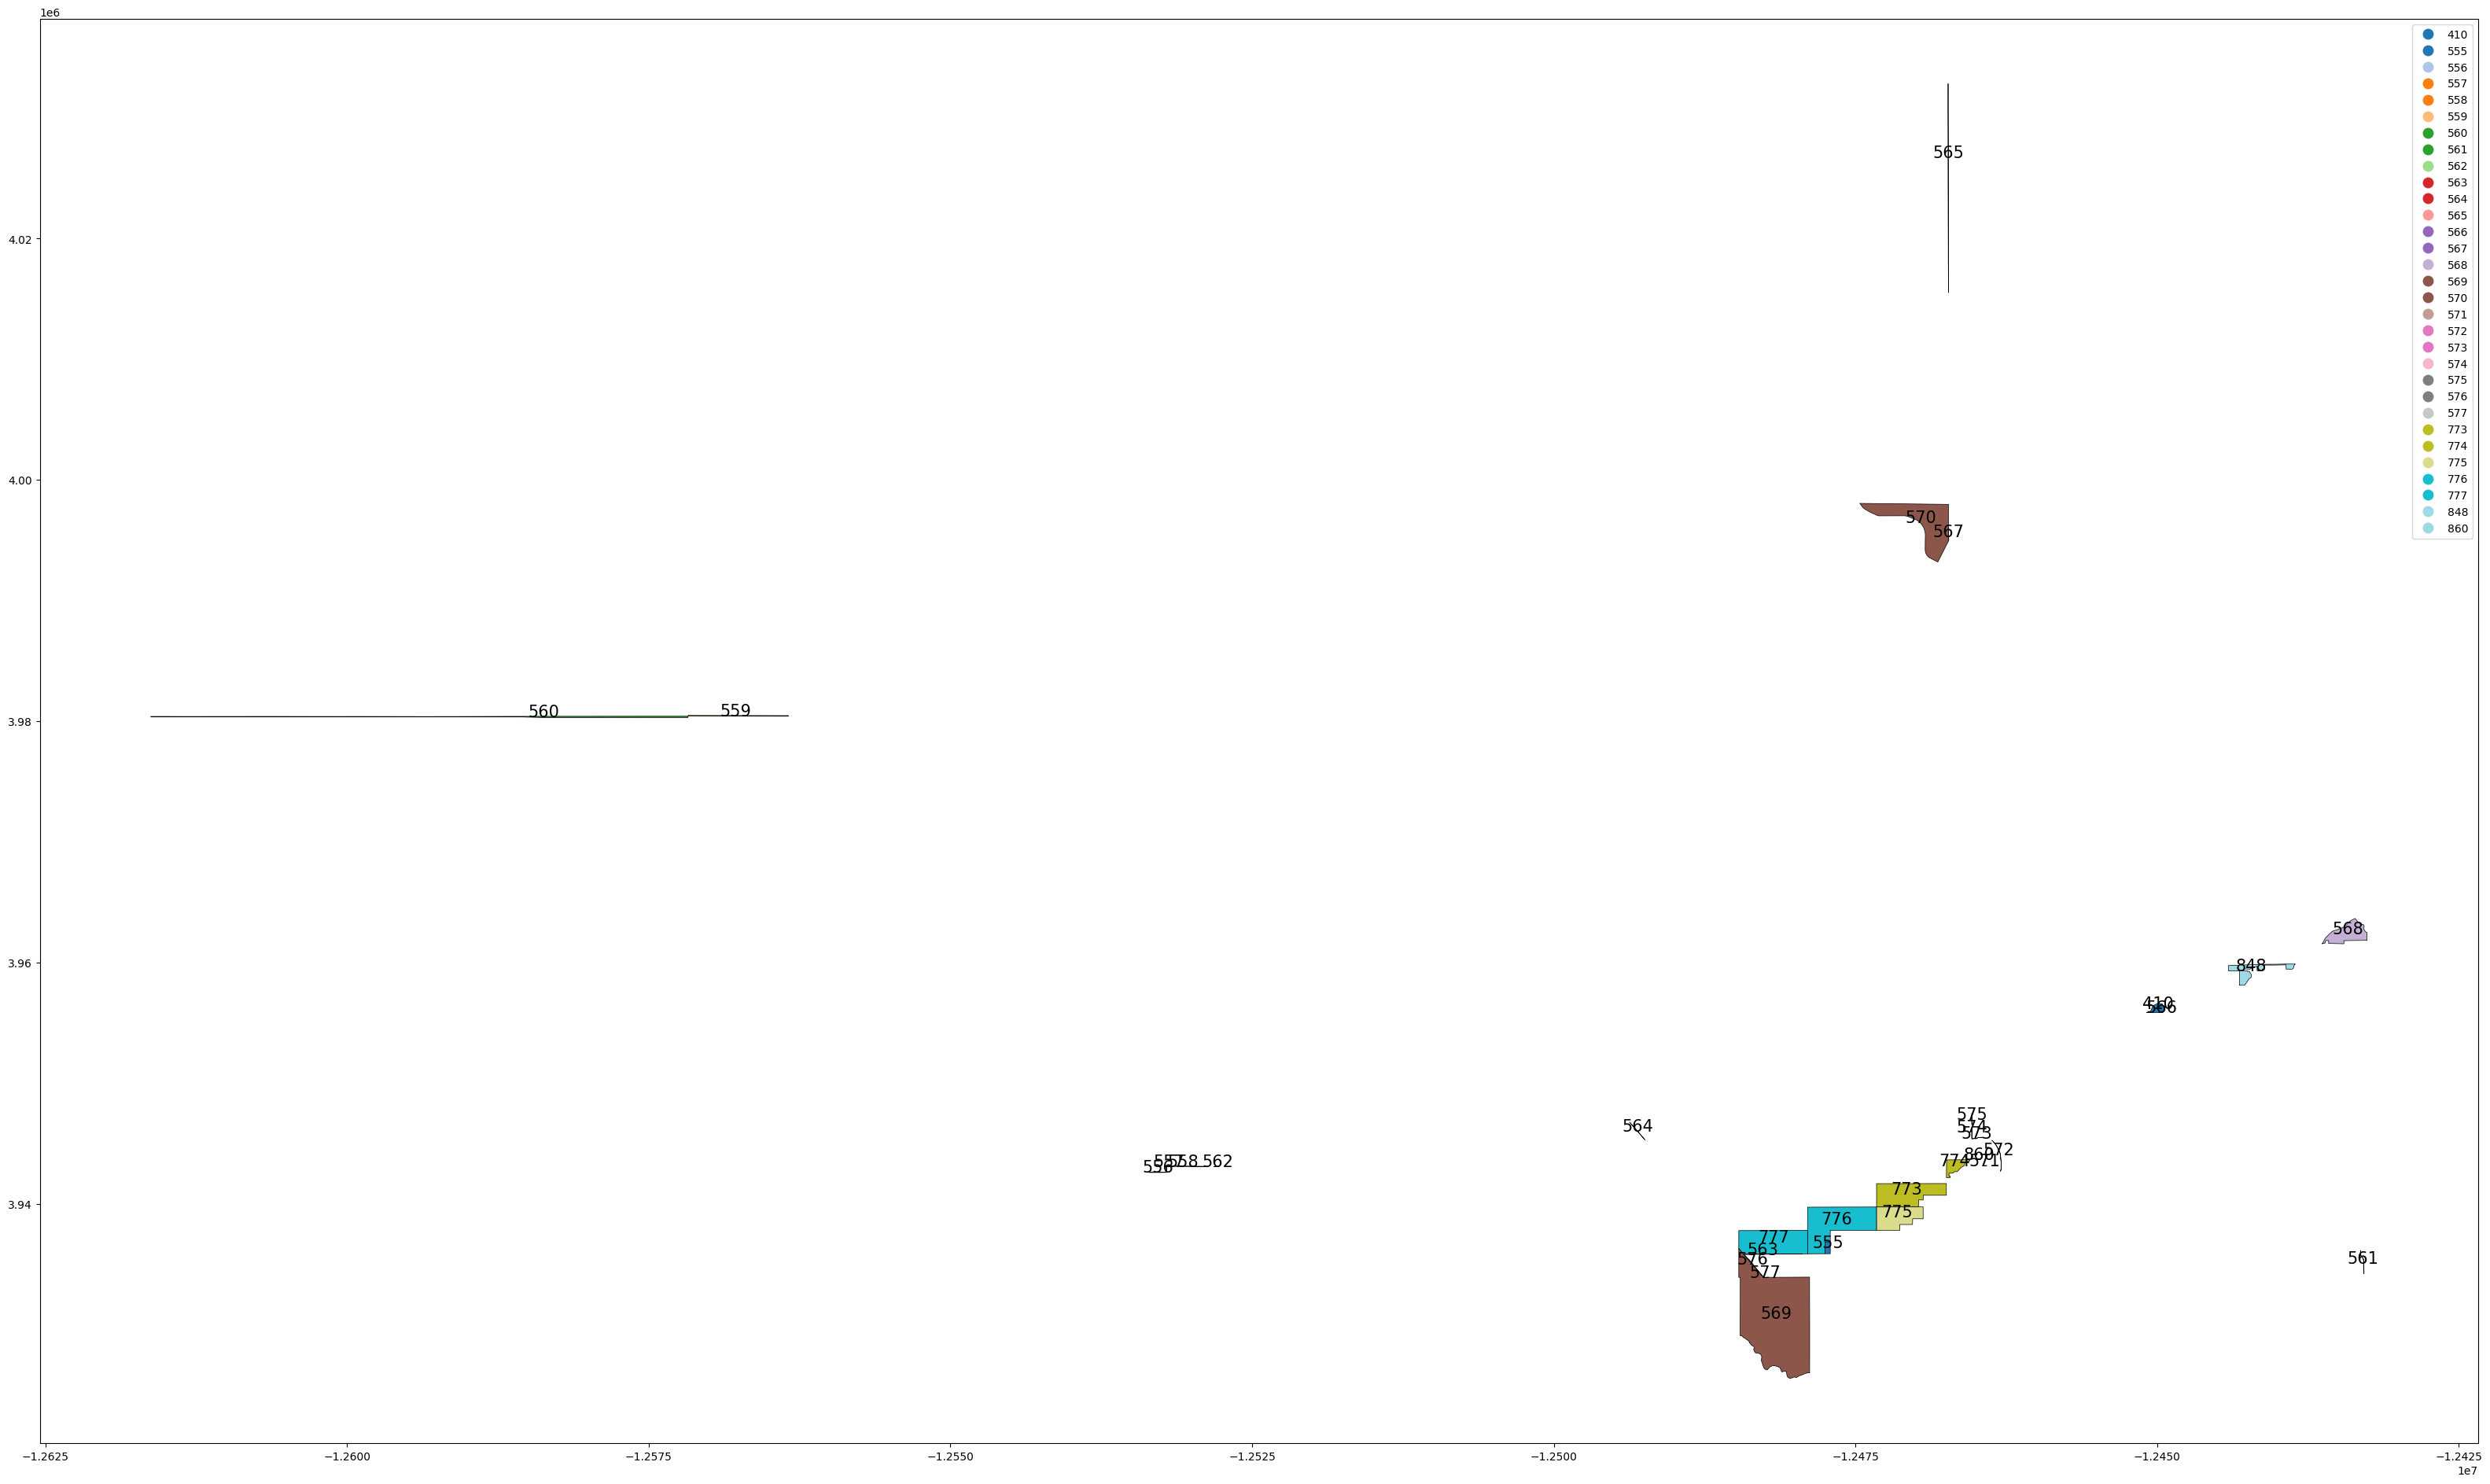

In [982]:
both = gdf_Maricopa_final[gdf_Maricopa_final['_merge']=='both']
len(both)
left_only = gdf_Maricopa_final[gdf_Maricopa_final['_merge']=='left_only']
print(len(left_only))
right_only = gdf_Maricopa_final[gdf_Maricopa_final['_merge']=='right_only']
len(right_only)
print(list(right_only['PctNum']))
print(len(list(right_only['PctNum'])))
right_only_org = gdf_Maricopa[gdf_Maricopa['PctNum'].isin(list(right_only['PctNum']))]
plot_precincts(right_only_org, 'PctNum')

['574', '555', '773', '557', '559', '776', '774', '566', '860', '558', '410', '777', '568', '569', '565', '561', '571', '560', '775', '577', '562', '575', '563', '848', '567', '576', '572', '564', '570', '573', '556']
31


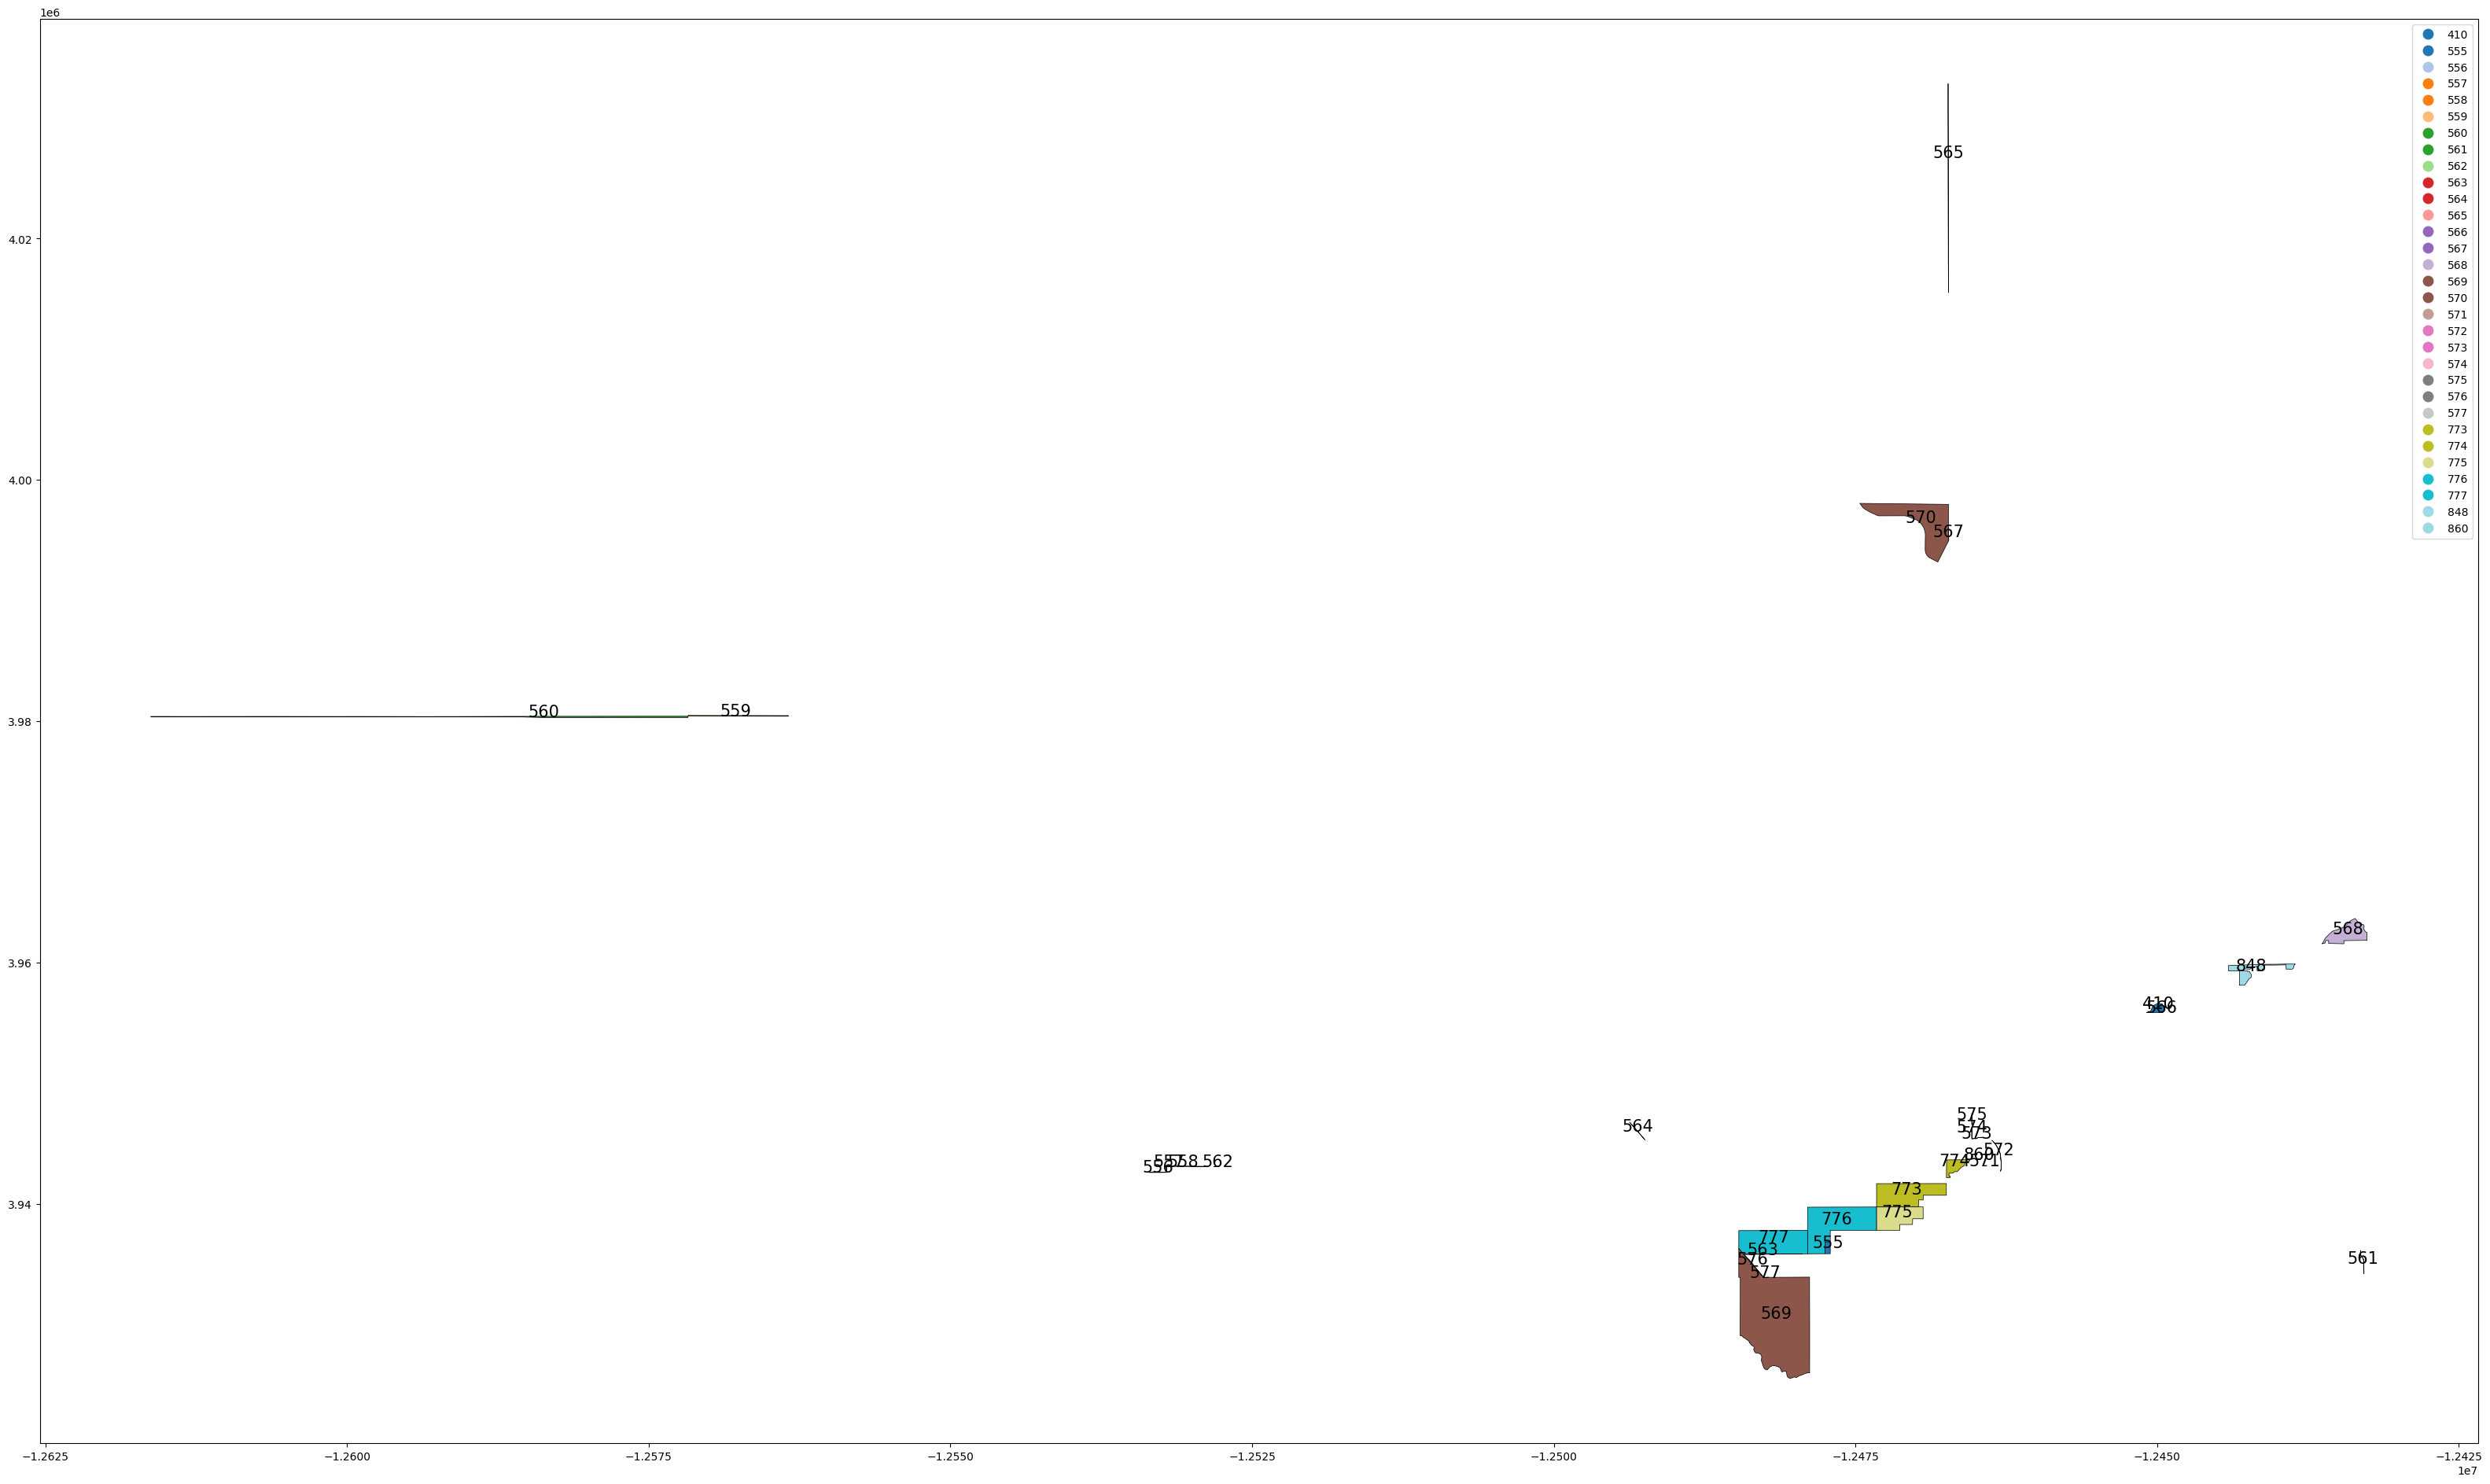

In [983]:
print(list(right_only['PctNum']))
print(len(list(right_only['PctNum'])))
right_only_org = gdf_Maricopa[gdf_Maricopa['PctNum'].isin(list(right_only['PctNum']))]
plot_precincts(right_only_org, 'PctNum')

In [984]:
right_only_org.to_file('maricopa.geojson', driver='GeoJSON')

In [985]:
check_precinct_districts(gdf_Maricopa_final)


Row 1:
  Column: GSL02DSCH, Office Type: SL, District: 02, Value: 481.0
  Column: GSL02RLAM, Office Type: SL, District: 02, Value: 404.0
  Column: GSL02RWIL, Office Type: SL, District: 02, Value: 422.0
  Column: GSU02DCAS, Office Type: SU, District: 02, Value: 465.0
  Column: GSU02RKAI, Office Type: SU, District: 02, Value: 468.0
  Column: GUSH08NGUZ, Office Type: USH, District: 08, Value: 13.0
  Column: GUSH08NSPR, Office Type: USH, District: 08, Value: 21.0
  Column: GUSH08OWRI, Office Type: USH, District: 08, Value: 78.0
  Column: GUSH08RLES, Office Type: USH, District: 08, Value: 561.0


Row 2:
  Column: GUSH08NGUZ, Office Type: USH, District: 08, Value: 11.0
  Column: GUSH08NSPR, Office Type: USH, District: 08, Value: 34.0
  Column: GUSH08OWRI, Office Type: USH, District: 08, Value: 129.0
  Column: GUSH08RLES, Office Type: USH, District: 08, Value: 1600.0
  Column: GSL27DKIS, Office Type: SL, District: 27, Value: 816.0
  Column: GSL27RPAY, Office Type: SL, District: 27, Value: 141

In [986]:
gdf_Maricopa_final.head(5)

county     precinct  ...  BdName  _merge
0  Maricopa  0001 ACACIA  ...  ACACIA    both
1  Maricopa   0002 ACOMA  ...   ACOMA    both
2  Maricopa   0003 ACUNA  ...   ACUNA    both
3  Maricopa   0004 ADOBE  ...   ADOBE    both
4  Maricopa   0005 ADORA  ...   ADORA    both

[5 rows x 267 columns]

In [987]:

gdf_Maricopa_final = gdf_Maricopa_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Maricopa_final['COUNTY_NAM'] = 'Maricopa'


gdf_Maricopa_final['PCTNUM'] = gdf_Maricopa_final['PctNum']
gdf_Maricopa_final['UNIQUE_ID'] = gdf_Maricopa_final['precinct']
gdf_Maricopa_final['PRECINCTNA'] = gdf_Maricopa_final['BdName']

gdf_Maricopa_final.drop(columns=['BdName'], inplace=True)
gdf_Maricopa_final.drop(columns=['precinct'], inplace=True)
gdf_Maricopa_final.drop(columns=['_merge'], inplace=True)
gdf_Maricopa_final.drop(columns=['PctNum'], inplace=True)

# shouldnot drop PCTNUM

gdf_Maricopa_final['COUNTYFP'] = '013'


cols = gdf_Maricopa_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Maricopa_final = gdf_Maricopa_final[cols]

gdf_Maricopa_final = add_districts_numbers(gdf_Maricopa_final)


gdf_Maricopa_final.head(5)


UNIQUE_ID  ...                                           geometry
0  0001 ACACIA  ...  POLYGON ((-12480753.987 3976669.079, -12480754...
1   0002 ACOMA  ...  POLYGON ((-12491819.914 3980306.820, -12491802...
2   0003 ACUNA  ...  POLYGON ((-12485146.504 3959254.082, -12485146...
3   0004 ADOBE  ...  POLYGON ((-12480855.675 3987155.106, -12480855...
4   0005 ADORA  ...  POLYGON ((-12440501.618 3922503.500, -12440546...

[5 rows x 269 columns]

### Mohave County

In [988]:
# Read the shapefile
shapefile_path_Mohave = './precinct_boundaries/Mohave/Voting_Precincts_2023.shp'
gdf_Mohave = gpd.read_file(shapefile_path_Mohave)

print(gdf_Mohave)


    FID  ...                                           geometry
0     1  ...  POLYGON ((-113.72419 35.59598, -113.73184 35.6...
1     2  ...  POLYGON ((-112.60020 36.83171, -112.60024 36.8...
2     3  ...  POLYGON ((-114.42744 34.83760, -114.42709 34.8...
3     4  ...  MULTIPOLYGON (((-113.07739 36.19964, -113.0779...
4     5  ...  POLYGON ((-113.79203 34.58938, -113.79109 34.5...
5     6  ...  POLYGON ((-114.19233 34.55175, -114.19225 34.5...
6     7  ...  POLYGON ((-113.92300 35.49343, -113.92293 35.4...
7     8  ...  POLYGON ((-114.03667 35.23941, -114.03776 35.2...
8     9  ...  POLYGON ((-114.14745 35.46148, -114.14747 35.4...
..  ...  ...                                                ...
15   16  ...  POLYGON ((-114.06171 35.50571, -114.06246 35.5...
16   17  ...  POLYGON ((-113.90481 35.83383, -113.90481 35.8...
17   18  ...  POLYGON ((-114.19233 34.55175, -114.19421 34.5...
18   19  ...  POLYGON ((-114.12403 35.06711, -114.11710 35.0...
19   20  ...  POLYGON ((-112.60020 36.83

In [989]:
mohave_rows = final_df[final_df['county'].str.lower() == 'mohave']
def extract_precinct_num(precinct):
    # Extract the numeric part before the hyphen
    match = re.match(r'^\d+', precinct)
    return match.group(0) if match else None

def extract_precinct_name(precinct):
    # Extract the name part after the hyphen
    match = re.search(r'-(.*)', precinct)
    return match.group(1).strip() if match else None

# Apply the functions to create the new columns
mohave_rows['PCTNUM'] = mohave_rows['precinct'].apply(extract_precinct_num)
mohave_rows['PRECINCTNA'] = mohave_rows['precinct'].apply(extract_precinct_name)
mohave_rows['UNIQUE_ID'] = mohave_rows['precinct']

mohave_rows['precinct'] = mohave_rows['precinct'].str[4:].str.upper()
mohave_rows['precinct'] = remove_special_characters(mohave_rows['precinct'])
mohave_rows

county           precinct  ...         PRECINCTNA              UNIQUE_ID
684  Mohave            WIKIEUP  ...            Wikieup            201-Wikieup
685  Mohave        WHITE HILLS  ...        White Hills        202-White Hills
686  Mohave              YUCCA  ...              Yucca              203-Yucca
687  Mohave           CHLORIDE  ...           Chloride           204-Chloride
688  Mohave       NORTH CANYON  ...       North Canyon       205-North Canyon
689  Mohave             OATMAN  ...             Oatman             206-Oatman
690  Mohave       DESERT HILLS  ...       Desert Hills       207-Desert Hills
691  Mohave           MEADVIEW  ...           Meadview           208-Meadview
692  Mohave      DOLAN SPRINGS  ...      Dolan Springs      209-Dolan Springs
..      ...                ...  ...                ...                    ...
699  Mohave      KINGMAN NORTH  ...      Kingman North      216-Kingman North
700  Mohave      KINGMAN SOUTH  ...      Kingman South      217-Kingman South
701  Mohave       KINGMAN EAST  ...       Kingman East       218-Kingman East
702  Mohave  LAKE HAVASU NORTH  ...  Lake Havasu North  219-Lake Havasu North
703  Mohave  LAKE HAVASU SOUTH  ...  Lake Havasu South  220-Lake Havasu South
704  Mohave        LITTLEFIELD  ...        Littlefield        221-Littlefield
705  Mohave      GOLDEN SHORES  ...      Golden Shores      222-Golden Shores
706  Mohave           MOCCASIN  ...           Moccasin           223-Moccasin
707  Mohave      PEACH SPRINGS  ...      Peach Springs      224-Peach Springs

[24 rows x 265 columns]

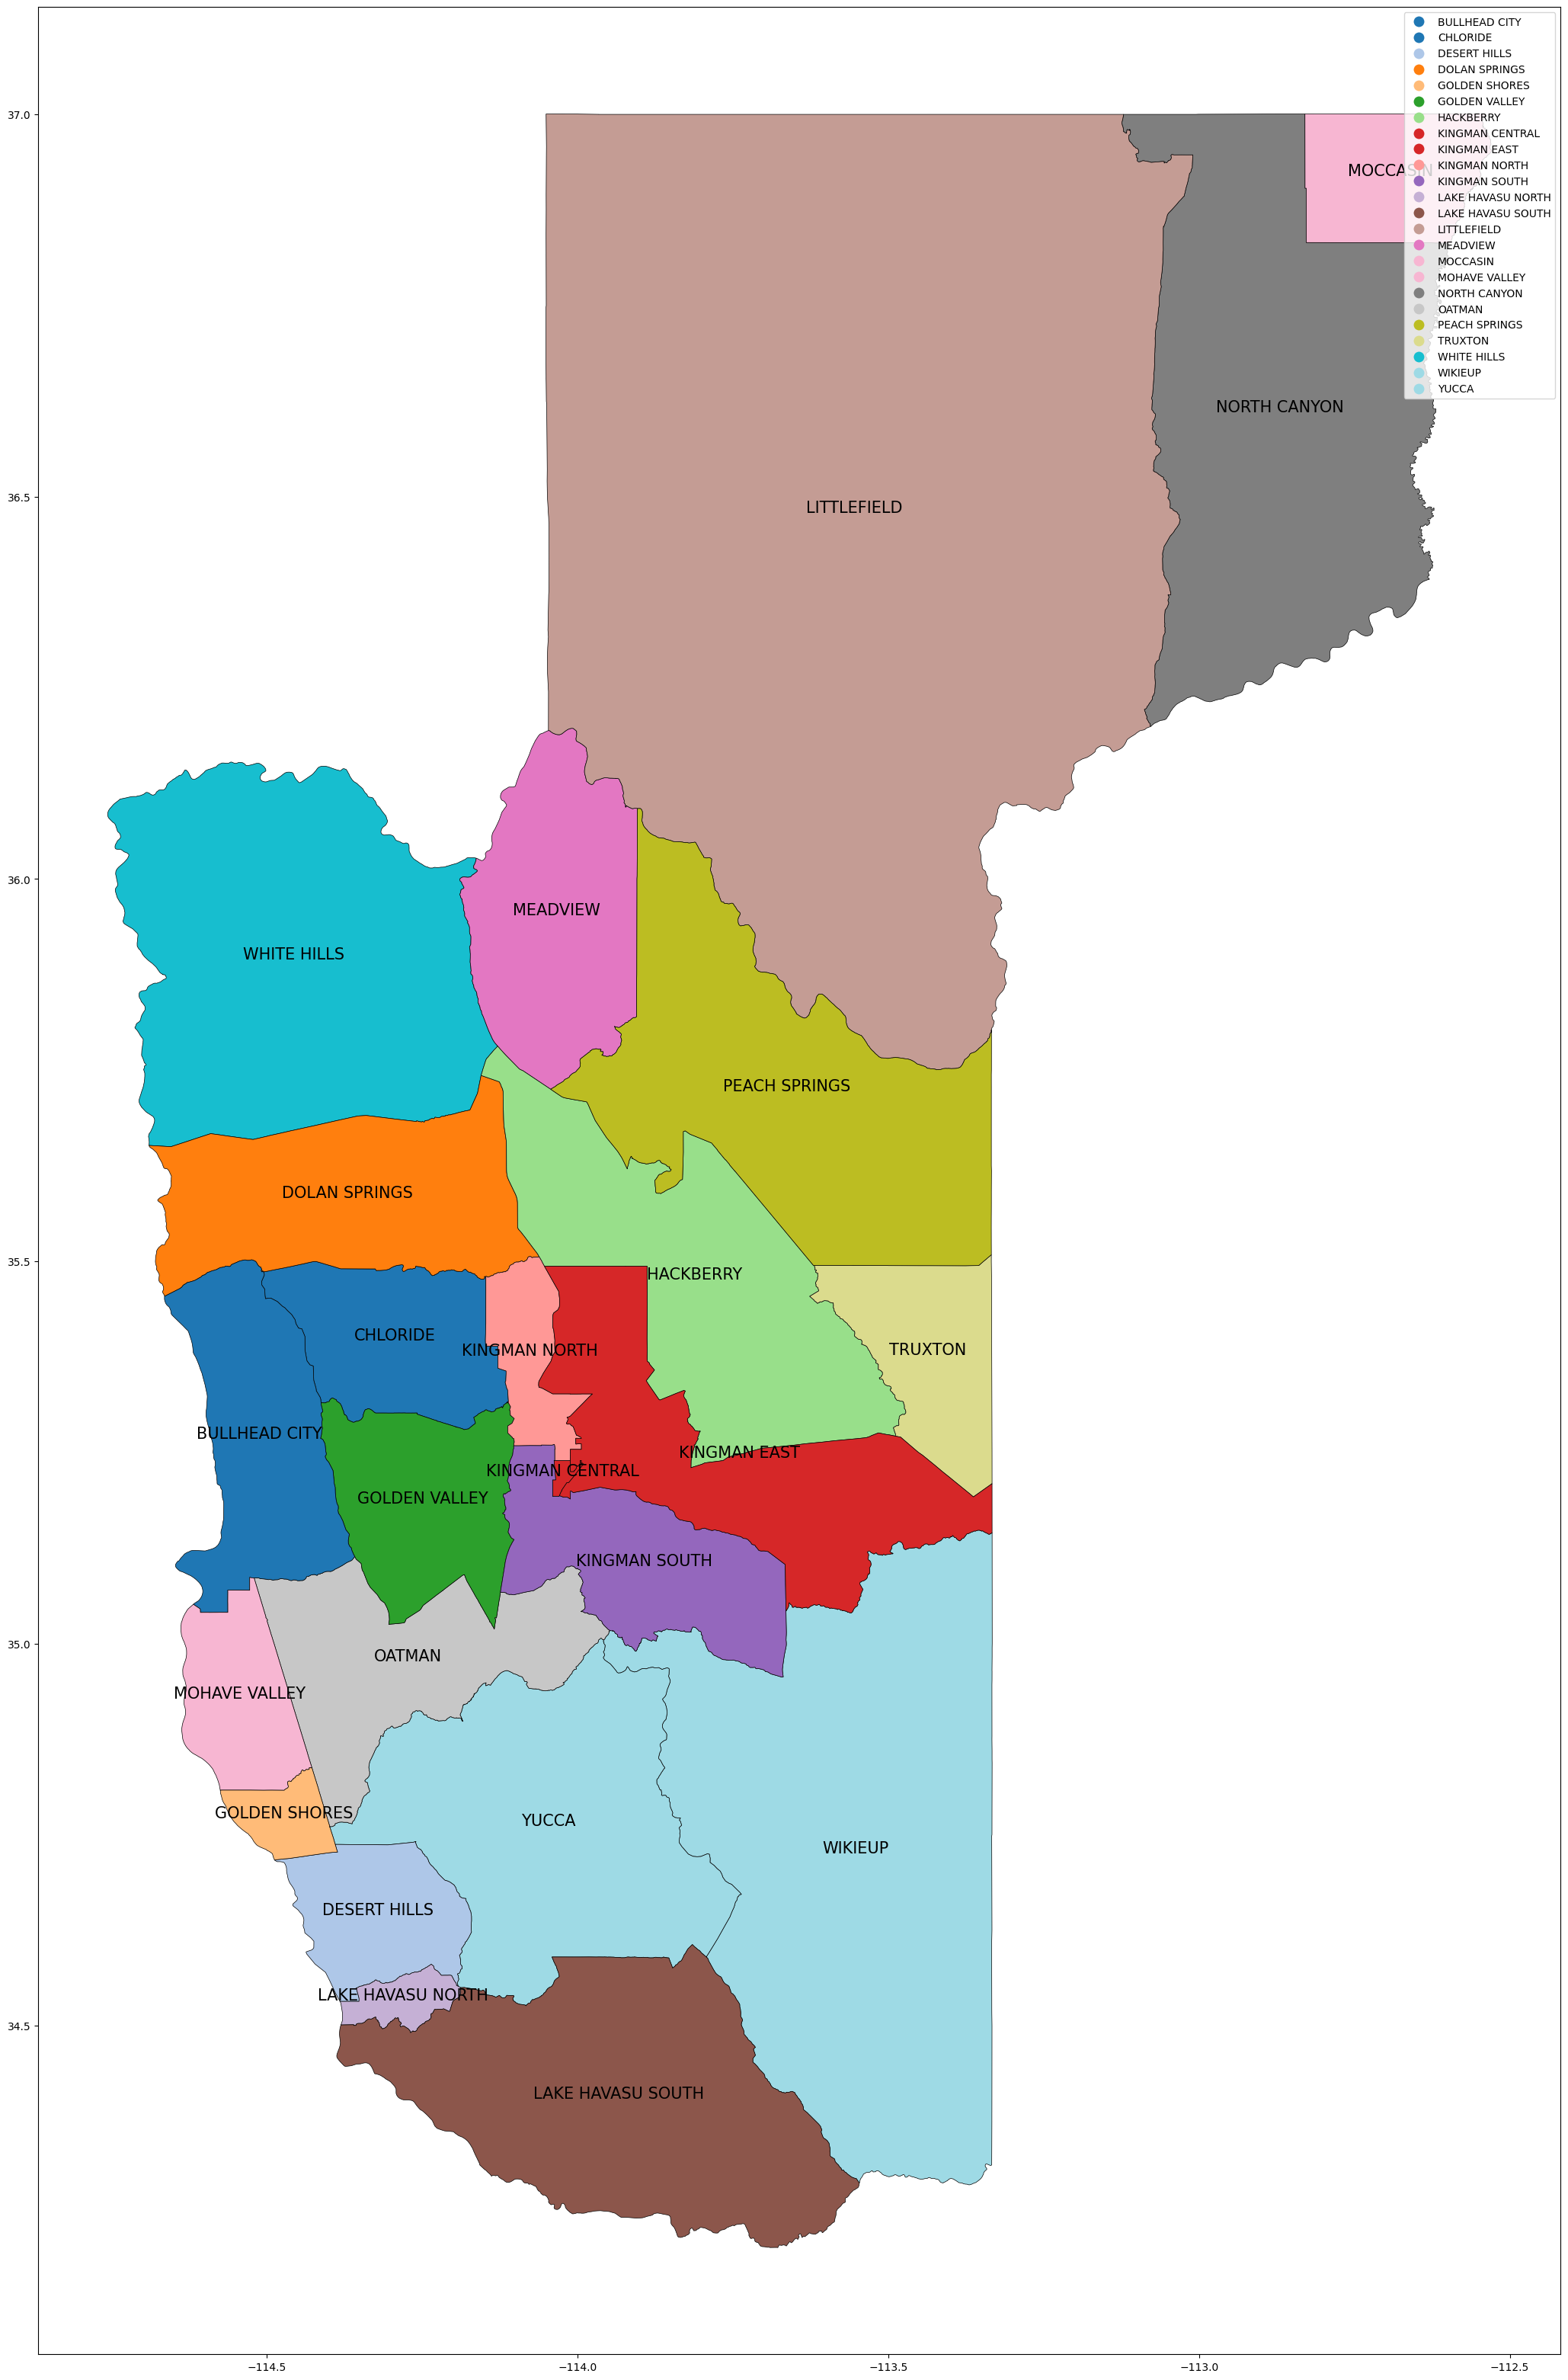

In [990]:
gdf_Mohave_final = mohave_rows.merge(gdf_Mohave[['NAME', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='NAME', 
                                       how='outer',
                                       indicator=True)

gdf_Mohave_final = gdf_Mohave_final.drop(columns=['NAME'])

gdf_Mohave_final = gpd.GeoDataFrame(gdf_Mohave_final, geometry='geometry')

plot_precincts_with_labels(gdf_Mohave_final)

In [991]:
check_precinct_districts(gdf_Mohave_final)


Row 1:
  Column: GUSH09OWRI, Office Type: USH, District: 09, Value: 4.0
  Column: GUSH09RGOS, Office Type: USH, District: 09, Value: 141.0
  Column: GSL30OWRI, Office Type: SL, District: 30, Value: 2.0
  Column: GSL30RBIA, Office Type: SL, District: 30, Value: 126.0
  Column: GSL30RGIL, Office Type: SL, District: 30, Value: 97.0
  Column: GSU30OWRI, Office Type: SU, District: 30, Value: 2.0
  Column: GSU30RBOR, Office Type: SU, District: 30, Value: 139.0


Row 2:
  Column: GUSH09OWRI, Office Type: USH, District: 09, Value: 6.0
  Column: GUSH09RGOS, Office Type: USH, District: 09, Value: 132.0
  Column: GSL30OWRI, Office Type: SL, District: 30, Value: 2.0
  Column: GSL30RBIA, Office Type: SL, District: 30, Value: 109.0
  Column: GSL30RGIL, Office Type: SL, District: 30, Value: 85.0
  Column: GSU30OWRI, Office Type: SU, District: 30, Value: 2.0
  Column: GSU30RBOR, Office Type: SU, District: 30, Value: 135.0


Row 3:
  Column: GUSH09OWRI, Office Type: USH, District: 09, Value: 12.0
  Col

In [992]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Mohave_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          24
left_only      0
right_only     0
Name: count, dtype: int64


In [993]:
gdf_Mohave_final.head(5)

county  ... _merge
0  Mohave  ...   both
1  Mohave  ...   both
2  Mohave  ...   both
3  Mohave  ...   both
4  Mohave  ...   both

[5 rows x 267 columns]

In [994]:

gdf_Mohave_final = gdf_Mohave_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Mohave_final.drop(columns=['precinct'], inplace=True)
gdf_Mohave_final.drop(columns=['_merge'], inplace=True)



gdf_Mohave_final['COUNTYFP'] = '015'


cols = gdf_Mohave_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Mohave_final = gdf_Mohave_final[cols]

gdf_Mohave_final = add_districts_numbers(gdf_Mohave_final)


gdf_Mohave_final.head(5)


UNIQUE_ID  ...                                           geometry
0       201-Wikieup  ...  POLYGON ((-113.33290 35.14495, -113.33289 35.1...
1   202-White Hills  ...  POLYGON ((-114.55341 36.15174, -114.55105 36.1...
2         203-Yucca  ...  POLYGON ((-113.95743 35.00502, -113.95806 35.0...
3      204-Chloride  ...  POLYGON ((-114.14759 35.47998, -114.14746 35.4...
4  205-North Canyon  ...  POLYGON ((-112.60020 36.83171, -112.60020 36.8...

[5 rows x 269 columns]

### Navajo County

In [995]:
navajo_rows = final_df[final_df['county'].str.lower() == 'navajo']
def extract_precinct_num(precinct):
    # Extract the numeric part at the beginning
    match = re.match(r'^\d+', precinct)
    return match.group(0) if match else None

def extract_precinct_name(precinct):
    # Extract the name part after the number
    match = re.match(r'^\d+\s+(.*)$', precinct)
    return match.group(1).strip() if match else None

# Apply the functions to create the new columns
navajo_rows['PCTNUM'] = navajo_rows['precinct'].apply(extract_precinct_num)
navajo_rows['PRECINCTNA'] = navajo_rows['precinct'].apply(extract_precinct_name)
navajo_rows

county           precinct  G22ATGDMAY  ...  G22USSWROX  PCTNUM      PRECINCTNA
1634  Navajo       01 Red Butte      4845.0  ...         NaN      01       Red Butte
1635  Navajo  02 Painted Desert      1386.0  ...         NaN      02  Painted Desert
1636  Navajo         03 Hubbell        43.0  ...         NaN      03         Hubbell
1637  Navajo    04 Black Buttes      3250.0  ...         NaN      04    Black Buttes
1638  Navajo    05 Cedar Valley       902.0  ...         NaN      05    Cedar Valley
1639  Navajo     06 Stone Butte       354.0  ...         NaN      06     Stone Butte
1640  Navajo         07 Pioneer       768.0  ...         NaN      07         Pioneer
1641  Navajo        08 Antelope        37.0  ...         NaN      08        Antelope
1642  Navajo         09 Juniper       307.0  ...         NaN      09         Juniper
1643  Navajo           10 Bison       150.0  ...         NaN      10           Bison
1644  Navajo        11 Mogollon       624.0  ...         NaN      11        Mogollon
1645  Navajo        12 Woodland      1948.0  ...         NaN      12        Woodland
1646  Navajo      13 Sitgreaves      1662.0  ...         NaN      13      Sitgreaves
1647  Navajo         14 Sunrise      1843.0  ...         NaN      14         Sunrise

[14 rows x 264 columns]

In [996]:
navajo_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Navajo']
print(navajo_2020)

                                               geometry  ... SLDU_DIST
195   POLYGON ((-110.49382 37.00377, -110.49091 37.0...  ...        07
196   POLYGON ((-110.00067 35.88051, -110.00067 35.8...  ...        07
197   POLYGON ((-110.63892 35.17127, -110.63450 35.1...  ...        07
213   POLYGON ((-109.84895 34.21743, -109.84900 34.2...  ...        07
214   POLYGON ((-110.00754 34.31576, -110.00768 34.3...  ...        07
215   POLYGON ((-110.43036 34.30681, -110.42831 34.3...  ...        07
219   POLYGON ((-110.12956 35.80964, -110.12582 35.8...  ...        07
220   POLYGON ((-110.31307 36.43057, -110.31074 36.4...  ...        07
247   POLYGON ((-110.56254 34.92865, -110.56221 34.9...  ...        06
248   POLYGON ((-110.14648 34.95553, -110.14533 34.9...  ...        06
249   POLYGON ((-109.86392 34.47400, -109.86375 34.4...  ...        06
250   POLYGON ((-110.34077 34.49636, -110.33938 34.4...  ...        06
251   POLYGON ((-110.56096 34.51769, -110.56053 34.5...  ...        06
1477  

['01 RED BUTTE' '02 PAINTED DESERT' '03 HUBBELL' '04 BLACK BUTTES'
 '05 CEDAR VALLEY' '06 STONE BUTTE' '07 PIONEER' '08 ANTELOPE'
 '09 JUNIPER' '10 BISON' '11 MOGOLLON' '12 WOODLAND' '13 SITGREAVES'
 '14 SUNRISE']
['01 RED BUTTE' '02 PAINTED DESERT' '03 HUBBELL' '12 WOODLAND'
 '13 SITGREAVES' '14 SUNRISE' '05 CEDAR VALLEY' '06 STONE BUTTE'
 '07 PIONEER' '08 ANTELOPE' '09 JUNIPER' '10 BISON' '11 MOGOLLON'
 '04 BLACK BUTTES']


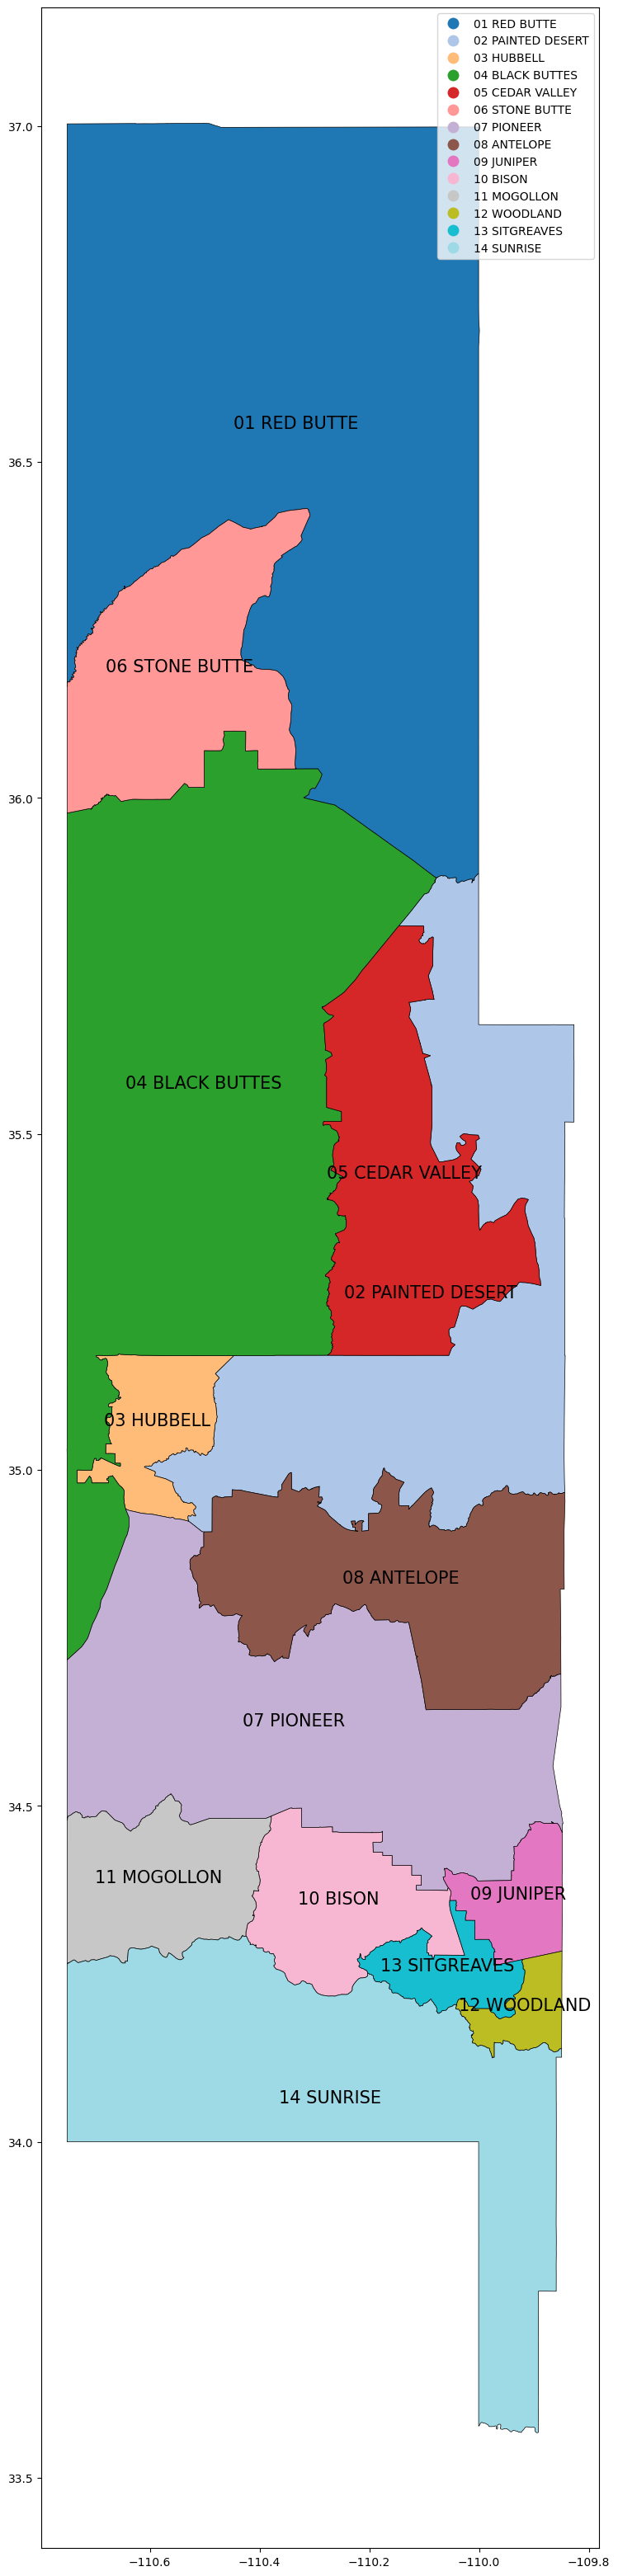

In [997]:
# Convert both columns to uppercase
navajo_rows['precinct'] = navajo_rows['precinct'].str.upper()
navajo_2020['UNIQUE_ID'] = navajo_2020['UNIQUE_ID'].str.upper()

# Check for matching values again
print(navajo_rows['precinct'].unique())
print(navajo_2020['UNIQUE_ID'].unique())

# Merge the dataframes on UNIQUE_ID and precinct
gdf_Navajo_final = navajo_rows.merge(navajo_2020[['UNIQUE_ID', 'geometry']], 
                                     left_on='precinct', 
                                     right_on='UNIQUE_ID', 
                                     how='outer',
                                     indicator=True)

# Drop the duplicate UNIQUE_ID column from the merged DataFrame
# gdf_Navajo_final = gdf_Navajo_final.drop(columns=['UNIQUE_ID'])
gdf_Navajo_final = gpd.GeoDataFrame(gdf_Navajo_final, geometry='geometry')

plot_precincts_with_labels(gdf_Navajo_final)


In [998]:
check_precinct_districts(gdf_Navajo_final)


Row 1:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 4967.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 638.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value: 18.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 3633.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 3869.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 29.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value: 5210.0
  Column: GSU06OWRI, Office Type: SU, District: 06, Value: 56.0


Row 2:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 1429.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 1275.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value: 12.0
  Column: GSL06DPES, Office Type: SL, District: 06, Value: 1365.0
  Column: GSL06DTSO, Office Type: SL, District: 06, Value: 1304.0
  Column: GSL06OWRI, Office Type: SL, District: 06, Value: 165.0
  Column: GSU06DHAT, Office Type: SU, District: 06, Value:

In [999]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Navajo_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          14
left_only      0
right_only     0
Name: count, dtype: int64


In [1000]:
gdf_Navajo_final

county  ... _merge
0   Navajo  ...   both
1   Navajo  ...   both
2   Navajo  ...   both
3   Navajo  ...   both
4   Navajo  ...   both
5   Navajo  ...   both
6   Navajo  ...   both
7   Navajo  ...   both
8   Navajo  ...   both
9   Navajo  ...   both
10  Navajo  ...   both
11  Navajo  ...   both
12  Navajo  ...   both
13  Navajo  ...   both

[14 rows x 267 columns]

In [1001]:

gdf_Navajo_final = gdf_Navajo_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Navajo_final.drop(columns=['precinct'], inplace=True)
gdf_Navajo_final.drop(columns=['_merge'], inplace=True)



gdf_Navajo_final['COUNTYFP'] = '017'


cols = gdf_Navajo_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Navajo_final = gdf_Navajo_final[cols]

gdf_Navajo_final = add_districts_numbers(gdf_Navajo_final)


gdf_Navajo_final.head(5)


UNIQUE_ID  ...                                           geometry
0       01 RED BUTTE  ...  POLYGON ((-110.49382 37.00377, -110.49091 37.0...
1  02 PAINTED DESERT  ...  POLYGON ((-110.00067 35.88051, -110.00067 35.8...
2         03 HUBBELL  ...  POLYGON ((-110.63892 35.17127, -110.63450 35.1...
3    04 BLACK BUTTES  ...  POLYGON ((-110.42545 36.07067, -110.42547 36.0...
4    05 CEDAR VALLEY  ...  POLYGON ((-110.12956 35.80964, -110.12582 35.8...

[5 rows x 269 columns]

### Pima County

In [1002]:
# Read the shapefile
shapefile_path_Pima = './precinct_boundaries/Pima/Districts_-_Voter_Precincts.shp'
gdf_Pima = gpd.read_file(shapefile_path_Pima)
# print(gdf_Pima)
# plot_precincts(gdf_Pima, 'OBJECTID')
gdf_Pima.head(5)

OBJECTID  ...                                           geometry
0         1  ...  POLYGON ((967965.102 548338.584, 967772.751 54...
1         2  ...  POLYGON ((977479.062 408254.375, 977478.359 40...
2         3  ...  POLYGON ((976834.562 299322.719, 976923.855 29...
3         4  ...  POLYGON ((1066207.000 340519.313, 1066218.001 ...
4         5  ...  POLYGON ((958759.500 447683.906, 958773.625 44...

[5 rows x 10 columns]

In [1003]:
pima_rows = final_df[final_df['county'].str.lower() == 'pima']
pima_rows
# print(pima_rows)
# print(len(pima_rows['precinct'].unique()))

county precinct  G22ATGDMAY  ...  G22USSWBOR  G22GOVWCAM  G22USSWROX
418   Pima        1       555.0  ...         NaN         NaN         NaN
419   Pima        2        78.0  ...         NaN         NaN         NaN
420   Pima        3       125.0  ...         NaN         NaN         NaN
421   Pima        4       503.0  ...         NaN         NaN         NaN
422   Pima        5       833.0  ...         NaN         NaN         NaN
423   Pima        6      1293.0  ...         NaN         NaN         NaN
424   Pima        7        28.0  ...         NaN         NaN         NaN
425   Pima        8       209.0  ...         NaN         NaN         NaN
426   Pima        9      1157.0  ...         NaN         NaN         NaN
..     ...      ...         ...  ...         ...         ...         ...
675   Pima      264       240.0  ...         NaN         NaN         NaN
676   Pima      265        95.0  ...         NaN         NaN         NaN
677   Pima      266        29.0  ...         NaN         NaN         NaN
678   Pima      267        11.0  ...         NaN         NaN         NaN
679   Pima      269        76.0  ...         NaN         NaN         NaN
680   Pima      271       196.0  ...         NaN         NaN         NaN
681   Pima      272       528.0  ...         NaN         NaN         NaN
682   Pima      274       116.0  ...         NaN         NaN         NaN
683   Pima      275      1344.0  ...         NaN         NaN         NaN

[266 rows x 262 columns]

Official website mentioned that "2/28/22 - Elections proposed many boundary adjustments, including the creation of new precincts, in order to align with the new Congressional and Legislative District boundaries created by the Arizona Independent Redistricting Commission. Number of precincts increased from 249 to 278. Board of Supervisors approved changes on 2/15/2022". However, the election result only has 266 precints from both sources.

In [1004]:
# Convert the 'precinct' column in pinal_rows to string
pima_rows['precinct'] = pima_rows['precinct'].astype(str)

# Convert the 'PRECINCT' column in gdf_Pima to string
gdf_Pima['PRECINCT'] = gdf_Pima['PRECINCT'].astype(str)

# Perform the left join merge
gdf_Pima_final = pima_rows.merge(gdf_Pima[['PRECINCT', 'geometry']], 
                                  left_on='precinct', 
                                  right_on='PRECINCT', 
                                  how='outer',
                                  indicator=True)

# # Drop the duplicate 'PRECINCT' column from the merged DataFrame
# gdf_Pima_final = gdf_Pima_final.drop(columns=['PRECINCT'])

gdf_Pima_final = gpd.GeoDataFrame(gdf_Pima_final, geometry='geometry')

# plot_precincts_with_labels(gdf_Pima_final)


266
0
12
['255', '277', '263', '251', '259', '276', '268', '27', '273', '278', '256', '270']
12


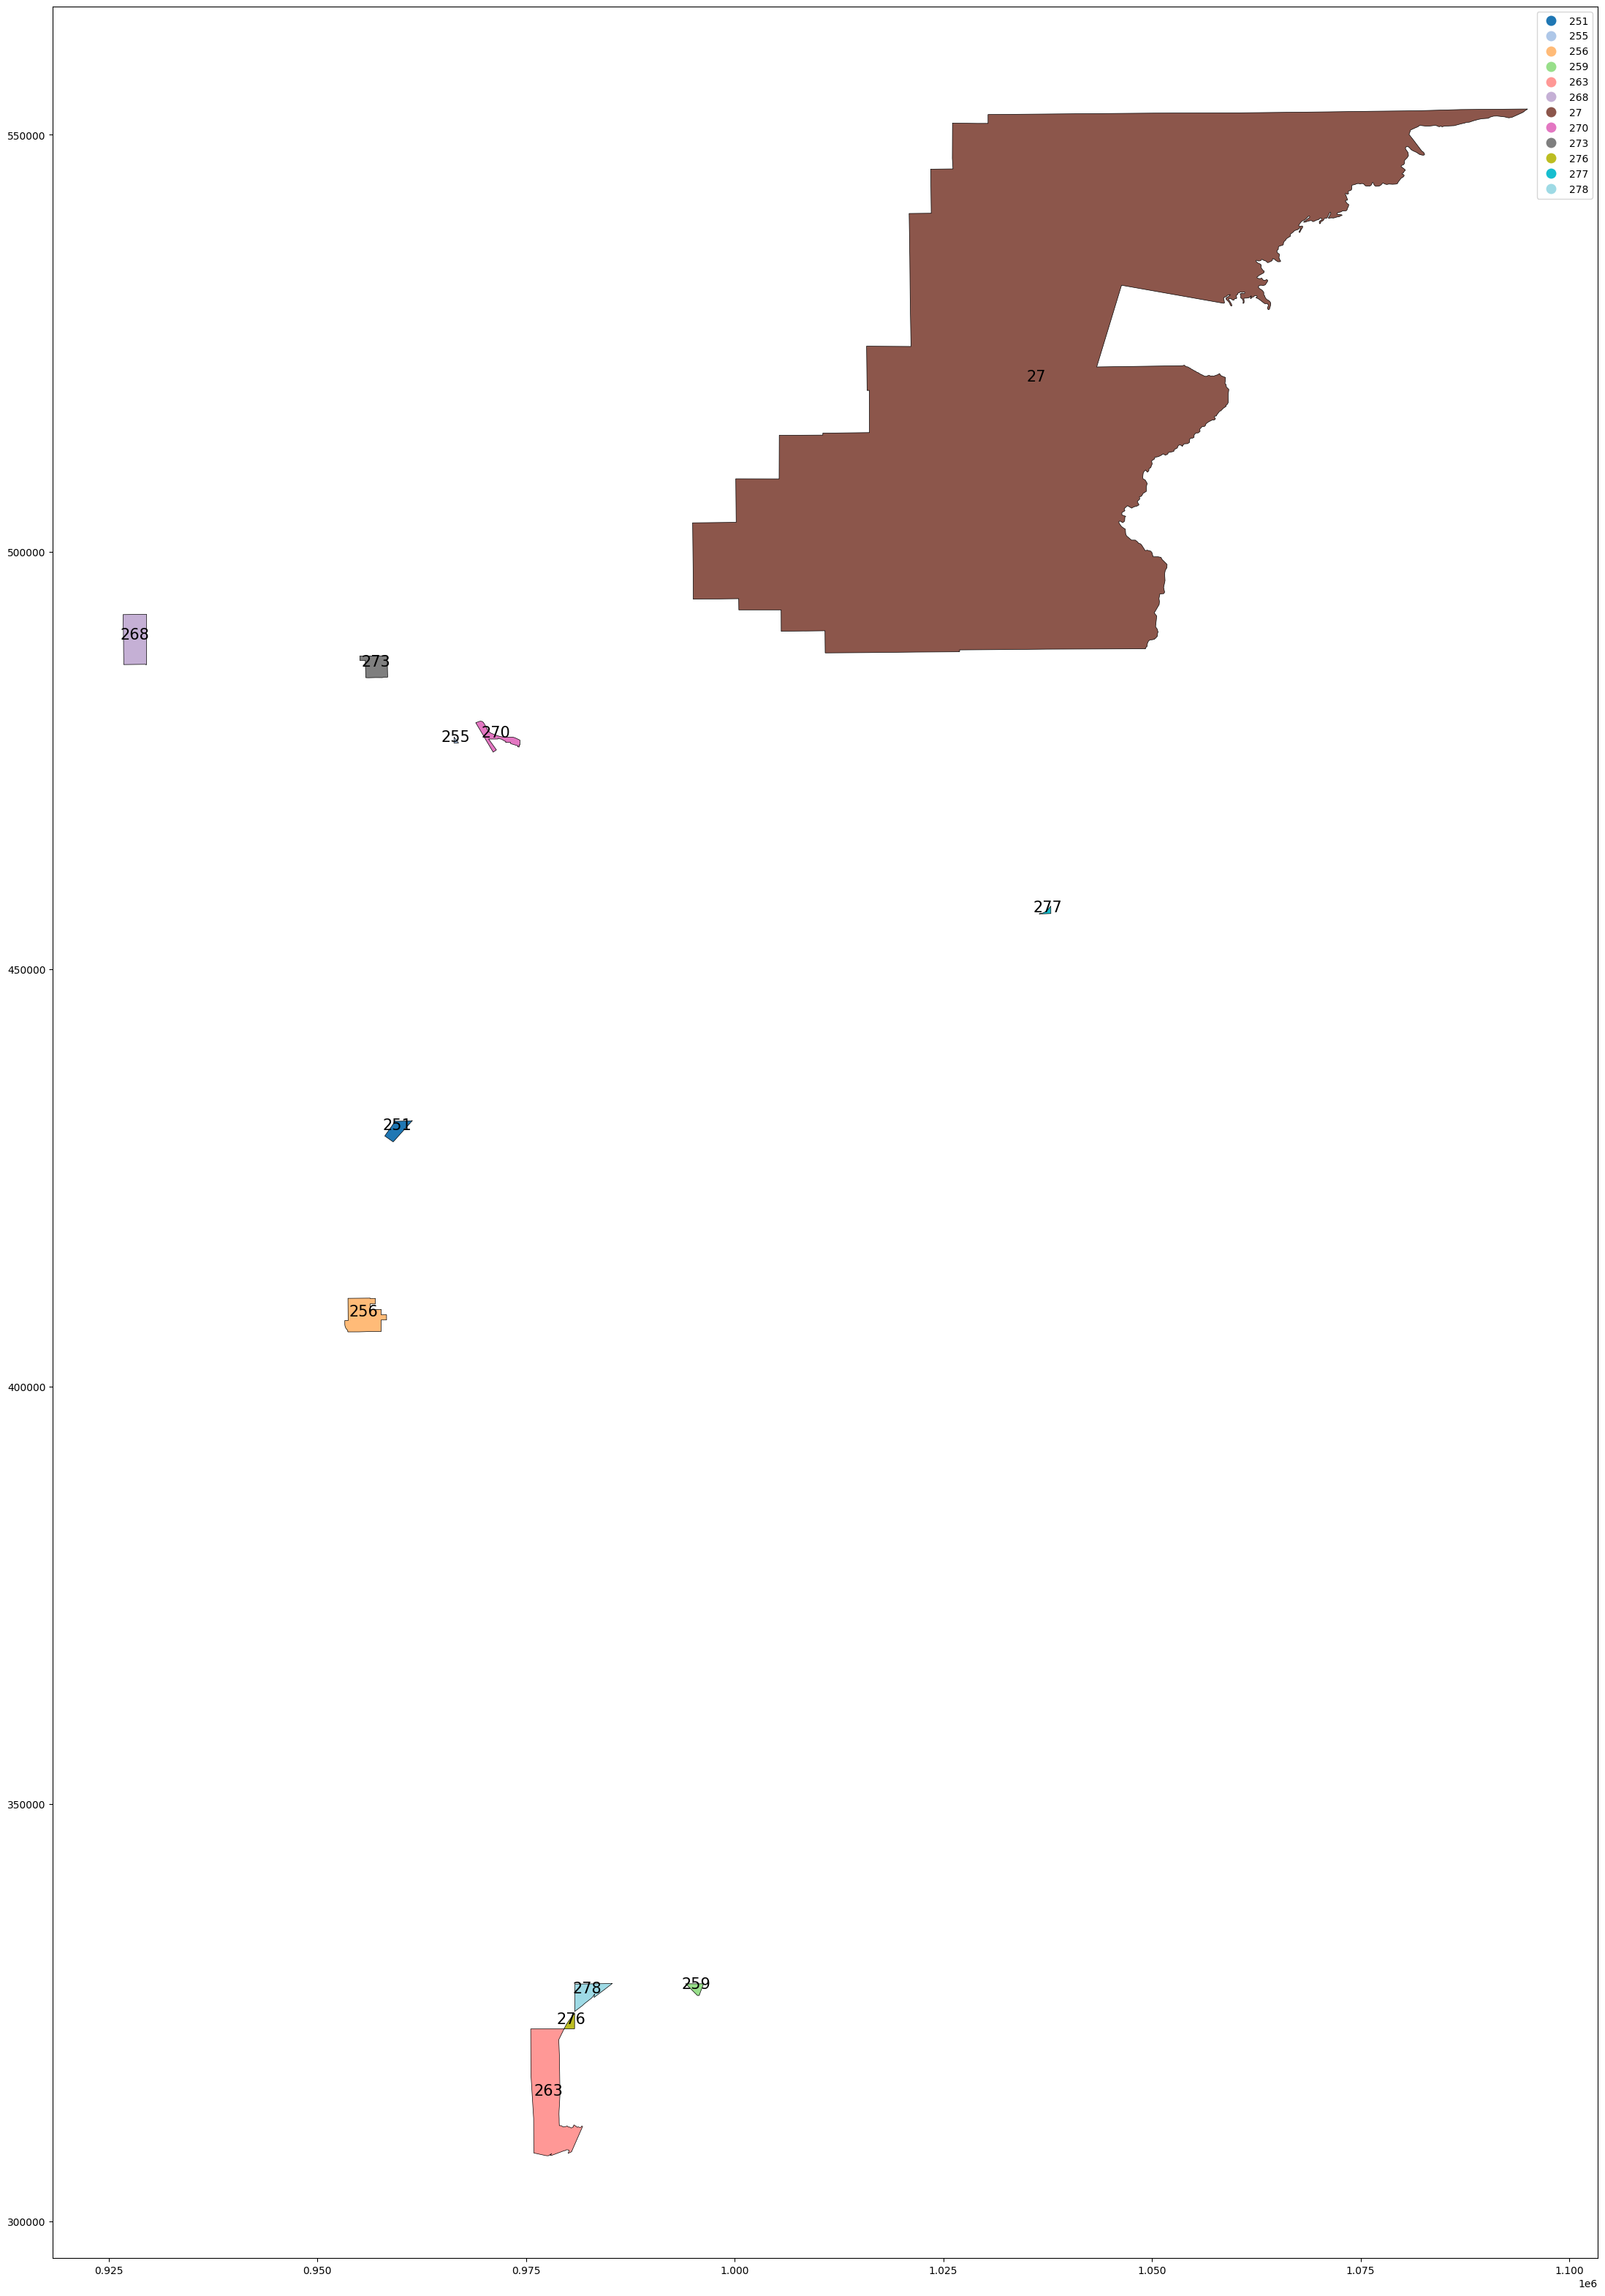

In [1005]:
both = gdf_Pima_final[gdf_Pima_final['_merge']=='both']
print(len(both))
left_only = gdf_Pima_final[gdf_Pima_final['_merge']=='left_only']
print(len(left_only))
right_only = gdf_Pima_final[gdf_Pima_final['_merge']=='right_only']
print(len(right_only))
print(list(right_only['PRECINCT']))
print(len(list(right_only['PRECINCT'])))
right_only_org = gdf_Pima[gdf_Pima['PRECINCT'].isin(list(right_only['PRECINCT']))]
plot_precincts(right_only_org, 'PRECINCT')
right_only_org.to_file('pima.geojson', driver='GeoJSON')

In [1006]:
right_only_org.to_file('maricopa.geojson', driver='GeoJSON')

In [1007]:
check_precinct_districts(gdf_Pima_final)


Row 1:
  Column: GUSH07DGRI, Office Type: USH, District: 07, Value: 565.0
  Column: GUSH07OWRI, Office Type: USH, District: 07, Value: 1.0
  Column: GUSH07RPOZ, Office Type: USH, District: 07, Value: 461.0
  Column: GSL23DJR., Office Type: SL, District: 23, Value: 417.0
  Column: GSL23DSAN, Office Type: SL, District: 23, Value: 527.0
  Column: GSL23RPEN, Office Type: SL, District: 23, Value: 466.0
  Column: GSU23DFER, Office Type: SU, District: 23, Value: 540.0
  Column: GSU23RSNY, Office Type: SU, District: 23, Value: 466.0
  Column: GSL23OWRI, Office Type: SL, District: 23, Value: 10.0
  Column: GSU23OWRI, Office Type: SU, District: 23, Value: 3.0


Row 2:
  Column: GUSH07DGRI, Office Type: USH, District: 07, Value: 79.0
  Column: GUSH07RPOZ, Office Type: USH, District: 07, Value: 75.0
  Column: GSL23DJR., Office Type: SL, District: 23, Value: 45.0
  Column: GSL23DSAN, Office Type: SL, District: 23, Value: 85.0
  Column: GSL23RPEN, Office Type: SL, District: 23, Value: 72.0
  Column:

In [1008]:
gdf_Pima_final.head(5)

county precinct  ...                                           geometry  _merge
0   Pima        1  ...  POLYGON ((392000.656 548882.438, 397280.781 54...    both
1   Pima        2  ...  POLYGON ((386927.594 548935.500, 386895.594 54...    both
2   Pima        3  ...  POLYGON ((804278.997 517541.315, 804331.125 51...    both
3   Pima        4  ...  POLYGON ((716837.313 363583.563, 716956.500 36...    both
4   Pima        5  ...  POLYGON ((807097.997 548213.875, 807096.305 54...    both

[5 rows x 265 columns]

In [1009]:

gdf_Pima_final = gdf_Pima_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Pima_final['UNIQUE_ID'] = gdf_Pima_final['PRECINCT']
gdf_Pima_final['PCTNUM'] = gdf_Pima_final['PRECINCT']
gdf_Pima_final['PRECINCTNA'] = np.nan

gdf_Pima_final.drop(columns=['_merge'], inplace=True)
gdf_Pima_final.drop(columns=['precinct'], inplace=True)
gdf_Pima_final.drop(columns=['PRECINCT'], inplace=True)




gdf_Pima_final['COUNTYFP'] = '019'
gdf_Pima_final['COUNTY_NAM'] = 'Pima'



cols = gdf_Pima_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Pima_final = gdf_Pima_final[cols]

gdf_Pima_final = add_districts_numbers(gdf_Pima_final)


gdf_Pima_final.head(5)


UNIQUE_ID  ...                                           geometry
0         1  ...  POLYGON ((392000.656 548882.438, 397280.781 54...
1         2  ...  POLYGON ((386927.594 548935.500, 386895.594 54...
2         3  ...  POLYGON ((804278.997 517541.315, 804331.125 51...
3         4  ...  POLYGON ((716837.313 363583.563, 716956.500 36...
4         5  ...  POLYGON ((807097.997 548213.875, 807096.305 54...

[5 rows x 269 columns]

### Pinal County

In [1010]:
# Read the shapefile
shapefile_path_Pinal = './precinct_boundaries/Pinal/Voter_Precincts.shp'
gdf_Pinal = gpd.read_file(shapefile_path_Pinal)
gdf_Pinal

NAME  ...                                           geometry
0             SADDLEBROOKE WEST  ...  POLYGON ((1019843.122 571500.041, 1019933.998 ...
1                  ARIZONA CITY  ...  POLYGON ((775484.848 641395.974, 775485.789 64...
2                  TOLTEC SOUTH  ...  POLYGON ((778154.262 641392.816, 778222.812 64...
3                          ELOY  ...  POLYGON ((809957.929 652151.840, 810227.442 65...
4                    ELOY SOUTH  ...  POLYGON ((817946.652 631845.463, 817946.544 63...
5                   COOLIDGE NE  ...  POLYGON ((835915.514 734712.363, 835899.165 73...
6                   COOLIDGE NW  ...  POLYGON ((810989.210 736452.407, 811537.338 73...
7                COOLIDGE SOUTH  ...  POLYGON ((836008.173 718112.856, 836014.738 71...
8                      RANDOLPH  ...  POLYGON ((833866.935 686621.406, 833867.058 68...
..                          ...  ...                                                ...
100  APACHE JUNCTION N. CENTRAL  ...  POLYGON ((834149.289 887802.937, 834073.361 88...
101       APACHE JUNCTION NORTH  ...  POLYGON ((807769.510 886646.799, 807772.151 88...
102             FLORENCE ANTHEM  ...  POLYGON ((841010.930 760408.455, 841016.674 75...
103            RANCHO EL DORADO  ...  POLYGON ((670357.403 754175.121, 670457.326 75...
104                     TORTOSA  ...  POLYGON ((696669.045 739423.680, 696652.132 73...
105            TOLTEC SOUTHWEST  ...  POLYGON ((763496.404 667875.632, 763497.669 66...
106               SCHNEPF NORTH  ...  POLYGON ((825515.867 813735.042, 825481.909 81...
107               PICACHO SOUTH  ...  POLYGON ((792502.318 622948.038, 792480.174 62...
108             SUNLAND RANCHES  ...  POLYGON ((802717.884 641497.820, 803000.387 64...

[109 rows x 5 columns]

In [1011]:
# Get unique values in the 'precinct' column
unique_name = gdf_Pinal['NAME'].unique()

# Sort the unique values in alphabetical order
unique_name_sorted = sorted(unique_name)
print(len(unique_name_sorted))

# Print each unique value line by line
for precinct in unique_name_sorted:
    print(precinct)

109
AK CHIN COMMUNITY
ALTERRA NORTH
APACHE JCT CENTRAL
APACHE JCT EAST
APACHE JCT NE
APACHE JCT NW
APACHE JCT SE
APACHE JCT SW
APACHE JUNCTION E. CENTRAL
APACHE JUNCTION N. CENTRAL
APACHE JUNCTION NORTH
APACHE JUNCTION SOUTH
APACHE JUNCTION SUPERSTITION
APACHE TRAIL
ARIZONA CITY
BELLA VISTA
BLACKWATER
CACTUS FOREST
CASA BLANCA
CASA GRANDE COWTOWN
CASA GRANDE INTERCHANGE
CASA GRANDE N CENTRAL
CASA GRANDE NE
CASA GRANDE NW
CASA GRANDE RANCHO GRANDE
CASA GRANDE S CENTRAL
CASA GRANDE SE
CASA GRANDE SW
CASA GRANDE WEST
CENTRAL ARIZONA COLLEGE
CHUI CHU
CIRCLE CROSS RANCH
COOLIDGE NE
COOLIDGE NW
COOLIDGE SOUTH
COPPER BASIN
COPPER BASIN SOUTHEAST
COYOTE RANCH
CRUZ PARK
DESERT CEDARS
DUDLEYVILLE
EAGLE CREST
EL DORADO
ELEVEN MILE CORNER
ELOY
ELOY SOUTH
FLORENCE ANTHEM
FLORENCE NORTH
FLORENCE SOUTH
GOLD CANYON
GOLD CANYON NORTH
HIDDEN VALLEY
IRONWOOD COMMON
IRONWOOD CROSSING EAST
IRONWOOD CROSSING WEST
JOHNSON RANCH
JOHNSON RANCH EAST
KEARNY
LINKS ESTATES
MAMMOTH
MARICOPA
MARICOPA FIESTA
MARICOPA

In [1012]:
pinal_rows = final_df[final_df['county'].str.lower() == 'pinal']
def extract_precinct_num(precinct):
    # Extract the numeric part at the beginning
    match = re.match(r'^\d+', precinct)
    return match.group(0) if match else None

def extract_precinct_name(precinct):
    # Extract the name part after the number
    match = re.match(r'^\d+\s+(.*)$', precinct)
    return match.group(1).strip() if match else None

# Apply the functions to create the new columns
pinal_rows['PCTNUM'] = pinal_rows['precinct'].apply(extract_precinct_num)
pinal_rows['PRECINCTNA'] = pinal_rows['precinct'].apply(extract_precinct_name)
pinal_rows['UNIQUE_ID'] = pinal_rows['precinct']
pinal_rows['precinct'] = pinal_rows['precinct'].str[3:].str.upper()
pinal_rows

county  ...                   UNIQUE_ID
0    Pinal  ...                   01 Kearny
1    Pinal  ...              04 Dudleyville
2    Pinal  ...               05 San Manuel
3    Pinal  ...                  06 Mammoth
4    Pinal  ...                   07 Oracle
5    Pinal  ...        08 Saddlebrooke West
6    Pinal  ...             09 Arizona City
7    Pinal  ...             10 Toltec South
8    Pinal  ...                  11 Picacho
..     ...  ...                         ...
99   Pinal  ...     107 Casa Grande Cowtown
100  Pinal  ...  108 Ironwood Crossing East
101  Pinal  ...         109 Florence Anthem
102  Pinal  ...        110 Rancho El Dorado
103  Pinal  ...                 111 Tortosa
104  Pinal  ...         112 Sunland Ranches
105  Pinal  ...           113 Schnepf South
106  Pinal  ...            51 Superior West
107  Pinal  ...             89 Quail Hollow

[108 rows x 265 columns]

There are 5 precincts that do not match, 4 of them are minor name differences and 1 is no vote precint. eg. Apache Junction Shouth -> Apache JCT South. And SAN CARLOS COMMUNITY in the shapefile does not match with any election precincts, which I still include by filled it with null values.

In [1064]:
value_mapping = {
    'APACHE JCT SOUTH': 'APACHE JUNCTION SOUTH',
    'APACHE JCT SUPERSTITION': 'APACHE JUNCTION SUPERSTITION',
    'COYOTE': 'COYOTE RANCH',
    'SADDLEBROOKE RANCHE': 'SADDLEBROOKE RANCH'
}

pinal_rows['precinct'] = pinal_rows['precinct'].replace(value_mapping)

In [1065]:
pinal_rows['precinct'] = pinal_rows['precinct'].str.strip()
unique_precincts = pinal_rows['precinct'].unique()

# Sort the unique values in alphabetical order
unique_precincts_sorted = sorted(unique_precincts)
print(len(unique_precincts_sorted))

# Print each unique value line by line
for precinct in unique_precincts_sorted:
    print(precinct)

108
AK CHIN COMMUNITY
ALTERRA NORTH
APACHE JCT CENTRAL
APACHE JCT EAST
APACHE JCT NE
APACHE JCT NW
APACHE JCT SE
APACHE JCT SW
APACHE JUNCTION E. CENTRAL
APACHE JUNCTION N. CENTRAL
APACHE JUNCTION NORTH
APACHE JUNCTION SOUTH
APACHE JUNCTION SUPERSTITION
APACHE TRAIL
ARIZONA CITY
BELLA VISTA
BLACKWATER
CACTUS FOREST
CASA BLANCA
CASA GRANDE COWTOWN
CASA GRANDE INTERCHANGE
CASA GRANDE N CENTRAL
CASA GRANDE NE
CASA GRANDE NW
CASA GRANDE RANCHO GRANDE
CASA GRANDE S CENTRAL
CASA GRANDE SE
CASA GRANDE SW
CASA GRANDE WEST
CENTRAL ARIZONA COLLEGE
CHUI CHU
CIRCLE CROSS RANCH
COOLIDGE NE
COOLIDGE NW
COOLIDGE SOUTH
COPPER BASIN
COPPER BASIN SOUTHEAST
COYOTE RANCH
CRUZ PARK
DESERT CEDARS
DUDLEYVILLE
EAGLE CREST
EL DORADO
ELEVEN MILE CORNER
ELOY
ELOY SOUTH
FLORENCE ANTHEM
FLORENCE NORTH
FLORENCE SOUTH
GOLD CANYON
GOLD CANYON NORTH
HIDDEN VALLEY
IRONWOOD COMMON
IRONWOOD CROSSING EAST
IRONWOOD CROSSING WEST
JOHNSON RANCH
JOHNSON RANCH EAST
KEARNY
LINKS ESTATES
MAMMOTH
MARICOPA
MARICOPA FIESTA
MARICOPA

In [1066]:
# Perform the right merge to keep all geometries from gdf_Pinal
gdf_Pinal_final = pinal_rows.merge(
    gdf_Pinal[['NAME', 'geometry', 'Precinct']], 
    left_on='precinct', 
    right_on='NAME', 
    how='outer',
    indicator=True
)


# gdf_Pinal_final = gdf_Pinal_final.drop(columns=['NAME'])

# Convert the merged DataFrame to a GeoDataFrame
gdf_Pinal_final = gpd.GeoDataFrame(gdf_Pinal_final, geometry='geometry')


# Plot the precincts with labels
# plot_precincts(gdf_Pinal_final, 'NAME')


In [1067]:
check_precinct_districts(gdf_Pinal_final)


Row 1:
  Column: GSL07OWRI, Office Type: SL, District: 07, Value: 11.0
  Column: GSL07RCOO, Office Type: SL, District: 07, Value: 502.0
  Column: GSL07RSR., Office Type: SL, District: 07, Value: 341.0
  Column: GSU07DNIT, Office Type: SU, District: 07, Value: 338.0
  Column: GSU07OWRI, Office Type: SU, District: 07, Value: 2.0
  Column: GSU07RROG, Office Type: SU, District: 07, Value: 442.0
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 366.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 410.0


Row 2:
  Column: GSL07OWRI, Office Type: SL, District: 07, Value: 9.0
  Column: GSL07RCOO, Office Type: SL, District: 07, Value: 170.0
  Column: GSL07RSR., Office Type: SL, District: 07, Value: 149.0
  Column: GSU07DNIT, Office Type: SU, District: 07, Value: 206.0
  Column: GSU07OWRI, Office Type: SU, District: 07, Value: 2.0
  Column: GSU07RROG, Office Type: SU, District: 07, Value: 154.0
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 220.0
  Column: 

In [1068]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Pinal_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          108
right_only      1
left_only       0
Name: count, dtype: int64


In [1069]:
both = gdf_Pinal_final[gdf_Pinal_final['_merge']=='both']
print(len(both))
left_only = gdf_Pinal_final[gdf_Pinal_final['_merge']=='left_only']
print(len(left_only))
right_only = gdf_Pinal_final[gdf_Pinal_final['_merge']=='right_only']
# print(len(right_only))
print(list(right_only['NAME']))
print(list(left_only['precinct']))

# print(len(list(right_only['NAME'])))
# right_only_org = gdf_Pima[gdf_Pima['PRECINCT'].isin(list(right_only['PRECINCT']))]
# plot_precincts(right_only_org, 'PRECINCT')
# right_only_org.to_file('pima.geojson', driver='GeoJSON')

108
0
['SAN CARLOS COMMUNITY']
[]


In [1070]:
gdf_Pinal_final.head(5)

county     precinct  ...  Precinct  _merge
0  Pinal       KEARNY  ...        01    both
1  Pinal  DUDLEYVILLE  ...        04    both
2  Pinal   SAN MANUEL  ...        05    both
3  Pinal      MAMMOTH  ...        06    both
4  Pinal       ORACLE  ...        07    both

[5 rows x 269 columns]

In [1071]:

gdf_Pinal_final = gdf_Pinal_final.rename(columns={'county': 'COUNTY_NAM'})



gdf_Pinal_final['PRECINCTNA'] = gdf_Pinal_final['NAME']
gdf_Pinal_final['UNIQUE_ID'] = gdf_Pinal_final['NAME']

gdf_Pinal_final.drop(columns=['_merge'], inplace=True)
gdf_Pinal_final.drop(columns=['precinct'], inplace=True)
gdf_Pinal_final.drop(columns=['NAME'], inplace=True)
gdf_Pinal_final.drop(columns=['Precinct'], inplace=True)


gdf_Pinal_final['COUNTYFP'] = '021'
gdf_Pinal_final['COUNTY_NAM'] = 'Pinal'



cols = gdf_Pinal_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Pinal_final = gdf_Pinal_final[cols]

gdf_Pinal_final = add_districts_numbers(gdf_Pinal_final)


gdf_Pinal_final.head(5)


UNIQUE_ID  ...                                           geometry
0       KEARNY  ...  POLYGON ((1044976.573 720060.366, 1044983.528 ...
1  DUDLEYVILLE  ...  POLYGON ((1070748.117 759932.170, 1070777.541 ...
2   SAN MANUEL  ...  POLYGON ((1078651.552 552904.147, 1078613.466 ...
3      MAMMOTH  ...  POLYGON ((1062602.362 615521.989, 1062204.233 ...
4       ORACLE  ...  POLYGON ((927054.921 650873.771, 927877.664 65...

[5 rows x 269 columns]

### Santa Cruz County

In [1072]:
santa_cruz_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Santa Cruz']
santa_cruz_2020

geometry  ... SLDU_DIST
151  POLYGON ((-110.96378 31.42331, -110.96373 31.4...  ...        02
152  POLYGON ((-110.45992 31.43720, -110.45992 31.4...  ...        02
153  POLYGON ((-110.93343 31.60516, -110.93339 31.6...  ...        02
154  POLYGON ((-111.06336 31.56155, -111.06344 31.5...  ...        02
155  POLYGON ((-110.89066 31.33317, -110.89065 31.3...  ...        02
156  POLYGON ((-110.92082 31.59408, -110.92098 31.5...  ...        02
157  POLYGON ((-110.65079 31.59613, -110.65200 31.5...  ...        02
158  POLYGON ((-110.99239 31.46223, -110.99132 31.4...  ...        02
159  POLYGON ((-110.96378 31.42331, -110.96398 31.4...  ...        02
..                                                 ...  ...       ...
426  POLYGON ((-110.91651 31.34436, -110.91661 31.3...  ...        02
427  POLYGON ((-110.93034 31.35776, -110.93035 31.3...  ...        02
428  POLYGON ((-110.91830 31.35568, -110.91777 31.3...  ...        02
429  POLYGON ((-110.95964 31.37587, -110.95942 31.3...  ...        02
430  POLYGON ((-110.93655 31.34073, -110.93672 31.3...  ...        02
431  POLYGON ((-110.94017 31.34841, -110.94030 31.3...  ...        02
432  POLYGON ((-110.91651 31.34436, -110.91649 31.3...  ...        02
433  POLYGON ((-110.93176 31.34342, -110.93186 31.3...  ...        02
434  POLYGON ((-110.95961 31.39197, -110.95980 31.3...  ...        02

[24 rows x 10 columns]

In [1073]:
santa_cruz_rows = final_df[final_df['county'].str.lower() == 'santa cruz']
santa_cruz_rows

county  ... G22USSWROX
152  Santa Cruz  ...        NaN
153  Santa Cruz  ...        NaN
154  Santa Cruz  ...        NaN
155  Santa Cruz  ...        NaN
156  Santa Cruz  ...        NaN
157  Santa Cruz  ...        NaN
158  Santa Cruz  ...        NaN
159  Santa Cruz  ...        NaN
160  Santa Cruz  ...        NaN
..          ...  ...        ...
178  Santa Cruz  ...        NaN
179  Santa Cruz  ...        NaN
180  Santa Cruz  ...        NaN
181  Santa Cruz  ...        NaN
182  Santa Cruz  ...        NaN
183  Santa Cruz  ...        NaN
184  Santa Cruz  ...        NaN
185  Santa Cruz  ...        NaN
186  Santa Cruz  ...        NaN

[35 rows x 262 columns]

In [1074]:
santa_cruz_rows = final_df[final_df['county'].str.lower() == 'santa cruz']
display(santa_cruz_rows.sort_values(by='precinct',inplace=True))
# After checking multiple sources, the election result marked Calabas as 16 and 17 but instead there is only 1 Calabas precinct. So drop it:
santa_cruz_rows = santa_cruz_rows[santa_cruz_rows['precinct'] != 'Calabasas 16']

# Also, Beca 19.6 should be Beca 19 19.6 for consistency
santa_cruz_rows.loc[santa_cruz_rows['precinct'] == 'Baca 19.6', 'precinct'] = 'Baca 19 19.6'
santa_cruz_rows['precinct'] = santa_cruz_rows['precinct'].str.replace('Peck Canyon 12 21.3', 'Peck Canyon 21 21.3')

santa_cruz_rows

None

county                      precinct  ...  G22GOVWCAM  G22USSWROX
179  Santa Cruz             Baca 19 19.1/19.7  ...         NaN         NaN
178  Santa Cruz   Baca 19 19.2/19.3/19.4/19.5  ...         NaN         NaN
177  Santa Cruz                  Baca 19 19.6  ...         NaN         NaN
182  Santa Cruz        Calabasas 17 17.2/17.3  ...         NaN         NaN
181  Santa Cruz             Calabasas 17 17.4  ...         NaN         NaN
156  Santa Cruz               Coronado 5 05.1  ...         NaN         NaN
157  Santa Cruz     Coronado 5 05.2/05.3/05.5  ...         NaN         NaN
158  Santa Cruz               Coronado 5 05.4  ...         NaN         NaN
159  Santa Cruz                       Elgin 6  ...         NaN         NaN
..          ...                           ...  ...         ...         ...
175  Santa Cruz      Peck Canyon 21 21.1/21.2  ...         NaN         NaN
173  Santa Cruz                    Potrero 22  ...         NaN         NaN
160  Santa Cruz     Rio Rico 7 07.1/07.3/07.4  ...         NaN         NaN
161  Santa Cruz          Rio Rico 7 07.2/07.5  ...         NaN         NaN
168  Santa Cruz            Santa Cruz 13 13.1  ...         NaN         NaN
169  Santa Cruz  Santa Cruz 13 13.2/13.3/13.4  ...         NaN         NaN
185  Santa Cruz                    Sonoita 15  ...         NaN         NaN
165  Santa Cruz            Tubac 11 11.1/11.3  ...         NaN         NaN
166  Santa Cruz            Tubac 11 11.2/11.4  ...         NaN         NaN

[34 rows x 262 columns]

In [1075]:
# Convert 'votes' to numeric (if not already numeric)
# santa_cruz_rows['votes'] = pd.to_numeric(santa_cruz_rows['votes'], errors='coerce')

# Extract the base precinct name (e.g., "Peck Canyon 21" or "Baca 19")
santa_cruz_rows['base_precinct'] = santa_cruz_rows['precinct'].str.extract(r'([A-Za-z\s]+\d+)')

# Identify columns that start with 'G'
columns_starting_with_G = [col for col in santa_cruz_rows.columns if col.startswith('G')]

# Group by the base precinct name and sum the 'G' columns
santa_cruz_rows_grouped = santa_cruz_rows.groupby('base_precinct')[columns_starting_with_G].sum().reset_index()

# Display the grouped DataFrame
santa_cruz_rows_grouped

base_precinct  G22ATGDMAY  ...  G22GOVWCAM  G22USSWROX
0             Baca 19       736.0  ...         0.0         0.0
1        Calabasas 17       896.0  ...         0.0         0.0
2          Coronado 5       402.0  ...         0.0         0.0
3             Elgin 6       194.0  ...         0.0         0.0
4   Lake Patagonia 24        66.0  ...         0.0         0.0
5         Mountain 23        22.0  ...         0.0         0.0
6           Nogales 1       170.0  ...         0.0         0.0
7          Nogales 10       290.0  ...         0.0         0.0
8          Nogales 12       163.0  ...         0.0         0.0
..                ...         ...  ...         ...         ...
15          Nogales 8       636.0  ...         0.0         0.0
16          Nogales 9       102.0  ...         0.0         0.0
17       Patagonia 14       431.0  ...         0.0         0.0
18     Peck Canyon 21       595.0  ...         0.0         0.0
19         Potrero 22       150.0  ...         0.0         0.0
20         Rio Rico 7      1150.0  ...         0.0         0.0
21      Santa Cruz 13       139.0  ...         0.0         0.0
22         Sonoita 15       264.0  ...         0.0         0.0
23           Tubac 11       929.0  ...         0.0         0.0

[24 rows x 261 columns]

In [1076]:
santa_cruz_rows_grouped

base_precinct  G22ATGDMAY  ...  G22GOVWCAM  G22USSWROX
0             Baca 19       736.0  ...         0.0         0.0
1        Calabasas 17       896.0  ...         0.0         0.0
2          Coronado 5       402.0  ...         0.0         0.0
3             Elgin 6       194.0  ...         0.0         0.0
4   Lake Patagonia 24        66.0  ...         0.0         0.0
5         Mountain 23        22.0  ...         0.0         0.0
6           Nogales 1       170.0  ...         0.0         0.0
7          Nogales 10       290.0  ...         0.0         0.0
8          Nogales 12       163.0  ...         0.0         0.0
..                ...         ...  ...         ...         ...
15          Nogales 8       636.0  ...         0.0         0.0
16          Nogales 9       102.0  ...         0.0         0.0
17       Patagonia 14       431.0  ...         0.0         0.0
18     Peck Canyon 21       595.0  ...         0.0         0.0
19         Potrero 22       150.0  ...         0.0         0.0
20         Rio Rico 7      1150.0  ...         0.0         0.0
21      Santa Cruz 13       139.0  ...         0.0         0.0
22         Sonoita 15       264.0  ...         0.0         0.0
23           Tubac 11       929.0  ...         0.0         0.0

[24 rows x 261 columns]

In [1077]:
santa_cruz_2020 = santa_cruz_2020.sort_values(by='PRECINCTNA')
santa_cruz_2020

geometry  ... SLDU_DIST
159  POLYGON ((-110.96378 31.42331, -110.96398 31.4...  ...        02
158  POLYGON ((-110.99239 31.46223, -110.99132 31.4...  ...        02
151  POLYGON ((-110.96378 31.42331, -110.96373 31.4...  ...        02
152  POLYGON ((-110.45992 31.43720, -110.45992 31.4...  ...        02
228  POLYGON ((-110.92082 31.59408, -110.92070 31.5...  ...        02
161  POLYGON ((-110.45988 31.37824, -110.45987 31.3...  ...        02
423  POLYGON ((-110.94676 31.34207, -110.94702 31.3...  ...        02
429  POLYGON ((-110.95964 31.37587, -110.95942 31.3...  ...        02
430  POLYGON ((-110.93655 31.34073, -110.93672 31.3...  ...        02
..                                                 ...  ...       ...
427  POLYGON ((-110.93034 31.35776, -110.93035 31.3...  ...        02
428  POLYGON ((-110.91830 31.35568, -110.91777 31.3...  ...        02
156  POLYGON ((-110.92082 31.59408, -110.92098 31.5...  ...        02
160  POLYGON ((-111.04269 31.54323, -111.04252 31.5...  ...        02
434  POLYGON ((-110.95961 31.39197, -110.95980 31.3...  ...        02
153  POLYGON ((-110.93343 31.60516, -110.93339 31.6...  ...        02
155  POLYGON ((-110.89066 31.33317, -110.89065 31.3...  ...        02
157  POLYGON ((-110.65079 31.59613, -110.65200 31.5...  ...        02
154  POLYGON ((-111.06336 31.56155, -111.06344 31.5...  ...        02

[24 rows x 10 columns]

In [1078]:



# def simplify_precinct_grouped(precinct):
#     parts = precinct.split()
#     if len(parts) > 1:
#         return ' '.join(parts[:2])
#     return precinct

# # Apply the function to the 'precinct' column
# santa_cruz_rows['precinct'] = santa_cruz_rows['precinct'].apply(simplify_precinct_grouped)

# mapping = {
#     'Peck Canyon': 'Peck Canyon 21', 
#     'Rio Rico': 'Rio Rico 7',
#     'Santa Cruz': 'Santa Cruz 13',
#     'Lake Patagonia': 'Lake Patagonia 24',
# }
# santa_cruz_rows['precinct'] = santa_cruz_rows['precinct'].replace(mapping)
# santa_cruz_rows['UNIQUE_ID'] = santa_cruz_rows['precinct']

# def extract_precinct_name(precinct):
#     # Extract the name part before the number
#     match = re.match(r'^(.*?)(?:\s+\d+)?$', precinct)
#     return match.group(1).strip() if match else None

# def extract_precinct_num(precinct):
#     # Extract the numeric part at the end
#     match = re.search(r'\d+$', precinct)
#     return match.group(0) if match else None

# # Apply the functions to create the new columns
# santa_cruz_rows['PRECINCTNA'] = santa_cruz_rows['precinct'].apply(extract_precinct_name)
# santa_cruz_rows['PCTNUM'] = santa_cruz_rows['precinct'].apply(extract_precinct_num)
# santa_cruz_rows


# # # Display the final DataFrame
# # print(len(grouped_df))
# # sorted(grouped_df['precinct'])

In [1079]:
# Merge the dataframes on UNIQUE_ID and precinct
gdf_Santa_Cruz_final = santa_cruz_rows_grouped.merge(santa_cruz_2020[['PRECINCTNA', 'geometry']], 
                                       left_on='base_precinct', 
                                       right_on='PRECINCTNA', 
                                       how='outer',
                                       indicator=True)

# , 'CON_DIST',	'SLDL_DIST',	'SLDU_DIST'
# # Drop the duplicate UNIQUE_ID column from the merged DataFrame
# gdf_Santa_Cruz_final = gdf_Santa_Cruz_final.drop(columns=['PRECINCTNA'])


gdf_Santa_Cruz_final = gpd.GeoDataFrame(gdf_Santa_Cruz_final, geometry='geometry')

# plot_precincts_with_labels(gdf_Santa_Cruz_final)


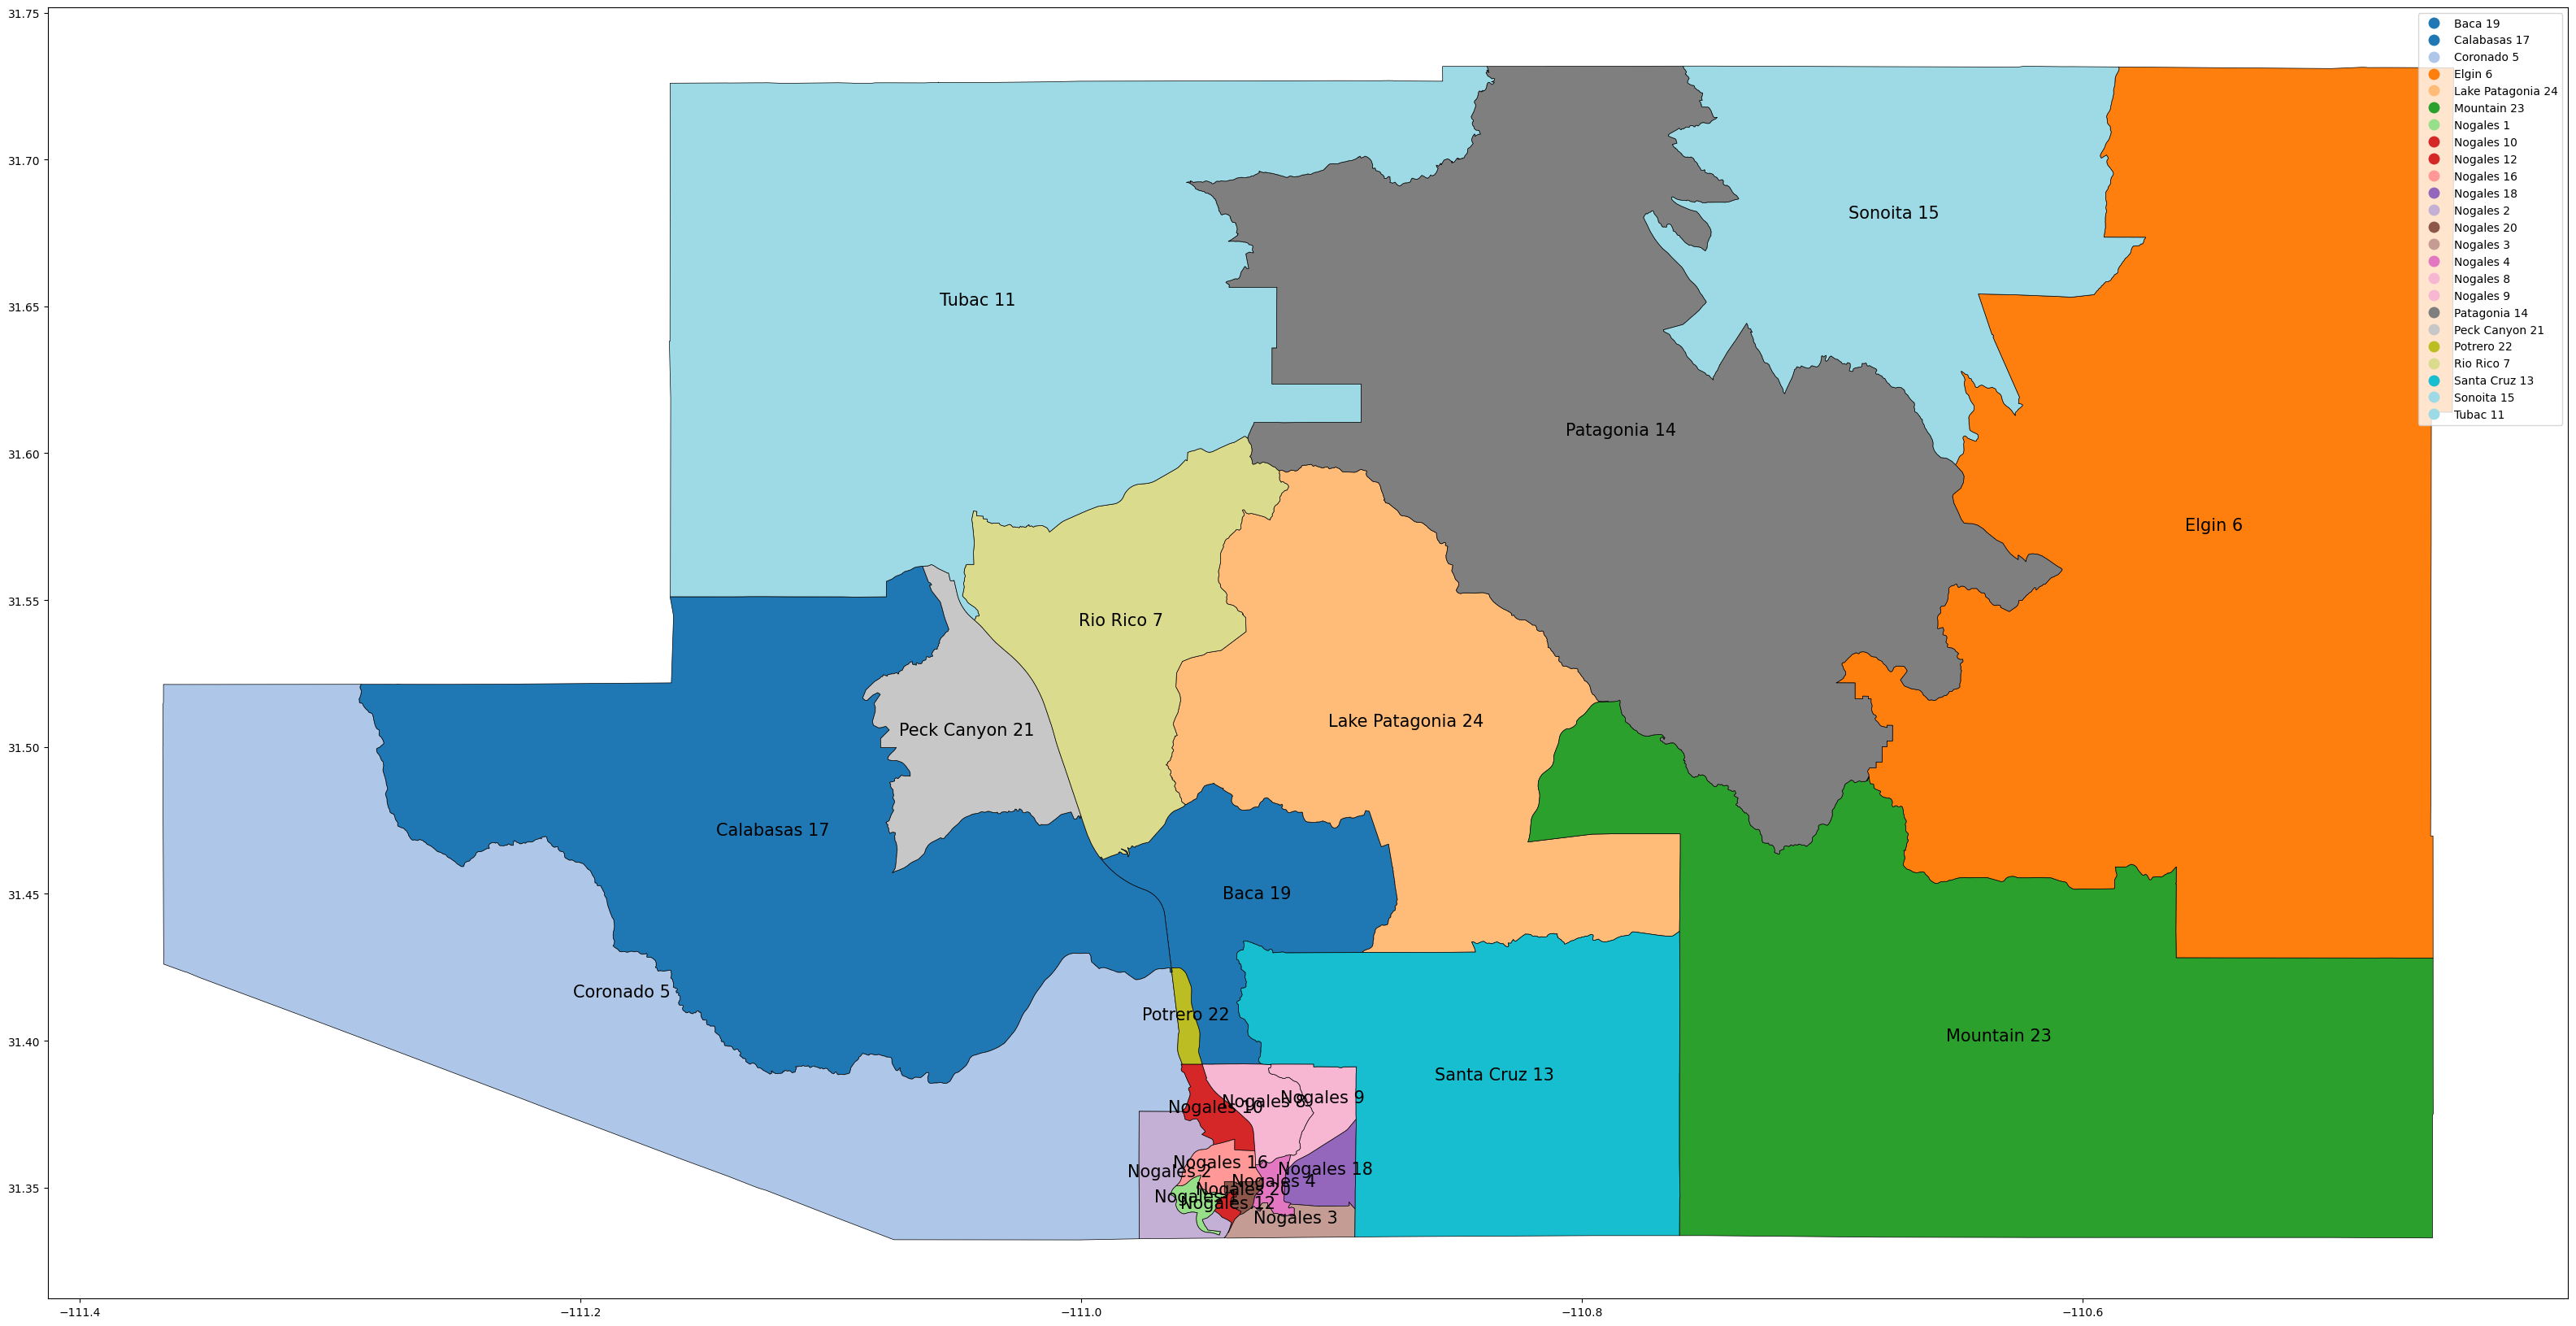

In [1080]:
plot_precincts(gdf_Santa_Cruz_final, 'base_precinct')

In [1081]:
check_precinct_districts(gdf_Santa_Cruz_final)


Row 1:
  Column: GUSH07DGRI, Office Type: USH, District: 07, Value: 2.0
  Column: GSL21DHAM, Office Type: SL, District: 21, Value: 472.0
  Column: GSL21DHER, Office Type: SL, District: 21, Value: 682.0
  Column: GSL21RKEN, Office Type: SL, District: 21, Value: 257.0
  Column: GSL21RMCE, Office Type: SL, District: 21, Value: 235.0
  Column: GSU21DGAB, Office Type: SU, District: 21, Value: 751.0
  Column: GSU21RCLE, Office Type: SU, District: 21, Value: 272.0


Row 2:
  Column: GUSH07DGRI, Office Type: USH, District: 07, Value: 851.0
  Column: GUSH07OWRI, Office Type: USH, District: 07, Value: 1.0
  Column: GUSH07RPOZ, Office Type: USH, District: 07, Value: 454.0
  Column: GSL21DHAM, Office Type: SL, District: 21, Value: 656.0
  Column: GSL21DHER, Office Type: SL, District: 21, Value: 821.0
  Column: GSL21RKEN, Office Type: SL, District: 21, Value: 328.0
  Column: GSL21RMCE, Office Type: SL, District: 21, Value: 352.0
  Column: GSU21DGAB, Office Type: SU, District: 21, Value: 890.0
  Col

In [1082]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Santa_Cruz_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          24
left_only      0
right_only     0
Name: count, dtype: int64


In [1083]:
def extract_precinct_name(precinct):
    # Extract the name part before the number
    match = re.match(r'^(.*?)(?:\s+\d+)$', precinct)
    return match.group(1).strip() if match else None

def extract_precinct_num(precinct):
    # Extract the numeric part at the end
    match = re.search(r'\d+$', precinct)
    return match.group(0) if match else None

# Apply the functions to create the new columns
gdf_Santa_Cruz_final['PRECINCTNA'] = gdf_Santa_Cruz_final['base_precinct'].apply(extract_precinct_name)
gdf_Santa_Cruz_final['PCTNUM'] = gdf_Santa_Cruz_final['base_precinct'].apply(extract_precinct_num)

gdf_Santa_Cruz_final.head(5)


base_precinct  G22ATGDMAY  ...  _merge  PCTNUM
0            Baca 19       736.0  ...    both      19
1       Calabasas 17       896.0  ...    both      17
2         Coronado 5       402.0  ...    both       5
3            Elgin 6       194.0  ...    both       6
4  Lake Patagonia 24        66.0  ...    both      24

[5 rows x 265 columns]

In [1084]:

# gdf_Santa_Cruz_final = gdf_Santa_Cruz_final.rename(columns={'county': 'COUNTY_NAM'})

gdf_Santa_Cruz_final.drop(columns=['_merge'], inplace=True)

gdf_Santa_Cruz_final = gdf_Santa_Cruz_final.rename(columns={'PRECINCTNA_x': 'PRECINCTNA'})

gdf_Santa_Cruz_final['UNIQUE_ID'] = gdf_Santa_Cruz_final['base_precinct']

gdf_Santa_Cruz_final['COUNTY_NAM'] = 'Santa Cruz'

gdf_Santa_Cruz_final['COUNTYFP'] = '023'
gdf_Santa_Cruz_final.drop(columns=['base_precinct'], inplace=True)


cols = gdf_Santa_Cruz_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))
# cols.insert(5, cols.pop(cols.index('CON_DIST')))
# cols.insert(6, cols.pop(cols.index('SLDL_DIST')))
# cols.insert(7, cols.pop(cols.index('SLDU_DIST')))

gdf_Santa_Cruz_final = gdf_Santa_Cruz_final[cols]

gdf_Santa_Cruz_final = add_districts_numbers(gdf_Santa_Cruz_final)


gdf_Santa_Cruz_final.head(5)


UNIQUE_ID  ...                                           geometry
0            Baca 19  ...  POLYGON ((-110.96378 31.42331, -110.96398 31.4...
1       Calabasas 17  ...  POLYGON ((-110.99239 31.46223, -110.99132 31.4...
2         Coronado 5  ...  POLYGON ((-110.96378 31.42331, -110.96373 31.4...
3            Elgin 6  ...  POLYGON ((-110.45992 31.43720, -110.45992 31.4...
4  Lake Patagonia 24  ...  POLYGON ((-110.92082 31.59408, -110.92070 31.5...

[5 rows x 269 columns]

In [1085]:

gdf_Santa_Cruz_final['CON_DIST'] = '07'
gdf_Santa_Cruz_final

UNIQUE_ID  ...                                           geometry
0             Baca 19  ...  POLYGON ((-110.96378 31.42331, -110.96398 31.4...
1        Calabasas 17  ...  POLYGON ((-110.99239 31.46223, -110.99132 31.4...
2          Coronado 5  ...  POLYGON ((-110.96378 31.42331, -110.96373 31.4...
3             Elgin 6  ...  POLYGON ((-110.45992 31.43720, -110.45992 31.4...
4   Lake Patagonia 24  ...  POLYGON ((-110.92082 31.59408, -110.92070 31.5...
5         Mountain 23  ...  POLYGON ((-110.45988 31.37824, -110.45987 31.3...
6           Nogales 1  ...  POLYGON ((-110.94676 31.34207, -110.94702 31.3...
7          Nogales 10  ...  POLYGON ((-110.95964 31.37587, -110.95942 31.3...
8          Nogales 12  ...  POLYGON ((-110.93655 31.34073, -110.93672 31.3...
..                ...  ...                                                ...
15          Nogales 8  ...  POLYGON ((-110.93034 31.35776, -110.93035 31.3...
16          Nogales 9  ...  POLYGON ((-110.91830 31.35568, -110.91777 31.3...
17       Patagonia 14  ...  POLYGON ((-110.92082 31.59408, -110.92098 31.5...
18     Peck Canyon 21  ...  POLYGON ((-111.04269 31.54323, -111.04252 31.5...
19         Potrero 22  ...  POLYGON ((-110.95961 31.39197, -110.95980 31.3...
20         Rio Rico 7  ...  POLYGON ((-110.93343 31.60516, -110.93339 31.6...
21      Santa Cruz 13  ...  POLYGON ((-110.89066 31.33317, -110.89065 31.3...
22         Sonoita 15  ...  POLYGON ((-110.65079 31.59613, -110.65200 31.5...
23           Tubac 11  ...  POLYGON ((-111.06336 31.56155, -111.06344 31.5...

[24 rows x 269 columns]

In [1086]:
# Filter the columns that start with 'G'
columns_starting_with_G = [col for col in gdf_Santa_Cruz_final.columns if col.startswith('G')]

# Calculate the sum for each of these columns
sum_values = gdf_Santa_Cruz_final[columns_starting_with_G].sum()

# Display the sum for each column
sum_values


G22ATGDMAY    8723.0
G22ATGRHAM    4282.0
G22COCDKEN    6911.0
G22COCDKUB    5792.0
G22COCRMYE    3640.0
G22COCRTHO    3504.0
G22GOVDHOB    8724.0
G22GOVOWRI      38.0
G22GOVRLAK    4371.0
G22SOSDFON    9181.0
G22SOSOWRI      15.0
G22SOSRFIN    3909.0
               ...  
G22GOVWLUT       0.0
G22GOVWPOU       0.0
GUSH02WSAR       0.0
G22USSWMCL       0.0
G22USSWMAU       0.0
G22GOVWNOV       0.0
G22USSWBUL       0.0
G22GOVWDEN       0.0
G22GOVWMER       0.0
G22USSWBOR       0.0
G22GOVWCAM       0.0
G22USSWROX       0.0
Length: 260, dtype: float64

In [1087]:
sc = final_df[final_df['county'] == 'Santa Cruz']
# Filter the columns that start with 'G'
columns_starting_with_G = [col for col in sc.columns if col.startswith('G')]

# Calculate the sum for each of these columns
sum_values = sc[columns_starting_with_G].sum()

# Display the sum for each column
sum_values


G22ATGDMAY    8723.0
G22ATGRHAM    4282.0
G22COCDKEN    6911.0
G22COCDKUB    5792.0
G22COCRMYE    3640.0
G22COCRTHO    3504.0
G22GOVDHOB    8724.0
G22GOVOWRI      38.0
G22GOVRLAK    4371.0
G22SOSDFON    9181.0
G22SOSOWRI      15.0
G22SOSRFIN    3909.0
               ...  
G22GOVWLUT       0.0
G22GOVWPOU       0.0
GUSH02WSAR       0.0
G22USSWMCL       0.0
G22USSWMAU       0.0
G22GOVWNOV       0.0
G22USSWBUL       0.0
G22GOVWDEN       0.0
G22GOVWMER       0.0
G22USSWBOR       0.0
G22GOVWCAM       0.0
G22USSWROX       0.0
Length: 260, dtype: float64

### Yavapai County

In [1088]:
# Read the shapefile
shapefile_path_Yavapai = './precinct_boundaries/Yavapai/YC_ElectionPrecincts.shp'
gdf_Yavapai = gpd.read_file(shapefile_path_Yavapai)

gdf_Yavapai.head(5)


PRECINCT  ...                                           geometry
0     MINE  ...  POLYGON ((-12601154.304 4130087.828, -12601156...
1     ONYX  ...  POLYGON ((-12471370.069 4130069.142, -12471336...
2     WICK  ...  POLYGON ((-12558779.853 4036576.763, -12558637...
3    GHOST  ...  MULTIPOLYGON (((-12475719.438 4127578.406, -12...
4    WATER  ...  POLYGON ((-12507840.888 4110192.321, -12507841...

[5 rows x 37 columns]

In [1089]:
yavapai_rows = final_df[final_df['county'].str.lower() == 'yavapai']
def extract_precinct_name(precinct):
    # Extract the name part before the parentheses
    match = re.match(r'^(.*?)\s*\(\d+\.?\d*\)$', precinct)
    return match.group(1).strip() if match else None

def extract_precinct_num(precinct):
    # Extract the numeric part inside the parentheses
    match = re.search(r'\((\d+\.?\d*)\)', precinct)
    return match.group(1) if match else None

# Apply the functions to create the new columns
# yavapai_rows['PRECINCTNA'] = yavapai_rows['precinct'].apply(extract_precinct_name)
# yavapai_rows['PCTNUM'] = yavapai_rows['precinct'].apply(extract_precinct_num)
# yavapai_rows['UNIQUE_ID'] = yavapai_rows['precinct']
yavapai_rows.head(5)


county        precinct  G22ATGDMAY  ...  G22USSWBOR  G22GOVWCAM  G22USSWROX
1648  Yavapai  EAGLE (201.00)      2689.0  ...         NaN         NaN         NaN
1649  Yavapai  COURT (202.00)      2177.0  ...         NaN         NaN         NaN
1650  Yavapai   FAIR (203.00)      1603.0  ...         NaN         NaN         NaN
1651  Yavapai   GOLF (204.00)      2428.0  ...         NaN         NaN         NaN
1652  Yavapai   MINE (205.00)       101.0  ...         NaN         NaN         NaN

[5 rows x 262 columns]

In [1090]:
# Clean the 'precinct' values to keep only letters and convert to uppercase
yavapai_rows['precinct'] = yavapai_rows['precinct'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.upper().str.strip()
gdf_Yavapai['PRECINCT'] = gdf_Yavapai['PRECINCT'].str.upper().str.strip()

gdf_Yavapai_final = yavapai_rows.merge(gdf_Yavapai[['PRECINCT', 'geometry',	'PREC_NUM', 'CONG_DIST', 'LEG_DIST' ]], 
                                       left_on='precinct', 
                                       right_on='PRECINCT', 
                                       how='outer',
                                       indicator=True)

# gdf_Yavapai_final = gdf_Yavapai_final.drop(columns=['PRECINCT'])

gdf_Yavapai_final = gpd.GeoDataFrame(gdf_Yavapai_final, geometry='geometry')


# Plot the precincts with labels
# plot_precincts(gdf_Yavapai_final, 'PRECINCT')


In [1091]:
check_precinct_districts(gdf_Yavapai_final)


Row 1:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 2748.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 4271.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value: 6.0
  Column: GSL01DRAN, Office Type: SL, District: 01, Value: 2426.0
  Column: GSL01DSIN, Office Type: SL, District: 01, Value: 2276.0
  Column: GSL01OWRI, Office Type: SL, District: 01, Value: 4.0
  Column: GSL01RBLI, Office Type: SL, District: 01, Value: 4288.0
  Column: GSL01RNGU, Office Type: SL, District: 01, Value: 4311.0
  Column: GSU01DFOG, Office Type: SU, District: 01, Value: 2371.0
  Column: GSU01OWRI, Office Type: SU, District: 01, Value: 4.0
  Column: GSU01RBEN, Office Type: SU, District: 01, Value: 4657.0
  Column: GUSH02WSAR, Office Type: USH, District: 02, Value: 1.0


Row 2:
  Column: GUSH02DOHA, Office Type: USH, District: 02, Value: 2216.0
  Column: GUSH02RCRA, Office Type: USH, District: 02, Value: 2509.0
  Column: GUSH02OWRI, Office Type: USH, District: 02, Value:

In [1092]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Yavapai_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          46
right_only     2
left_only      0
Name: count, dtype: int64


In [1093]:
both = gdf_Yavapai_final[gdf_Yavapai_final['_merge']=='both']
print(len(both))
left_only = gdf_Yavapai_final[gdf_Yavapai_final['_merge']=='left_only']
print(len(left_only))
right_only = gdf_Yavapai_final[gdf_Yavapai_final['_merge']=='right_only']
# print(len(right_only))
print(list(right_only['PRECINCT']))


46
0
['PLEASANT', 'SPURS']


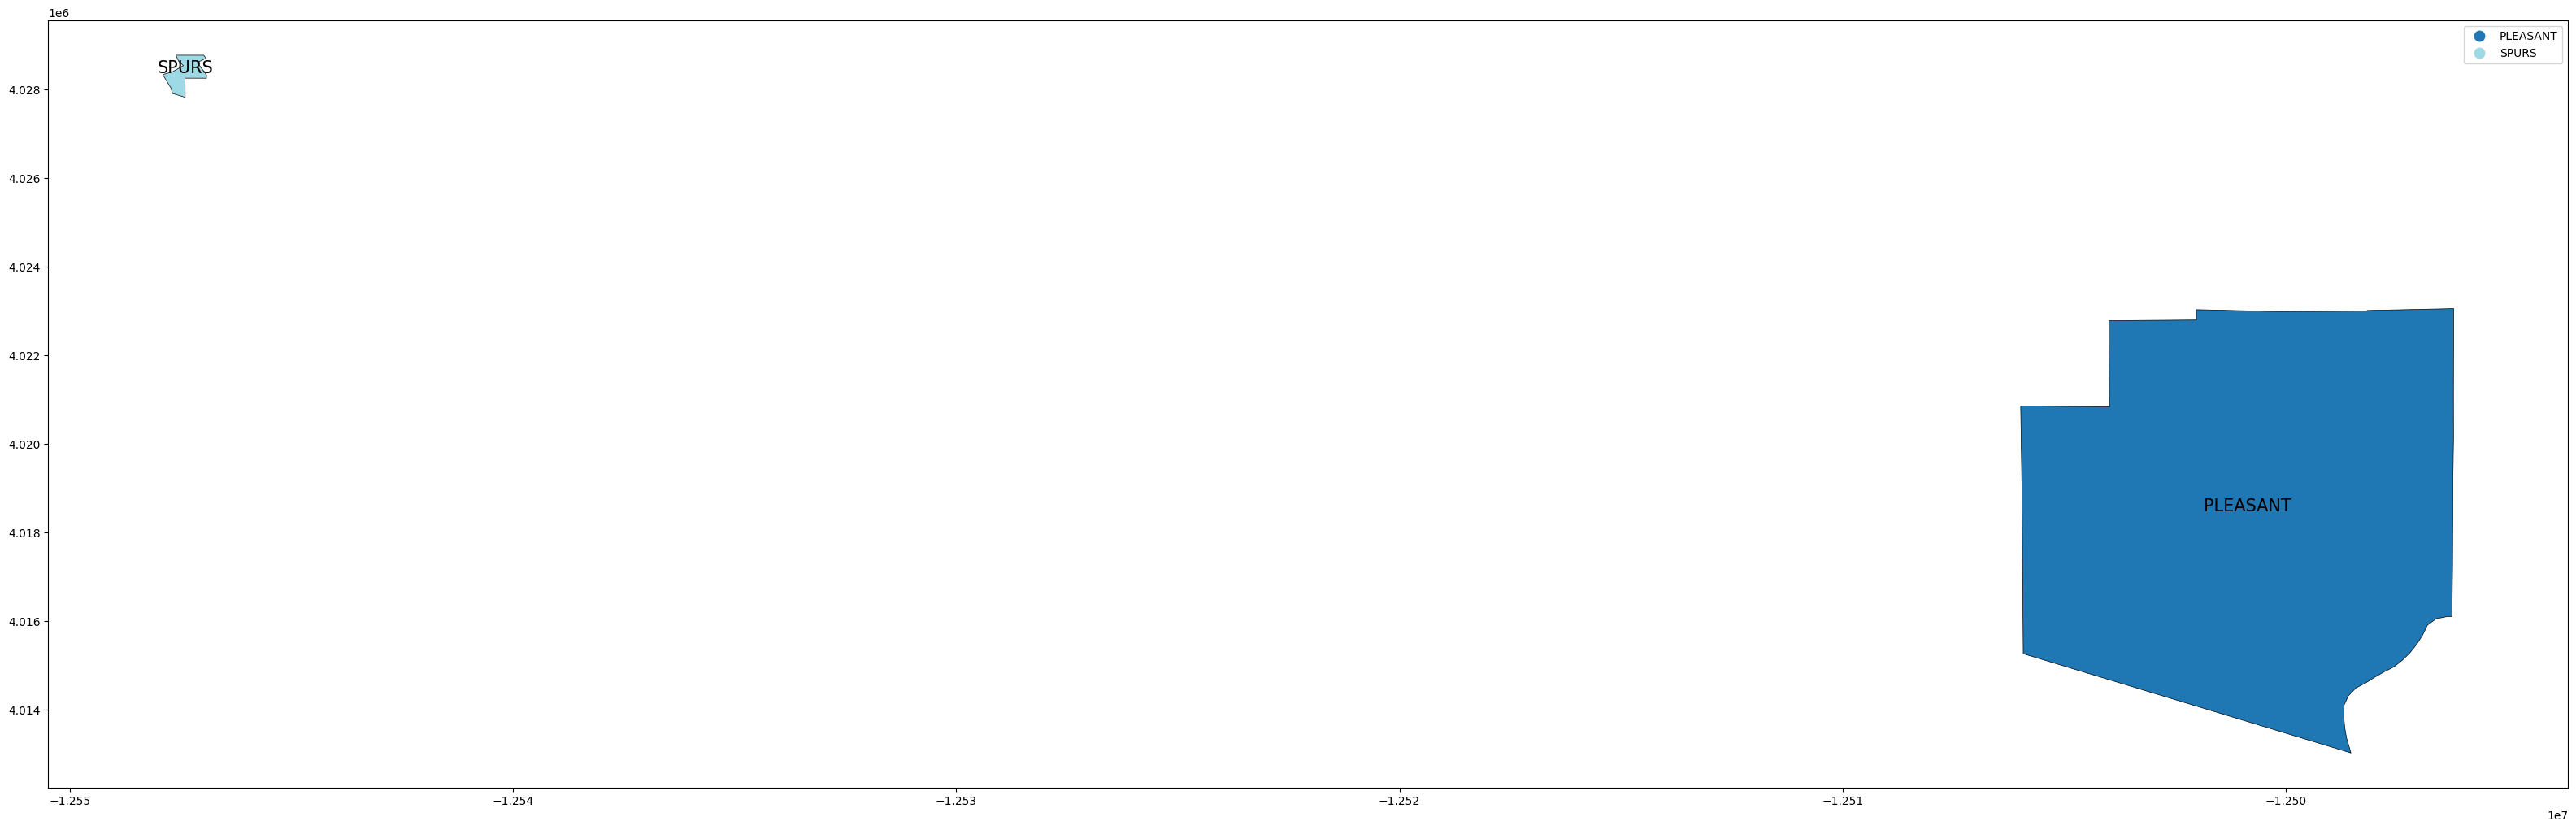

In [1094]:
right_only_org = gdf_Yavapai_final[gdf_Yavapai_final['PRECINCT'].isin(list(right_only['PRECINCT']))]
plot_precincts(right_only_org, 'PRECINCT')

In [1095]:
gdf_Yavapai_final.head(5)

county precinct  G22ATGDMAY  ...  CONG_DIST  LEG_DIST  _merge
0  Yavapai    EAGLE      2689.0  ...          2         1    both
1  Yavapai    COURT      2177.0  ...          2         1    both
2  Yavapai     FAIR      1603.0  ...          2         1    both
3  Yavapai     GOLF      2428.0  ...          2         1    both
4  Yavapai     MINE       101.0  ...          2         1    both

[5 rows x 268 columns]

In [1096]:

gdf_Yavapai_final = gdf_Yavapai_final.rename(columns={'county': 'COUNTY_NAM'})

gdf_Yavapai_final['PCTNUM'] = gdf_Yavapai_final['PREC_NUM']
gdf_Yavapai_final['PRECINCTNA'] = gdf_Yavapai_final['PRECINCT']
gdf_Yavapai_final['UNIQUE_ID'] = gdf_Yavapai_final['PREC_NUM'].astype(str) + gdf_Yavapai_final['PRECINCT']
gdf_Yavapai_final['CON_DIST'] = gdf_Yavapai_final['CONG_DIST']
gdf_Yavapai_final['SLDL_DIST'] = gdf_Yavapai_final['LEG_DIST']
gdf_Yavapai_final['SLDU_DIST'] = gdf_Yavapai_final['LEG_DIST']



gdf_Yavapai_final.drop(columns=['_merge'], inplace=True)
gdf_Yavapai_final.drop(columns=['PRECINCT'], inplace=True)
gdf_Yavapai_final.drop(columns=['PREC_NUM'], inplace=True)
gdf_Yavapai_final.drop(columns=['precinct'], inplace=True)
gdf_Yavapai_final.drop(columns=['CONG_DIST'], inplace=True)
gdf_Yavapai_final.drop(columns=['LEG_DIST'], inplace=True)



gdf_Yavapai_final['COUNTYFP'] = '025'
gdf_Yavapai_final['COUNTY_NAM'] = 'Yavapai'


cols = gdf_Yavapai_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))
cols.insert(5, cols.pop(cols.index('CON_DIST')))
cols.insert(6, cols.pop(cols.index('SLDL_DIST')))
cols.insert(7, cols.pop(cols.index('SLDU_DIST')))


gdf_Yavapai_final = gdf_Yavapai_final[cols]

# gdf_Yavapai_final = add_districts_numbers(gdf_Yavapai_final)


gdf_Yavapai_final.head(5)


UNIQUE_ID  ...                                           geometry
0  201EAGLE  ...  POLYGON ((-12518048.584 4109506.184, -12518047...
1  202COURT  ...  POLYGON ((-12514434.417 4107089.619, -12514524...
2   203FAIR  ...  POLYGON ((-12529248.407 4109509.875, -12527294...
3   204GOLF  ...  POLYGON ((-12525557.142 4103075.634, -12525509...
4   205MINE  ...  POLYGON ((-12601154.304 4130087.828, -12601156...

[5 rows x 269 columns]

In [1097]:
gdf_Yavapai_final

UNIQUE_ID  ...                                           geometry
0      201EAGLE  ...  POLYGON ((-12518048.584 4109506.184, -12518047...
1      202COURT  ...  POLYGON ((-12514434.417 4107089.619, -12514524...
2       203FAIR  ...  POLYGON ((-12529248.407 4109509.875, -12527294...
3       204GOLF  ...  POLYGON ((-12525557.142 4103075.634, -12525509...
4       205MINE  ...  POLYGON ((-12601154.304 4130087.828, -12601156...
5       206HILL  ...  POLYGON ((-12569984.744 4110308.969, -12569018...
6   207MESQUITE  ...  POLYGON ((-12599420.169 4085015.911, -12599397...
7       208YARN  ...  POLYGON ((-12540191.556 4073392.018, -12539682...
8       209WICK  ...  POLYGON ((-12558779.853 4036576.763, -12558637...
..          ...  ...                                                ...
39     241STONE  ...  POLYGON ((-12550623.122 4205485.134, -12549612...
40     242WATER  ...  POLYGON ((-12507840.888 4110192.321, -12507841...
41     243BURRO  ...  POLYGON ((-12503897.254 4115774.606, -12503897...
42     244BISON  ...  POLYGON ((-12505865.431 4111687.411, -12505860...
43   245BIGHORN  ...  POLYGON ((-12500792.861 4111609.944, -12500818...
44     246LASSO  ...  POLYGON ((-12525294.382 4039267.645, -12525293...
45     247CHAPS  ...  POLYGON ((-12548487.660 4028152.457, -12548501...
46  212PLEASANT  ...  POLYGON ((-12496208.879 4023058.904, -12496209...
47     248SPURS  ...  POLYGON ((-12547404.033 4027826.847, -12547687...

[48 rows x 269 columns]

### Yuma County
Using 2020 boundaries

In [1098]:
yuma_rows = final_df[final_df['county'].str.lower() == 'yuma']
yuma_rows['precinct'] = yuma_rows['precinct'].str.split('.').str[0]
yuma_rows.loc[yuma_rows['precinct'] == '25', 'precinct'] = '025'

yuma_rows.head(5)

county precinct  G22ATGDMAY  ...  G22USSWBOR  G22GOVWCAM  G22USSWROX
108   Yuma      001       237.0  ...         NaN         NaN         NaN
109   Yuma      002       318.0  ...         NaN         NaN         NaN
110   Yuma      003       267.0  ...         NaN         NaN         NaN
111   Yuma      004       898.0  ...         NaN         NaN         NaN
112   Yuma      005       502.0  ...         NaN         NaN         NaN

[5 rows x 262 columns]

In [1099]:
# Read the shapefile
shapefile_path_Yuma = './precinct_boundaries/yuma_2022/fwd2022voterprecinctmapasshapefiles/Voting_Pricincts_03_2023.shp'
gdf_Yuma_2022 = gpd.read_file(shapefile_path_Yuma)

gdf_Yuma_2022.head(5)

Precinct CODE  ... last_edi_1                                           geometry
0      P06  006  ...       None  POLYGON ((414371.037 592557.236, 414397.817 59...
1      P13  013  ...       None  POLYGON ((435978.953 618997.977, 436014.853 61...
2      P15  015  ...       None  POLYGON ((433544.156 612195.528, 433692.215 61...
3      P11  011  ...       None  POLYGON ((475022.622 618966.980, 475885.743 61...
4      P10  010  ...       None  POLYGON ((471023.670 609949.920, 471271.034 60...

[5 rows x 8 columns]

After checking with voter file on L2, it is confirmed that districts 21 and 44 have no voters.

In [1100]:
gdf_Yuma_final = yuma_rows.merge(gdf_Yuma_2022[['CODE', 'geometry', 'NAME']], 
                                       left_on='precinct', 
                                       right_on='CODE', 
                                       how='outer',
                                       indicator=True)

# # Drop the duplicate UNIQUE_ID column from the merged DataFrame
# gdf_Yuma_final = gdf_Yuma_final.drop(columns=['CODE'])

# Display the final DataFrame
gdf_Yuma_final

county precinct  ...          NAME      _merge
0    Yuma      001  ...  PRECINCT 001        both
1    Yuma      002  ...  PRECINCT 002        both
2    Yuma      003  ...  PRECINCT 003        both
3    Yuma      004  ...  PRECINCT 004        both
4    Yuma      005  ...  PRECINCT 005        both
5    Yuma      006  ...  PRECINCT 006        both
6    Yuma      007  ...  PRECINCT 007        both
7    Yuma      008  ...  PRECINCT 008        both
8    Yuma      009  ...  PRECINCT 009        both
..    ...      ...  ...           ...         ...
37   Yuma      039  ...  PRECINCT 039        both
38   Yuma      040  ...  PRECINCT 040        both
39   Yuma      041  ...  PRECINCT 041        both
40   Yuma      042  ...  PRECINCT 042        both
41   Yuma      043  ...  PRECINCT 043        both
42   Yuma      045  ...  PRECINCT 045        both
43   Yuma      046  ...  PRECINCT 046        both
44    NaN      NaN  ...  PRECINCT 044  right_only
45    NaN      NaN  ...  PRECINCT 021  right_only

[46 rows x 266 columns]

In [1101]:
check_precinct_districts(gdf_Yuma_final)


Row 1:
  Column: GUSH07DGRI, Office Type: USH, District: 07, Value: 248.0
  Column: GUSH07OWRI, Office Type: USH, District: 07, Value: 1.0
  Column: GUSH07RPOZ, Office Type: USH, District: 07, Value: 149.0
  Column: GSL23DJR., Office Type: SL, District: 23, Value: 174.0
  Column: GSL23DSAN, Office Type: SL, District: 23, Value: 216.0
  Column: GSL23RPEN, Office Type: SL, District: 23, Value: 152.0
  Column: GSU23DFER, Office Type: SU, District: 23, Value: 246.0
  Column: GSU23RSNY, Office Type: SU, District: 23, Value: 144.0
  Column: GSL23OWRI, Office Type: SL, District: 23, Value: 1.0
  Column: GSU23OWRI, Office Type: SU, District: 23, Value: 1.0


Row 2:
  Column: GUSH07DGRI, Office Type: USH, District: 07, Value: 311.0
  Column: GUSH07OWRI, Office Type: USH, District: 07, Value: 1.0
  Column: GUSH07RPOZ, Office Type: USH, District: 07, Value: 247.0
  Column: GSL23DJR., Office Type: SL, District: 23, Value: 236.0
  Column: GSL23DSAN, Office Type: SL, District: 23, Value: 272.0
  Col

In [1102]:
# Print the count of each category in the 'indicator' column
indicator_counts = gdf_Yuma_final['_merge'].value_counts()

# Display the counts
print(indicator_counts)

_merge
both          44
right_only     2
left_only      0
Name: count, dtype: int64


In [1103]:
gdf_Yuma_final.head(5)

county precinct  ...          NAME  _merge
0   Yuma      001  ...  PRECINCT 001    both
1   Yuma      002  ...  PRECINCT 002    both
2   Yuma      003  ...  PRECINCT 003    both
3   Yuma      004  ...  PRECINCT 004    both
4   Yuma      005  ...  PRECINCT 005    both

[5 rows x 266 columns]

In [1104]:

gdf_Yuma_final = gdf_Yuma_final.rename(columns={'county': 'COUNTY_NAM'})
gdf_Yuma_final['COUNTY_NAM'] = 'Yuma'

gdf_Yuma_final['UNIQUE_ID'] = gdf_Yuma_final['NAME']
gdf_Yuma_final['PCTNUM'] = gdf_Yuma_final['CODE']
gdf_Yuma_final['PRECINCTNA'] = gdf_Yuma_final['NAME']

gdf_Yuma_final.drop(columns=['_merge'], inplace=True)
gdf_Yuma_final.drop(columns=['precinct'], inplace=True)
gdf_Yuma_final.drop(columns=['NAME'], inplace=True)
gdf_Yuma_final.drop(columns=['CODE'], inplace=True)


gdf_Yuma_final['COUNTYFP'] = '027'


cols = gdf_Yuma_final.columns.tolist()

cols.insert(0, cols.pop(cols.index('UNIQUE_ID')))
cols.insert(1, cols.pop(cols.index('COUNTY_NAM')))
cols.insert(2, cols.pop(cols.index('COUNTYFP')))
cols.insert(3, cols.pop(cols.index('PCTNUM')))
cols.insert(4, cols.pop(cols.index('PRECINCTNA')))

gdf_Yuma_final = gdf_Yuma_final[cols]

gdf_Yuma_final = add_districts_numbers(gdf_Yuma_final)


gdf_Yuma_final.head(5)


UNIQUE_ID  ...                                           geometry
0  PRECINCT 001  ...  POLYGON ((429496.450 630170.745, 429576.325 63...
1  PRECINCT 002  ...  POLYGON ((423115.273 631438.490, 423116.142 63...
2  PRECINCT 003  ...  POLYGON ((418462.409 631543.358, 418466.388 63...
3  PRECINCT 004  ...  POLYGON ((415181.474 624391.836, 415391.868 62...
4  PRECINCT 005  ...  POLYGON ((413767.400 613769.162, 417691.044 61...

[5 rows x 269 columns]

## Combine county level PBER into state level

In [1105]:
import geopandas as gpd
import pandas as pd

# List of GeoDataFrames
gdf_list = [
    gdf_Apache_final, gdf_Cochise_final, gdf_Cococino_final, gdf_Gila_final,
    gdf_Graham_final, gdf_Greenlee_final, gdf_Maricopa_final, gdf_La_Paz_final,
    gdf_Mohave_final, gdf_Navajo_final, gdf_Pima_final, gdf_Pinal_final,
    gdf_Santa_Cruz_final, gdf_Yavapai_final, gdf_Yuma_final
]

target_crs = "EPSG:4326"
valid_gdfs = []

for i, gdf in enumerate(gdf_list):
    county_name = f"County_{i+1}" 
    print(f"Processing {county_name}...")

    if not isinstance(gdf, gpd.GeoDataFrame):
        try:
            gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
        except KeyError:
            print(f"Missing geometry column in {county_name}, skipping.")
            continue

    if gdf.crs is None:
        print(f"{county_name} has no CRS, setting to {target_crs}.")
        gdf.set_crs(target_crs, inplace=True)

    if gdf.is_empty.all():
        print(f"All geometries are empty in {county_name}, skipping.")
        continue

    valid_gdfs.append(gdf.to_crs(target_crs))

print(f"Combining {len(valid_gdfs)} GeoDataFrames...")
combined_gdf = pd.concat(valid_gdfs, ignore_index=True)

Processing County_1...
Processing County_2...
Processing County_3...
Processing County_4...
Processing County_5...
Processing County_6...
Processing County_7...
Processing County_8...
Processing County_9...
Processing County_10...
Processing County_11...
Processing County_12...
Processing County_13...
Processing County_14...
Processing County_15...
Combining 15 GeoDataFrames...


In [1106]:
# List of GeoDataFrames
gdf_list = [
    gdf_Apache_final, gdf_Cochise_final, gdf_Cococino_final, gdf_Gila_final,
    gdf_Graham_final, gdf_Greenlee_final, gdf_Maricopa_final, gdf_La_Paz_final,
    gdf_Mohave_final, gdf_Navajo_final, gdf_Pima_final, gdf_Pinal_final,
    gdf_Santa_Cruz_final, gdf_Yavapai_final, gdf_Yuma_final
]

target_crs = "EPSG:4326"
valid_gdfs = []

for gdf in gdf_list:
    if not isinstance(gdf, gpd.GeoDataFrame):
        try:
            gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
        except KeyError:
            print(f"Missing geometry column in DataFrame: {gdf}")
            continue

    if gdf.crs is None:
        gdf.set_crs(target_crs, inplace=True)

    valid_gdfs.append(gdf.to_crs(target_crs))

# Combine reprojected GeoDataFrames into a single GeoDataFrame
combined_gdf = pd.concat(valid_gdfs, ignore_index=True)

combined_gdf



UNIQUE_ID  ...                                           geometry
0               02 ALPINE  ...  POLYGON ((-109.49567 33.65280, -109.49576 33.6...
1     03 CANYON DE CHELLY  ...  POLYGON ((-109.71666 36.26151, -109.71658 36.2...
2               05 CHINLE  ...  POLYGON ((-109.81183 36.27512, -109.80810 36.2...
3               09 CONCHO  ...  POLYGON ((-109.53982 34.44871, -109.53928 34.4...
4           10 CORNFIELDS  ...  POLYGON ((-109.82694 35.53686, -109.82692 35.5...
5           11 COTTONWOOD  ...  POLYGON ((-109.81768 36.14760, -109.81822 36.1...
6             12 CORONADO  ...  POLYGON ((-109.16169 34.44067, -109.16175 34.4...
7           13 DENNEHOTSO  ...  POLYGON ((-110.00068 36.62770, -110.00068 36.6...
8                16 EAGAR  ...  POLYGON ((-109.29166 34.11102, -109.29168 34.1...
...                   ...  ...                                                ...
1723         PRECINCT 039  ...  POLYGON ((-114.63757 32.70987, -114.63757 32.7...
1724         PRECINCT 040  ...  POLYGON ((-114.64289 32.69848, -114.64185 32.6...
1725         PRECINCT 041  ...  POLYGON ((-114.66744 32.69841, -114.66597 32.6...
1726         PRECINCT 042  ...  POLYGON ((-114.65896 32.68385, -114.65693 32.6...
1727         PRECINCT 043  ...  POLYGON ((-114.59767 32.59689, -114.61511 32.5...
1728         PRECINCT 045  ...  POLYGON ((-114.62603 32.68392, -114.62463 32.6...
1729         PRECINCT 046  ...  POLYGON ((-114.52910 32.74246, -114.52906 32.7...
1730         PRECINCT 044  ...  POLYGON ((-114.40973 32.62680, -114.36686 32.6...
1731         PRECINCT 021  ...  POLYGON ((-113.33506 32.76786, -113.33464 32.7...

[1732 rows x 269 columns]

In [1107]:
combined_gdf['UNIQUE_ID'] = combined_gdf['COUNTYFP'].astype(str) + "-:-" + combined_gdf['UNIQUE_ID'].astype(str)
combined_gdf

UNIQUE_ID  ...                                           geometry
0               001-:-02 ALPINE  ...  POLYGON ((-109.49567 33.65280, -109.49576 33.6...
1     001-:-03 CANYON DE CHELLY  ...  POLYGON ((-109.71666 36.26151, -109.71658 36.2...
2               001-:-05 CHINLE  ...  POLYGON ((-109.81183 36.27512, -109.80810 36.2...
3               001-:-09 CONCHO  ...  POLYGON ((-109.53982 34.44871, -109.53928 34.4...
4           001-:-10 CORNFIELDS  ...  POLYGON ((-109.82694 35.53686, -109.82692 35.5...
5           001-:-11 COTTONWOOD  ...  POLYGON ((-109.81768 36.14760, -109.81822 36.1...
6             001-:-12 CORONADO  ...  POLYGON ((-109.16169 34.44067, -109.16175 34.4...
7           001-:-13 DENNEHOTSO  ...  POLYGON ((-110.00068 36.62770, -110.00068 36.6...
8                001-:-16 EAGAR  ...  POLYGON ((-109.29166 34.11102, -109.29168 34.1...
...                         ...  ...                                                ...
1723         027-:-PRECINCT 039  ...  POLYGON ((-114.63757 32.70987, -114.63757 32.7...
1724         027-:-PRECINCT 040  ...  POLYGON ((-114.64289 32.69848, -114.64185 32.6...
1725         027-:-PRECINCT 041  ...  POLYGON ((-114.66744 32.69841, -114.66597 32.6...
1726         027-:-PRECINCT 042  ...  POLYGON ((-114.65896 32.68385, -114.65693 32.6...
1727         027-:-PRECINCT 043  ...  POLYGON ((-114.59767 32.59689, -114.61511 32.5...
1728         027-:-PRECINCT 045  ...  POLYGON ((-114.62603 32.68392, -114.62463 32.6...
1729         027-:-PRECINCT 046  ...  POLYGON ((-114.52910 32.74246, -114.52906 32.7...
1730         027-:-PRECINCT 044  ...  POLYGON ((-114.40973 32.62680, -114.36686 32.6...
1731         027-:-PRECINCT 021  ...  POLYGON ((-113.33506 32.76786, -113.33464 32.7...

[1732 rows x 269 columns]

In [1108]:
def remove_duplicated_columns(gdf):
    duplicates = gdf.columns[gdf.columns.duplicated()].unique()
    gdf = gdf.loc[:, ~gdf.columns.duplicated()]
    return gdf

def clean_field_names(gdf):
    new_columns = {}
    seen_columns = set()
    for col in gdf.columns:
        new_col = ''.join([c if ord(c) < 128 else '' for c in col])[:10]
        # Ensure the column name is unique
        if new_col in seen_columns:
            counter = 1
            new_col_temp = new_col
            while new_col_temp in seen_columns:
                new_col_temp = f"{new_col[:8]}{counter}"
                counter += 1
            new_col = new_col_temp
        seen_columns.add(new_col)
        new_columns[col] = new_col
    gdf.rename(columns=new_columns, inplace=True)
    return gdf

combined_gdf = remove_duplicated_columns(combined_gdf)

cleaned_gdf = clean_field_names(combined_gdf)

if cleaned_gdf.columns.duplicated().any():
    print("There are still duplicated column names after cleaning.")
else:
    print("No duplicated columns after cleaning.")

cleaned_gdf.to_file("combined_gdf.shp")


No duplicated columns after cleaning.


In [1109]:
# Read the shapefile
shapefile_path_final = './combined_gdf.shp'
shapefile_final = gpd.read_file(shapefile_path_final)
shapefile_final


UNIQUE_ID  ...                                           geometry
0               001-:-02 ALPINE  ...  POLYGON ((-109.49567 33.65280, -109.49576 33.6...
1     001-:-03 CANYON DE CHELLY  ...  POLYGON ((-109.71666 36.26151, -109.71658 36.2...
2               001-:-05 CHINLE  ...  POLYGON ((-109.81183 36.27512, -109.80810 36.2...
3               001-:-09 CONCHO  ...  POLYGON ((-109.53982 34.44871, -109.53928 34.4...
4           001-:-10 CORNFIELDS  ...  POLYGON ((-109.82694 35.53686, -109.82692 35.5...
5           001-:-11 COTTONWOOD  ...  POLYGON ((-109.81768 36.14760, -109.81822 36.1...
6             001-:-12 CORONADO  ...  POLYGON ((-109.16169 34.44067, -109.16175 34.4...
7           001-:-13 DENNEHOTSO  ...  POLYGON ((-110.00068 36.62770, -110.00068 36.6...
8                001-:-16 EAGAR  ...  POLYGON ((-109.29166 34.11102, -109.29168 34.1...
...                         ...  ...                                                ...
1723         027-:-PRECINCT 039  ...  POLYGON ((-114.63757 32.70987, -114.63757 32.7...
1724         027-:-PRECINCT 040  ...  POLYGON ((-114.64289 32.69848, -114.64185 32.6...
1725         027-:-PRECINCT 041  ...  POLYGON ((-114.66744 32.69841, -114.66597 32.6...
1726         027-:-PRECINCT 042  ...  POLYGON ((-114.65896 32.68385, -114.65693 32.6...
1727         027-:-PRECINCT 043  ...  POLYGON ((-114.59767 32.59689, -114.61511 32.5...
1728         027-:-PRECINCT 045  ...  POLYGON ((-114.62603 32.68392, -114.62463 32.6...
1729         027-:-PRECINCT 046  ...  POLYGON ((-114.52910 32.74246, -114.52906 32.7...
1730         027-:-PRECINCT 044  ...  POLYGON ((-114.40973 32.62680, -114.36686 32.6...
1731         027-:-PRECINCT 021  ...  POLYGON ((-113.33506 32.76786, -113.33464 32.7...

[1732 rows x 269 columns]

In [1110]:
columns_to_fill = [col for col in shapefile_final.columns if col.startswith('G')]

shapefile_final[columns_to_fill] = shapefile_final[columns_to_fill].fillna(0)

In [1111]:
rows_with_na = shapefile_final[shapefile_final.isna().any(axis=1)]
rows_with_na

UNIQUE_ID  ...                                           geometry
260          013-:-0018 ALVARADO  ...  POLYGON ((-112.27239 33.47918, -112.27242 33.4...
274             013-:-0032 ARENA  ...  POLYGON ((-112.36624 33.38827, -112.36617 33.3...
287          013-:-0045 AVONDALE  ...  POLYGON ((-112.33241 33.45763, -112.33247 33.4...
314            013-:-0072 BOLERO  ...  POLYGON ((-112.23801 33.46248, -112.23812 33.4...
355           013-:-0113 CASHION  ...  POLYGON ((-112.27255 33.42436, -112.27259 33.4...
388   013-:-0146 COLDWATER RIDGE  ...  POLYGON ((-112.30740 33.43548, -112.30642 33.4...
403              013-:-0161 CORA  ...  POLYGON ((-112.23976 33.48928, -112.23954 33.4...
405            013-:-0163 CORDES  ...  POLYGON ((-112.22139 33.40844, -112.22138 33.4...
406          013-:-0164 CORDONIZ  ...  POLYGON ((-112.30242 33.49319, -112.30667 33.4...
...                          ...  ...                                                ...
1499                   019-:-268  ...  POLYGON ((-111.18239 32.33535, -111.18239 32.3...
1500                    019-:-27  ...  POLYGON ((-110.63714 32.51281, -110.64133 32.5...
1501                   019-:-273  ...  POLYGON ((-111.08012 32.33543, -111.08008 32.3...
1502                   019-:-278  ...  POLYGON ((-111.00157 31.89698, -111.00351 31.8...
1503                   019-:-256  ...  POLYGON ((-111.09743 32.11507, -111.09744 32.1...
1504                   019-:-270  ...  POLYGON ((-111.04413 32.31582, -111.04354 32.3...
1613  021-:-SAN CARLOS COMMUNITY  ...  POLYGON ((-110.45163 33.19423, -110.45138 33.1...
1730          027-:-PRECINCT 044  ...  POLYGON ((-114.40973 32.62680, -114.36686 32.6...
1731          027-:-PRECINCT 021  ...  POLYGON ((-113.33506 32.76786, -113.33464 32.7...

[352 rows x 269 columns]

In [1112]:
rows_with_none_county_nam = combined_gdf[combined_gdf['COUNTY_NAM'].isna()]
# rows_with_none_county_nam['COUNTY_NAM'] = 'Maricopa'
rows_with_none_county_nam

Empty GeoDataFrame
Columns: [UNIQUE_ID, COUNTY_NAM, COUNTYFP, PCTNUM, PRECINCTNA, CON_DIST, SLDL_DIST, SLDU_DIST, G22ATGDMAY, G22ATGRHAM, G22COCDKEN, G22COCDKUB, G22COCRMYE, G22COCRTHO, G22GOVDHOB, G22GOVOWRI, G22GOVRLAK, G22SOSDFON, G22SOSOWRI, G22SOSRFIN, G22STMOWRI, G22STMRMAR, G22STTDQUE, G22STTOWRI, G22STTRYEE, G22USSDKEL, G22USSLVIC, G22USSOWRI, G22USSRMAS, GSL07OWRI, GSL07RCOO, GSL07RSR., GSU07DNIT, GSU07OWRI, GSU07RROG, GUSH02DOHA, GUSH02RCRA, G22ATGOWRI, G22COCOWRI, GUSH06DENG, GUSH06RCIS, GSL16DSEA, GSL16RHUD, GSL16RMAR, GSU16DKER, GSU16RSHO, GSL17DALL, GSL17DRAD, GSL17OWRI, GSL17RJON, GSL17RMCG, GSU17DNIC, GSU17OWRI, GSU17RWAD, GUSH06OWRI, GSL16OWRI, GSU16OWRI, GUSH02OWRI, GSL15OWRI, GSL15RCAR, GSL15RPAR, GSU15DSMI, GSU15OWRI, GSU15RHOF, GUSH05DRAM, GUSH05ISMI, GUSH05RBIG, GUSH05OWRI, GUSH07DGRI, GUSH07OWRI, GUSH07RPOZ, GSL10DHUN, GSL10OWRI, GSL10RHEA, GSL10RPAR, GSU10IFIE, GSU10OWRI, GSU10RFAR, GSL23DJR., GSL23DSAN, GSL23RPEN, GSU23DFER, GSU23RSNY, GSL23OWRI, GSU23OWRI, GSL25OWRI, GSL25RCAR, GSL25RDUN, GSU25OWRI, GSU25RKER, GUSH09OWRI, GUSH09RGOS, GSL21DHAM, GSL21DHER, GSL21RKEN, GSL21RMCE, GSU21DGAB, GSU21RCLE, G22STMDGEN, G22STMMMAR, ...]
Index: []

[0 rows x 269 columns]

In [1114]:
print(shapefile_final.isna().sum()) 


UNIQUE_ID       0
COUNTY_NAM      0
COUNTYFP        0
PCTNUM          1
PRECINCTNA    278
CON_DIST       46
SLDL_DIST      46
SLDU_DIST      87
G22ATGDMAY      0
G22ATGRHAM      0
G22COCDKEN      0
G22COCDKUB      0
             ... 
G22GOVWPOU      0
GUSH02WSAR      0
G22USSWMCL      0
G22USSWMAU      0
G22GOVWNOV      0
G22USSWBUL      0
G22GOVWDEN      0
G22GOVWMER      0
G22USSWBOR      0
G22GOVWCAM      0
G22USSWROX      0
geometry        0
Length: 269, dtype: int64


In [1115]:


pd.set_option('display.max_rows', None)   # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns

import pandas as pd

common_columns = final_df.columns.intersection(shapefile_final.columns)

sum_final_df = final_df[common_columns].sum()
sum_shapefile_final = shapefile_final[common_columns].sum()

sum_comparison = pd.DataFrame({
    'final_df_sum': sum_final_df,
    'shapefile_final_sum': sum_shapefile_final,
    'difference': sum_final_df - sum_shapefile_final
})

sum_comparison


final_df_sum  shapefile_final_sum  difference
G22ATGDMAY     1272453.0            1272453.0         0.0
G22ATGRHAM     1281904.0            1281904.0         0.0
G22COCDKEN      385663.0             385663.0         0.0
G22COCDKUB      353377.0             353377.0         0.0
G22COCRMYE      376125.0             376125.0         0.0
G22COCRTHO      374299.0             374299.0         0.0
G22GOVDHOB     1287891.0            1287891.0         0.0
G22GOVOWRI        7497.0               7497.0         0.0
G22GOVRLAK     1270774.0            1270774.0         0.0
G22SOSDFON     1320053.0            1320053.0         0.0
G22SOSOWRI        3195.0               3195.0         0.0
G22SOSRFIN     1200137.0            1200137.0         0.0
G22STMOWRI       67025.0              67025.0         0.0
G22STMRMAR     1560533.0            1560533.0         0.0
G22STTDQUE     1053368.0            1053368.0         0.0
G22STTOWRI        1646.0               1646.0         0.0
G22STTRYEE     1277170.0            1277170.0         0.0
G22USSDKEL     1322032.0            1322031.0         1.0
G22USSLVIC       53762.0              53762.0         0.0
G22USSOWRI        2526.0               2526.0         0.0
G22USSRMAS     1196312.0            1196311.0         1.0
GSL07OWRI         3353.0               3353.0         0.0
GSL07RCOO        59956.0              59956.0         0.0
GSL07RSR.        52866.0              52866.0         0.0
GSU07DNIT        36030.0              36030.0         0.0
GSU07OWRI          264.0                264.0         0.0
GSU07RROG        63019.0              63019.0         0.0
GUSH02DOHA      149151.0             149151.0         0.0
GUSH02RCRA      174169.0             174169.0         0.0
G22ATGOWRI        3116.0               3116.0         0.0
G22COCOWRI        3644.0               3644.0         0.0
GUSH06DENG      171969.0             171969.0         0.0
GUSH06RCIS      177201.0             177201.0         0.0
GSL16DSEA        32831.0              32831.0         0.0
GSL16RHUD        32728.0              32728.0         0.0
GSL16RMAR        36767.0              36767.0         0.0
GSU16DKER        32636.0              32636.0         0.0
GSU16RSHO        41057.0              41057.0         0.0
GSL17DALL        57503.0              57503.0         0.0
GSL17DRAD        54013.0              54013.0         0.0
GSL17OWRI          232.0                232.0         0.0
GSL17RJON        60541.0              60541.0         0.0
GSL17RMCG        59385.0              59385.0         0.0
GSU17DNIC        60420.0              60420.0         0.0
GSU17OWRI          196.0                196.0         0.0
GSU17RWAD        63501.0              63501.0         0.0
GUSH06OWRI         609.0                609.0         0.0
GSL16OWRI          313.0                313.0         0.0
GSU16OWRI           99.0                 99.0         0.0
GUSH02OWRI         539.0                539.0         0.0
GSL15OWRI          788.0                788.0         0.0
GSL15RCAR        53883.0              53883.0         0.0
GSL15RPAR        58260.0              58260.0         0.0
GSU15DSMI        33120.0              33120.0         0.0
GSU15OWRI           53.0                 53.0         0.0
GSU15RHOF        60850.0              60850.0         0.0
GUSH05DRAM      120243.0             120243.0         0.0
GUSH05ISMI       18851.0              18851.0         0.0
GUSH05RBIG      182464.0             182464.0         0.0
GUSH05OWRI         224.0                224.0         0.0
GUSH07DGRI      124484.0             124483.0         1.0
GUSH07OWRI         354.0                354.0         0.0
GUSH07RPOZ       68324.0              68323.0         1.0
GSL10DHUN        36182.0              36182.0         0.0
GSL10OWRI           11.0                 11.0         0.0
GSL10RHEA        50024.0              50024.0         0.0
GSL10RPAR        49190.0              49190.0         0.0
GSU10IFIE        34382.0              34382.0         0.0
GSU10OWRI 

In [1116]:
common_columns = final_df.columns.intersection(shapefile_final.columns)

final_df_grouped = final_df.groupby('county')[common_columns].sum()
shapefile_final_grouped = shapefile_final.groupby('COUNTY_NAM')[common_columns].sum()

difference_by_county = final_df_grouped - shapefile_final_grouped

counties_with_differences = difference_by_county[(difference_by_county != 0).any(axis=1)]

counties_with_differences


G22ATGDMAY  G22ATGRHAM  G22COCDKEN  G22COCDKUB  G22COCRMYE  \
county                                                                   
Santa Cruz         0.0         0.0         0.0         0.0         0.0   

            G22COCRTHO  G22GOVDHOB  G22GOVOWRI  G22GOVRLAK  G22SOSDFON  \
county                                                                   
Santa Cruz         0.0         0.0         0.0         0.0         0.0   

            G22SOSOWRI  G22SOSRFIN  G22STMOWRI  G22STMRMAR  G22STTDQUE  \
county                                                                   
Santa Cruz         0.0         0.0         0.0         0.0         0.0   

            G22STTOWRI  G22STTRYEE  G22USSDKEL  G22USSLVIC  G22USSOWRI  \
county                                                                   
Santa Cruz         0.0         0.0         1.0         0.0         0.0   

            G22USSRMAS  GSL07OWRI  GSL07RCOO  GSL07RSR.  GSU07DNIT  GSU07OWRI  \
county                                                                          
Santa Cruz         1.0        0.0        0.0        0.0        0.0        0.0   

            GSU07RROG  GUSH02DOHA  GUSH02RCRA  G22ATGOWRI  G22COCOWRI  \
county                                                                  
Santa Cruz        0.0         0.0         0.0         0.0         0.0   

            GUSH06DENG  GUSH06RCIS  GSL16DSEA  GSL16RHUD  GSL16RMAR  \
county                                                                
Santa Cruz         0.0         0.0        0.0        0.0        0.0   

            GSU16DKER  GSU16RSHO  GSL17DALL  GSL17DRAD  GSL17OWRI  GSL17RJON  \
county                                                                         
Santa Cruz        0.0        0.0        0.0        0.0        0.0        0.0   

            GSL17RMCG  GSU17DNIC  GSU17OWRI  GSU17RWAD  GUSH06OWRI  GSL16OWRI  \
county                                                                          
Santa Cruz        0.0        0.0        0.0        0.0         0.0        0.0   

            GSU16OWRI  GUSH02OWRI  GSL15OWRI  GSL15RCAR  GSL15RPAR  GSU15DSMI  \
county                                                                          
Santa Cruz        0.0         0.0        0.0        0.0        0.0        0.0   

            GSU15OWRI  GSU15RHOF  GUSH05DRAM  GUSH05ISMI  GUSH05RBIG  \
county                                                                 
Santa Cruz        0.0        0.0         0.0         0.0         0.0   

            GUSH05OWRI  GUSH07DGRI  GUSH07OWRI  GUSH07RPOZ  GSL10DHUN  \
county                                                                  
Santa Cruz         0.0         1.0         0.0         1.0        0.0   

            GSL10OWRI  GSL10RHEA  GSL10RPAR  GSU10IFIE  GSU10OWRI  GSU10RFAR  \
county                                                                         
Santa Cruz        0.0        0.0        0.0        0.0        0.0        0.0   

            GSL23DJR.  GSL23DSAN  GSL23RPEN  GSU23DFER  GSU23RSNY  GSL23OWRI  \
county                                                                         
Santa Cruz        0.0        0.0        0.0        0.0        0.0        0.0   

            GSU23OWRI  GSL25OWRI  GSL25RCAR  GSL25RDUN  GSU25OWRI  GSU25RKER  \
county                                                                         
Santa Cruz        0.0        0.0        0.0        0.0        0.0        0.0   

            GUSH09OWRI  GUSH09RGOS  GSL21DHAM  GSL21DHER  GSL21RKEN  \
county                                                                
Santa Cruz         0.0         0.0        0.0        0.0        0.0   

            GSL21RMCE  GSU21DGAB  GSU21RCLE  G22STMDGEN  G22STMMMAR  \
county                                                                
Santa Cruz        0.0        0.0        0.0         0.0         0.0   

            GSL21OWRI  GSU21OWRI  G22USHDGRI  G22USHRPOZ  GSU21DHAM  \
county                                                

<Axes: >

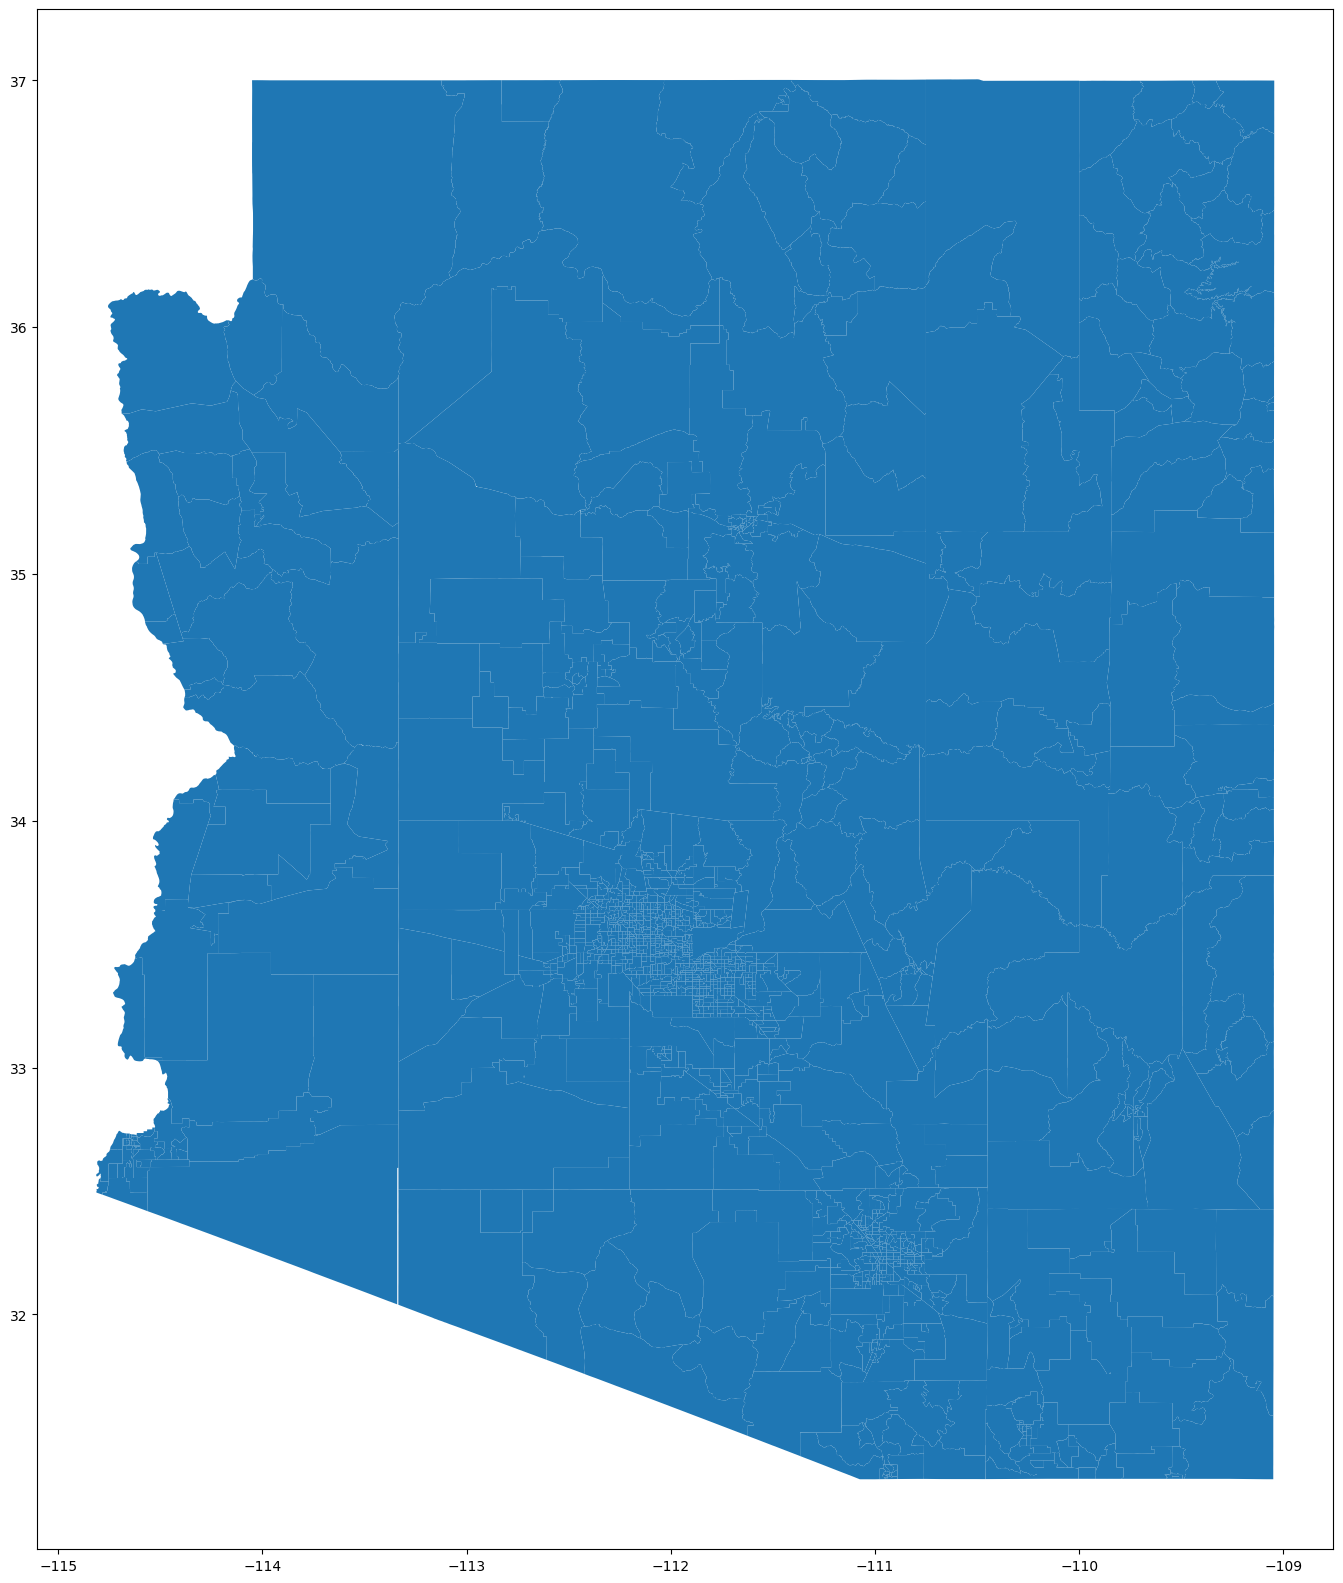

In [1117]:
# Create a larger plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the geometries
shapefile_final.plot(ax=ax)